#### This part can be included in classification based prediction 

In [7]:
import xgboost as xgb
import copy
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import warnings
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix 
import pickle
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import random
import time 

warnings.filterwarnings('ignore')

In [2]:
complete_list = ['timestamp', 'lossOrNot']
selected_features_list_removing_correlation = [
    'interarrival_std',
    'interarrival_min',
    'interarrival_max',
    'interarrival_skew',
    'interarrival_moment4',
    'interarrival_max_min_R',
    'interarrival_max_value_count_percent',
    'len_udp_moment4',
    'len_udp_max_min_diff',
    'len_udp_max_value_count_percent',
    'inter_time_sequence_std'
]
complete_list.extend(selected_features_list_removing_correlation)

full_features_list = []
for feature in selected_features_list_removing_correlation:
    for i in range(1,11):
        col_title = f'{feature}_minus_{500*i}ms'
        full_features_list.append(col_title)

In [3]:
df_complete_with_features_final = pd.read_csv('models/df_final_label_feature.csv')
df_complete_with_features_final

timestamp  lossOrNot  group_id  \
0        2020-12-14 13:34:44.500000        0.0         1   
1               2020-12-14 13:34:45        0.0         1   
2        2020-12-14 13:34:45.500000        0.0         1   
3               2020-12-14 13:34:46        0.0         1   
4        2020-12-14 13:34:46.500000        0.0         1   
...                             ...        ...       ...   
2028655     2020-05-13 14:59:09.000        0.0      6998   
2028656     2020-05-13 14:59:09.500        0.0      6998   
2028657     2020-05-13 14:59:10.000        0.0      6998   
2028658     2020-05-13 14:59:10.500        0.0      6998   
2028659     2020-05-13 14:59:11.000        0.0      6998   

         interarrival_std_minus_500ms  interarrival_std_minus_1000ms  \
0                            0.185914                       0.111167   
1                            0.169699                       0.185914   
2                            0.122365                       0.169699   
3                            0.081800                       0.122365   
4                            0.113890                       0.081800   
...                               ...                            ...   
2028655                      0.083744                       0.075046   
2028656                      0.083497                       0.083744   
2028657                      0.048801                       0.083497   
2028658                      0.133611                       0.048801   
2028659                      0.098195                       0.133611   

         interarrival_std_minus_1500ms  interarrival_std_minus_2000ms  \
0                             0.149341                       0.168203   
1                             0.111167                       0.149341   
2                             0.185914                       0.111167   
3                             0.169699                       0.185914   
4                             0.122365                       0.169699   
...                                ...                            ...   
2028655                       0.078230                       0.131936   
2028656                       0.075046                       0.078230   
2028657                       0.083744                       0.075046   
2028658                       0.083497                       0.083744   
2028659                       0.048801                       0.083497   

         interarrival_std_minus_2500ms  interarrival_std_minus_3000ms  \
0                             0.224819                       0.287330   
1                             0.168203                       0.224819   
2                             0.149341                       0.168203   
3                             0.111167                       0.149341   
4                             0.185914                       0.111167   
...                                ...                            ...   
2028655                       0.078184                       0.058745   
2028656                       0.131936                       0.078184   
2028657                       0.078230                       0.131936   
2028658                       0.075046                       0.078230   
2028659                       0.083744                       0.075046   

         interarrival_std_minus_3500ms  ...  \
0                             0.584144  ...   
1                             0.287330  ...   
2                             0.224819  ...   
3                             0.168203  ...   
4                             0.149341  ...   
...                                ...  ...   
2028655                       0.069150  ...   
2028656                       0.058745  ...   
2028657                       0.078184  ...   
2028658                       0.131936  ...   
2028659                       0.078230  ...   

         inter_time_sequence_std_minus_500ms  \
0                                   0.362588   
1                        

In [4]:
df_loss = df_complete_with_features_final[df_complete_with_features_final['lossOrNot'] > 0]
df_no_loss = df_complete_with_features_final[df_complete_with_features_final['lossOrNot'] < 1]

df_loss_shuffled = df_loss.sample(frac=1).reset_index()
df_loss_shuffled.drop(['index'], axis=1, inplace=True)
df_no_loss_shuffled = df_no_loss.sample(frac=1).reset_index()
df_no_loss_shuffled.drop(['index'], axis=1, inplace=True)

df_train = pd.concat([df_loss_shuffled.iloc[0:int(df_loss_shuffled.shape[0] * 0.7)], df_no_loss_shuffled.iloc[0:int(df_no_loss_shuffled.shape[0] * 0.7)]])
df_train_shuffled = df_train.sample(frac=1).reset_index()
df_train_shuffled.drop(['index'], axis=1, inplace=True)
df_test = pd.concat([df_loss_shuffled.iloc[int(df_loss_shuffled.shape[0] * 0.7)+1: -1], df_no_loss_shuffled.iloc[int(df_no_loss_shuffled.shape[0] * 0.7)+1: -1]])
df_test_shuffled = df_test.sample(frac=1).reset_index()
df_test_shuffled.drop(['index'], axis=1, inplace=True)

#### Check how time window affect the performance 

[0]	validation_0-aucpr:0.023759
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.026647
[2]	validation_0-aucpr:0.025711
[3]	validation_0-aucpr:0.028036
[4]	validation_0-aucpr:0.027108
[5]	validation_0-aucpr:0.028502
[6]	validation_0-aucpr:0.030847
[7]	validation_0-aucpr:0.033027
[8]	validation_0-aucpr:0.035229
[9]	validation_0-aucpr:0.038313
[10]	validation_0-aucpr:0.039423
[11]	validation_0-aucpr:0.039605
[12]	validation_0-aucpr:0.041887
[13]	validation_0-aucpr:0.043997
[14]	validation_0-aucpr:0.044679
[15]	validation_0-aucpr:0.046502
[16]	validation_0-aucpr:0.048216
[17]	validation_0-aucpr:0.048176
[18]	validation_0-aucpr:0.048684
[19]	validation_0-aucpr:0.048924
[20]	validation_0-aucpr:0.050209
[21]	validation_0-aucpr:0.052133
[22]	validation_0-aucpr:0.051857
[23]	validation_0-aucpr:0.051995
[24]	validation_0-aucpr:0.053639
[25]	validation_0-aucpr:0.05444
[26]	validation_0-aucpr:0.056562
[27]	validation_0-aucpr:0.055969
[28]	validation_0-auc

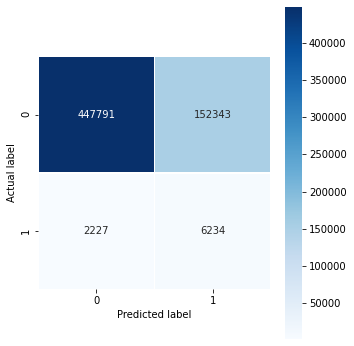

[0]	validation_0-aucpr:0.023678
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.026636
[2]	validation_0-aucpr:0.026524
[3]	validation_0-aucpr:0.026705
[4]	validation_0-aucpr:0.028125
[5]	validation_0-aucpr:0.029997
[6]	validation_0-aucpr:0.03185
[7]	validation_0-aucpr:0.032156
[8]	validation_0-aucpr:0.032675
[9]	validation_0-aucpr:0.035099
[10]	validation_0-aucpr:0.036744
[11]	validation_0-aucpr:0.037748
[12]	validation_0-aucpr:0.040504
[13]	validation_0-aucpr:0.042747
[14]	validation_0-aucpr:0.042581
[15]	validation_0-aucpr:0.044097
[16]	validation_0-aucpr:0.046118
[17]	validation_0-aucpr:0.047356
[18]	validation_0-aucpr:0.049682
[19]	validation_0-aucpr:0.050138
[20]	validation_0-aucpr:0.050957
[21]	validation_0-aucpr:0.050778
[22]	validation_0-aucpr:0.051371
[23]	validation_0-aucpr:0.052605
[24]	validation_0-aucpr:0.052179
[25]	validation_0-aucpr:0.052731
[26]	validation_0-aucpr:0.053203
[27]	validation_0-aucpr:0.053539
[28]	validation_0-auc

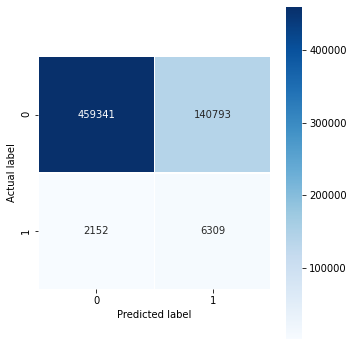

[0]	validation_0-aucpr:0.023678
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.026636
[2]	validation_0-aucpr:0.026524
[3]	validation_0-aucpr:0.027461
[4]	validation_0-aucpr:0.027645
[5]	validation_0-aucpr:0.029962
[6]	validation_0-aucpr:0.031796
[7]	validation_0-aucpr:0.032452
[8]	validation_0-aucpr:0.033003
[9]	validation_0-aucpr:0.035224
[10]	validation_0-aucpr:0.035784
[11]	validation_0-aucpr:0.036671
[12]	validation_0-aucpr:0.037955
[13]	validation_0-aucpr:0.038702
[14]	validation_0-aucpr:0.040199
[15]	validation_0-aucpr:0.041745
[16]	validation_0-aucpr:0.042991
[17]	validation_0-aucpr:0.044648
[18]	validation_0-aucpr:0.046552
[19]	validation_0-aucpr:0.046966
[20]	validation_0-aucpr:0.047746
[21]	validation_0-aucpr:0.049067
[22]	validation_0-aucpr:0.049915
[23]	validation_0-aucpr:0.051679
[24]	validation_0-aucpr:0.052371
[25]	validation_0-aucpr:0.052947
[26]	validation_0-aucpr:0.053209
[27]	validation_0-aucpr:0.054253
[28]	validation_0-au

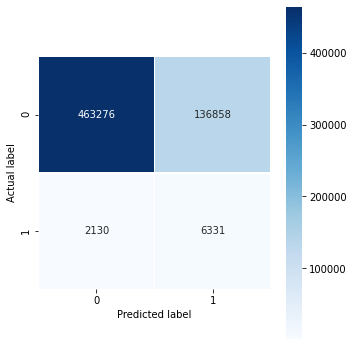

[0]	validation_0-aucpr:0.024211
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.025946
[2]	validation_0-aucpr:0.02691
[3]	validation_0-aucpr:0.027425
[4]	validation_0-aucpr:0.029461
[5]	validation_0-aucpr:0.030496
[6]	validation_0-aucpr:0.030816
[7]	validation_0-aucpr:0.032338
[8]	validation_0-aucpr:0.033568
[9]	validation_0-aucpr:0.03658
[10]	validation_0-aucpr:0.040264
[11]	validation_0-aucpr:0.040103
[12]	validation_0-aucpr:0.041452
[13]	validation_0-aucpr:0.041331
[14]	validation_0-aucpr:0.043572
[15]	validation_0-aucpr:0.044927
[16]	validation_0-aucpr:0.045615
[17]	validation_0-aucpr:0.047725
[18]	validation_0-aucpr:0.048888
[19]	validation_0-aucpr:0.050856
[20]	validation_0-aucpr:0.052341
[21]	validation_0-aucpr:0.05365
[22]	validation_0-aucpr:0.054371
[23]	validation_0-aucpr:0.055561
[24]	validation_0-aucpr:0.056615
[25]	validation_0-aucpr:0.05781
[26]	validation_0-aucpr:0.059107
[27]	validation_0-aucpr:0.059647
[28]	validation_0-aucpr:

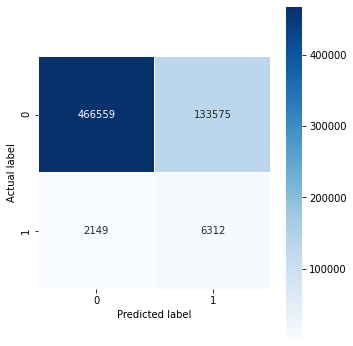

[0]	validation_0-aucpr:0.025139
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.025663
[2]	validation_0-aucpr:0.028289
[3]	validation_0-aucpr:0.028197
[4]	validation_0-aucpr:0.02996
[5]	validation_0-aucpr:0.030281
[6]	validation_0-aucpr:0.031593
[7]	validation_0-aucpr:0.032689
[8]	validation_0-aucpr:0.034938
[9]	validation_0-aucpr:0.036951
[10]	validation_0-aucpr:0.037812
[11]	validation_0-aucpr:0.039715
[12]	validation_0-aucpr:0.040129
[13]	validation_0-aucpr:0.041106
[14]	validation_0-aucpr:0.041797
[15]	validation_0-aucpr:0.043488
[16]	validation_0-aucpr:0.044902
[17]	validation_0-aucpr:0.045172
[18]	validation_0-aucpr:0.045487
[19]	validation_0-aucpr:0.047428
[20]	validation_0-aucpr:0.048751
[21]	validation_0-aucpr:0.0499
[22]	validation_0-aucpr:0.051239
[23]	validation_0-aucpr:0.051048
[24]	validation_0-aucpr:0.051491
[25]	validation_0-aucpr:0.052669
[26]	validation_0-aucpr:0.054293
[27]	validation_0-aucpr:0.056218
[28]	validation_0-aucpr

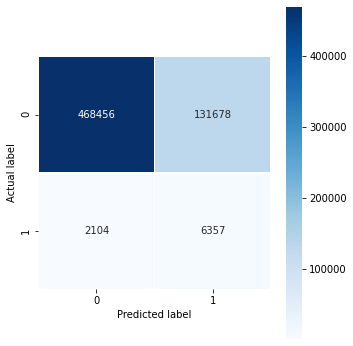

[0]	validation_0-aucpr:0.025266
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.026458
[2]	validation_0-aucpr:0.027919
[3]	validation_0-aucpr:0.028962
[4]	validation_0-aucpr:0.030632
[5]	validation_0-aucpr:0.031795
[6]	validation_0-aucpr:0.032598
[7]	validation_0-aucpr:0.033663
[8]	validation_0-aucpr:0.034883
[9]	validation_0-aucpr:0.038031
[10]	validation_0-aucpr:0.041385
[11]	validation_0-aucpr:0.042209
[12]	validation_0-aucpr:0.043792
[13]	validation_0-aucpr:0.043902
[14]	validation_0-aucpr:0.046366
[15]	validation_0-aucpr:0.048606
[16]	validation_0-aucpr:0.04931
[17]	validation_0-aucpr:0.049176
[18]	validation_0-aucpr:0.049038
[19]	validation_0-aucpr:0.050102
[20]	validation_0-aucpr:0.051274
[21]	validation_0-aucpr:0.053076
[22]	validation_0-aucpr:0.054298
[23]	validation_0-aucpr:0.054943
[24]	validation_0-aucpr:0.056271
[25]	validation_0-aucpr:0.056996
[26]	validation_0-aucpr:0.058601
[27]	validation_0-aucpr:0.059579
[28]	validation_0-auc

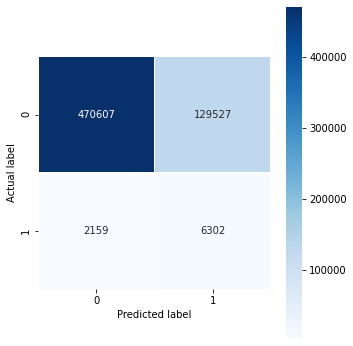

[0]	validation_0-aucpr:0.02553
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.025804
[2]	validation_0-aucpr:0.028083
[3]	validation_0-aucpr:0.028059
[4]	validation_0-aucpr:0.030665
[5]	validation_0-aucpr:0.030886
[6]	validation_0-aucpr:0.031868
[7]	validation_0-aucpr:0.033652
[8]	validation_0-aucpr:0.034751
[9]	validation_0-aucpr:0.0384
[10]	validation_0-aucpr:0.039693
[11]	validation_0-aucpr:0.040616
[12]	validation_0-aucpr:0.041857
[13]	validation_0-aucpr:0.042977
[14]	validation_0-aucpr:0.044141
[15]	validation_0-aucpr:0.046479
[16]	validation_0-aucpr:0.047567
[17]	validation_0-aucpr:0.04704
[18]	validation_0-aucpr:0.048731
[19]	validation_0-aucpr:0.0501
[20]	validation_0-aucpr:0.050898
[21]	validation_0-aucpr:0.052911
[22]	validation_0-aucpr:0.054242
[23]	validation_0-aucpr:0.056072
[24]	validation_0-aucpr:0.056696
[25]	validation_0-aucpr:0.057108
[26]	validation_0-aucpr:0.057713
[27]	validation_0-aucpr:0.059472
[28]	validation_0-aucpr:0.

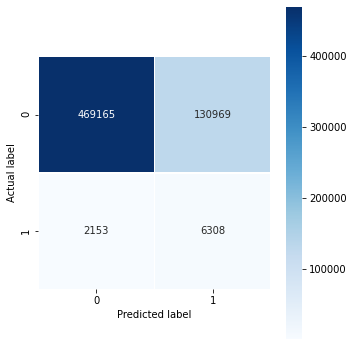

[0]	validation_0-aucpr:0.025603
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.026756
[2]	validation_0-aucpr:0.02829
[3]	validation_0-aucpr:0.028357
[4]	validation_0-aucpr:0.031051
[5]	validation_0-aucpr:0.031361
[6]	validation_0-aucpr:0.031601
[7]	validation_0-aucpr:0.034341
[8]	validation_0-aucpr:0.03585
[9]	validation_0-aucpr:0.036981
[10]	validation_0-aucpr:0.039299
[11]	validation_0-aucpr:0.04052
[12]	validation_0-aucpr:0.041203
[13]	validation_0-aucpr:0.042505
[14]	validation_0-aucpr:0.044704
[15]	validation_0-aucpr:0.046361
[16]	validation_0-aucpr:0.048139
[17]	validation_0-aucpr:0.048891
[18]	validation_0-aucpr:0.048492
[19]	validation_0-aucpr:0.049572
[20]	validation_0-aucpr:0.050714
[21]	validation_0-aucpr:0.052888
[22]	validation_0-aucpr:0.053396
[23]	validation_0-aucpr:0.054649
[24]	validation_0-aucpr:0.055259
[25]	validation_0-aucpr:0.057272
[26]	validation_0-aucpr:0.05777
[27]	validation_0-aucpr:0.059396
[28]	validation_0-aucpr:

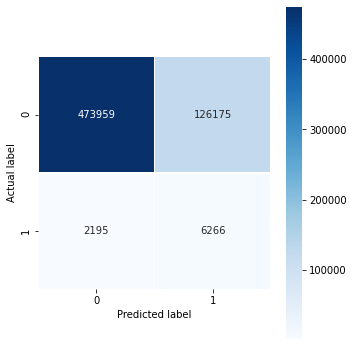

[0]	validation_0-aucpr:0.025677
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.0269
[2]	validation_0-aucpr:0.02826
[3]	validation_0-aucpr:0.028755
[4]	validation_0-aucpr:0.03083
[5]	validation_0-aucpr:0.03141
[6]	validation_0-aucpr:0.032249
[7]	validation_0-aucpr:0.034865
[8]	validation_0-aucpr:0.035619
[9]	validation_0-aucpr:0.038155
[10]	validation_0-aucpr:0.039413
[11]	validation_0-aucpr:0.040038
[12]	validation_0-aucpr:0.041708
[13]	validation_0-aucpr:0.042796
[14]	validation_0-aucpr:0.045299
[15]	validation_0-aucpr:0.04682
[16]	validation_0-aucpr:0.048727
[17]	validation_0-aucpr:0.049772
[18]	validation_0-aucpr:0.051377
[19]	validation_0-aucpr:0.051732
[20]	validation_0-aucpr:0.053789
[21]	validation_0-aucpr:0.055239
[22]	validation_0-aucpr:0.056183
[23]	validation_0-aucpr:0.056444
[24]	validation_0-aucpr:0.057
[25]	validation_0-aucpr:0.05792
[26]	validation_0-aucpr:0.058563
[27]	validation_0-aucpr:0.060358
[28]	validation_0-aucpr:0.0609

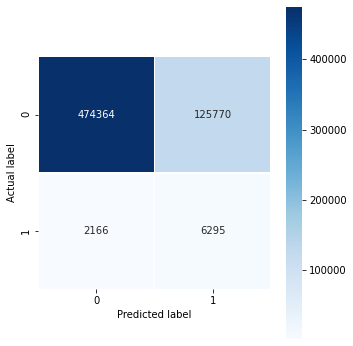

[0]	validation_0-aucpr:0.025677
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.026752
[2]	validation_0-aucpr:0.028154
[3]	validation_0-aucpr:0.028727
[4]	validation_0-aucpr:0.030762
[5]	validation_0-aucpr:0.031308
[6]	validation_0-aucpr:0.032205
[7]	validation_0-aucpr:0.034851
[8]	validation_0-aucpr:0.035754
[9]	validation_0-aucpr:0.038032
[10]	validation_0-aucpr:0.039334
[11]	validation_0-aucpr:0.040336
[12]	validation_0-aucpr:0.041601
[13]	validation_0-aucpr:0.042642
[14]	validation_0-aucpr:0.045153
[15]	validation_0-aucpr:0.045919
[16]	validation_0-aucpr:0.047888
[17]	validation_0-aucpr:0.048989
[18]	validation_0-aucpr:0.048903
[19]	validation_0-aucpr:0.050281
[20]	validation_0-aucpr:0.051663
[21]	validation_0-aucpr:0.052715
[22]	validation_0-aucpr:0.053233
[23]	validation_0-aucpr:0.054549
[24]	validation_0-aucpr:0.055395
[25]	validation_0-aucpr:0.05631
[26]	validation_0-aucpr:0.057077
[27]	validation_0-aucpr:0.058841
[28]	validation_0-auc

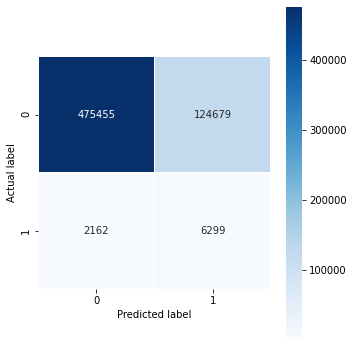

In [6]:
acc = []
precision = []                                         
recall = []
f1 = []
label = [f'-{500*x}ms' for x in range(10, 0, -1)]

for num_feature in range(2,12):
    
    # build features
    shrink_feature_list = []
    for feature in selected_features_list_removing_correlation:
        for i in range(1, num_feature):
            col_title = f'{feature}_minus_{500*i}ms'
            shrink_feature_list.append(col_title)
            
    # build training and testing dataset
    x_train_new = df_train_shuffled[shrink_feature_list]
    x_test_new = df_test_shuffled[shrink_feature_list]
    y_train_new = df_train_shuffled[['lossOrNot']]
    y_train_new = y_train_new.astype(int)
    y_test_new = df_test_shuffled[['lossOrNot']]
    y_test_new = y_test_new.astype(int)
    
    clf_xgb_check = xgb.XGBClassifier(n_estimators=300, objective='binary:logistic', scale_pos_weight=70, n_jobs=48, random_state=0)
    clf_xgb_check.fit(x_train_new, y_train_new, early_stopping_rounds=10, eval_metric='aucpr', eval_set=[(x_test_new, y_test_new)])
    
    # output result
    y_pred = clf_xgb_check.predict(x_test_new)
    print(f"Prediction Report with features of past {(num_feature-1)*500}ms\n", classification_report(y_test_new, y_pred))
    cm = confusion_matrix(y_test_new, y_pred)
    plt.figure(figsize=(5,5))
    sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
    # store the result, note that the order of values here is opposite with the label, need to reverse later
    report = classification_report(y_test_new, y_pred, output_dict=True)
    acc.append(report['accuracy'])
    precision.append(report['macro avg']['precision'])                                  
    recall.append(report['macro avg']['recall'])
    f1.append(report['macro avg']['f1-score'])

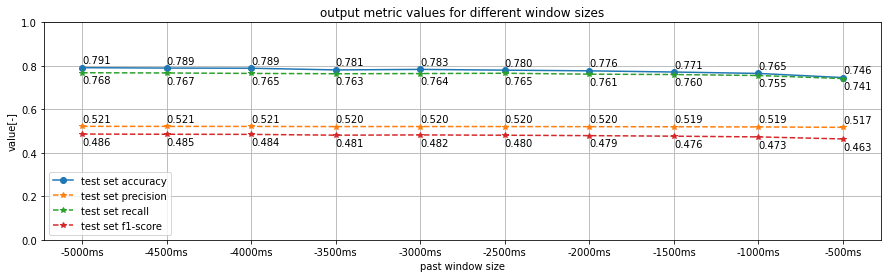

In [8]:
acc_rev = list(reversed(acc))
precision_rev = list(reversed(precision))                                      
recall_rev = list(reversed(recall))
f1_rev = list(reversed(f1))

plt.figure(figsize=(15,4))
plt.ylim(0,1)
plt.plot(label, acc_rev, 'o-', label='test set accuracy')
plt.plot(label, precision_rev, '*--', label='test set precision')
plt.plot(label, recall_rev, '*--', label='test set recall')
plt.plot(label, f1_rev, '*--', label='test set f1-score')

for i, txt in enumerate(acc_rev):
    plt.annotate(str(txt)[0:5], (label[i], acc_rev[i]+0.02))
for i, txt in enumerate(precision_rev):
    plt.annotate(str(txt)[0:5], (label[i], precision_rev[i]+0.02))
for i, txt in enumerate(recall_rev):
    plt.annotate(str(txt)[0:5], (label[i], recall_rev[i]-0.05))
for i, txt in enumerate(f1_rev):
    plt.annotate(str(txt)[0:5], (label[i], f1_rev[i]-0.05))
    
plt.legend()
plt.xlabel('past window size')
plt.ylabel('value[-]')
plt.title('output metric values for different window sizes')
plt.grid()
plt.show()

#### Check how default XGBClassifier (only specify the 'scale_pos_weight' to deal with imbalanced dataset) behaves with best time window (full window)

In [5]:
x_train = df_train_shuffled[full_features_list]
x_test = df_test_shuffled[full_features_list]
y_train = df_train_shuffled[['lossOrNot']]
y_train = y_train.astype(int)
y_test = df_test_shuffled[['lossOrNot']]
y_test = y_test.astype(int)

[0]	validation_0-aucpr:0.02585
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.026786
[2]	validation_0-aucpr:0.027393
[3]	validation_0-aucpr:0.028993
[4]	validation_0-aucpr:0.030822
[5]	validation_0-aucpr:0.032554
[6]	validation_0-aucpr:0.033193
[7]	validation_0-aucpr:0.035574
[8]	validation_0-aucpr:0.038085
[9]	validation_0-aucpr:0.038831
[10]	validation_0-aucpr:0.042
[11]	validation_0-aucpr:0.043299
[12]	validation_0-aucpr:0.045843
[13]	validation_0-aucpr:0.04599
[14]	validation_0-aucpr:0.047084
[15]	validation_0-aucpr:0.048214
[16]	validation_0-aucpr:0.050211
[17]	validation_0-aucpr:0.051694
[18]	validation_0-aucpr:0.053209
[19]	validation_0-aucpr:0.054448
[20]	validation_0-aucpr:0.055614
[21]	validation_0-aucpr:0.056364
[22]	validation_0-aucpr:0.057554
[23]	validation_0-aucpr:0.058299
[24]	validation_0-aucpr:0.059268
[25]	validation_0-aucpr:0.060735
[26]	validation_0-aucpr:0.060498
[27]	validation_0-aucpr:0.061208
[28]	validation_0-aucpr:0

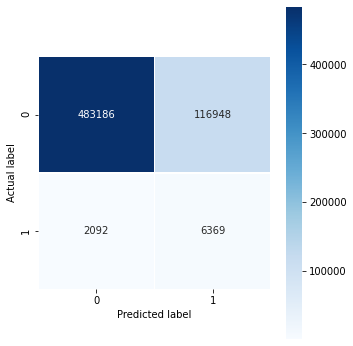

In [127]:
clf_xgb_check_default = xgb.XGBClassifier(
    n_estimators=1000, 
    objective='binary:logistic', 
    scale_pos_weight=70, 
    n_jobs=48
)

clf_xgb_check_default.fit(x_train, y_train, early_stopping_rounds=10, eval_metric='aucpr', eval_set=[(x_test, y_test)])

y_pred = clf_xgb_check_default.predict(x_test)
print(f"Prediction Report of trial\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm, linewidths=.5, annot=True, square=True, cmap='Blues', fmt='d')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

#### Model tuning

#### Use the following to check the random search and the eventual trainning based on early stopping, since the evaluation is based on 'aucpr', it will try to optimize the overall performance (reflect in the final metric of f1 score) instead of our taget: recall. If I want to use recall for evaluation, it doesn't work because 'binary:logistic' outputs float which cannot be used to compare with binary label to calculate recall and it will yield an error. It will work if I do not specify scoring. In the follwoing, I will also introduce different number of iterations into parameters to output the model with best recall and in this case, no more further training. 

In [6]:
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [7]:
my_xgb_model_tuning = xgb.XGBRegressor(n_jobs=48, objective='binary:logistic')

params = {
    "learning_rate": uniform(0.01, 0.3), 
    "gamma": uniform(0, 1),
    "max_depth": randint(2, 8), 
    "subsample": uniform(0.6, 0.4),
    "colsample_bytree": uniform(0.7, 0.3),
    'reg_lambda': randint(1, 50),
    'reg_alpha': randint(0, 50),
    "scale_pos_weight": uniform(60, 20),
    "n_estimators": randint(100, 120)
}

random_search_xgb = RandomizedSearchCV(
    my_xgb_model_tuning, 
    param_distributions = params, 
    random_state = 33, 
    n_iter = 100, 
    cv = 3, 
    verbose = 1, 
    n_jobs = 1, 
    return_train_score = True,
#     scoring = 'recall_macro',
    error_score="raise"
)

In [8]:
random_search_xgb.fit(x_train, y_train, eval_metric='aucpr')

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, error_score='raise',
                   estimator=XGBRegressor(n_jobs=48,
                                          objective='binary:logistic'),
                   n_iter=100, n_jobs=1,
                   param_distributions={'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff2d38c3890>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff2d38c3510>,
                                        'learning_rate': <scipy.stats._distn_infr...
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff2da1971d0>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff2d38c3e50>,
                                        'scale_pos_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff2da197410>,
                                        'subsample': <scipy.stats._

In [9]:
report_best_scores(random_search_xgb.cv_results_, 3)

Model with rank: 1
Mean validation score: -4.215 (std: 0.073)
Parameters: {'colsample_bytree': 0.990558309729793, 'gamma': 0.23235911731057268, 'learning_rate': 0.2703759342561626, 'max_depth': 7, 'n_estimators': 104, 'reg_alpha': 15, 'reg_lambda': 41, 'scale_pos_weight': 64.83183306125856, 'subsample': 0.8854115210541094}

Model with rank: 2
Mean validation score: -4.238 (std: 0.121)
Parameters: {'colsample_bytree': 0.9327324982249051, 'gamma': 0.6167738736212971, 'learning_rate': 0.2561019768864841, 'max_depth': 7, 'n_estimators': 105, 'reg_alpha': 21, 'reg_lambda': 16, 'scale_pos_weight': 61.25457550944723, 'subsample': 0.6160602059374378}

Model with rank: 3
Mean validation score: -4.444 (std: 0.132)
Parameters: {'colsample_bytree': 0.8159400507060515, 'gamma': 0.11454203068574453, 'learning_rate': 0.25386026981172066, 'max_depth': 7, 'n_estimators': 117, 'reg_alpha': 9, 'reg_lambda': 3, 'scale_pos_weight': 74.20409002023457, 'subsample': 0.7658109780826076}



In [10]:
random_search_xgb.best_estimator_

XGBRegressor(colsample_bytree=0.990558309729793, gamma=0.23235911731057268,
             learning_rate=0.2703759342561626, max_depth=7, n_estimators=104,
             n_jobs=48, objective='binary:logistic', reg_alpha=15,
             reg_lambda=41, scale_pos_weight=64.83183306125856,
             subsample=0.8854115210541094)

In [11]:
new_params = {'n_estimators':1000, 'n_jobs':48}
random_search_xgb.best_estimator_.set_params(**new_params)

XGBRegressor(colsample_bytree=0.990558309729793, gamma=0.23235911731057268,
             learning_rate=0.2703759342561626, max_depth=7, n_estimators=1000,
             n_jobs=48, objective='binary:logistic', reg_alpha=15,
             reg_lambda=41, scale_pos_weight=64.83183306125856,
             subsample=0.8854115210541094)

#### Final model buidling with early stopping

In [12]:
random_search_xgb.best_estimator_.fit(x_train, y_train, early_stopping_rounds=10, eval_metric='aucpr', eval_set=[(x_test, y_test)])

[0]	validation_0-aucpr:0.05536
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.074112
[2]	validation_0-aucpr:0.0814
[3]	validation_0-aucpr:0.091095
[4]	validation_0-aucpr:0.097402
[5]	validation_0-aucpr:0.103397
[6]	validation_0-aucpr:0.108103
[7]	validation_0-aucpr:0.108808
[8]	validation_0-aucpr:0.112172
[9]	validation_0-aucpr:0.114038
[10]	validation_0-aucpr:0.117638
[11]	validation_0-aucpr:0.120653
[12]	validation_0-aucpr:0.122811
[13]	validation_0-aucpr:0.123581
[14]	validation_0-aucpr:0.126653
[15]	validation_0-aucpr:0.127282
[16]	validation_0-aucpr:0.129533
[17]	validation_0-aucpr:0.132015
[18]	validation_0-aucpr:0.133258
[19]	validation_0-aucpr:0.134238
[20]	validation_0-aucpr:0.13451
[21]	validation_0-aucpr:0.136847
[22]	validation_0-aucpr:0.138562
[23]	validation_0-aucpr:0.141007
[24]	validation_0-aucpr:0.141893
[25]	validation_0-aucpr:0.142132
[26]	validation_0-aucpr:0.143565
[27]	validation_0-aucpr:0.144891
[28]	validation_0-aucpr:

XGBRegressor(colsample_bytree=0.990558309729793, gamma=0.23235911731057268,
             learning_rate=0.2703759342561626, max_depth=7, n_estimators=1000,
             n_jobs=48, objective='binary:logistic', reg_alpha=15,
             reg_lambda=41, scale_pos_weight=64.83183306125856,
             subsample=0.8854115210541094)

Prediction Report of trial
               precision    recall  f1-score   support

           0       0.99      0.97      0.98    600134
           1       0.18      0.49      0.27      8461

    accuracy                           0.96    608595
   macro avg       0.59      0.73      0.62    608595
weighted avg       0.98      0.96      0.97    608595



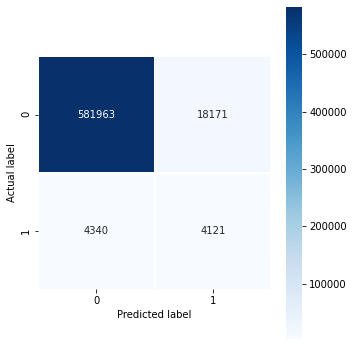

In [16]:
y_pred = random_search_xgb.best_estimator_.predict(x_test)
y_pred_label = [0 if x<0.5 else 1 for x in y_pred]
print(f"Prediction Report of trial\n", classification_report(y_test, y_pred_label))
cm = confusion_matrix(y_test, y_pred_label)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm, linewidths=.5, annot=True, square=True, cmap='Blues', fmt='d')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

#### Include number of iterations in the tuning and do the training manually

In [6]:
# refer to this !!!!!!
# I have to do the random search manually to solve the following problem.
# I want optimize the behaviour in terms of recall
# also tuning the number of iterations to check the change of recall,
# since in the previous case, the the evaluilation based on 'aucpr' will eventually optimize the overall behaviour, which reflects in f1 score,
# but we care about the recall for both classes

max_macro_recall = 0
result_param = {
    'learning_rate': None,
    'gamma' : None,
    'max_depth' : None, 
    'subsample' : None,
    'colsample_bytree' : None,
    'reg_lambda' : None,
    'reg_alpha' : None,
    'scale_pos_weight' : None,
    'n_estimators': None
}

for trial in range(0, 200):
    
    learning_rate = random.uniform(0.01, 0.31)
    gamma = random.uniform(0, 1)
    max_depth = random.randint(2, 10)
    subsample = random.uniform(0.6, 1)
    colsample_bytree = random.uniform(0.7, 1)
    reg_lambda = random.randint(1, 50)
    reg_alpha = random.randint(0, 50)
    scale_pos_weight = random.uniform(60, 80)
    n_estimators = random.randint(100, 500)
        
    my_xgb_model_tuning = xgb.XGBRegressor(
        learning_rate = learning_rate,
        gamma = gamma,
        max_depth = max_depth, 
        subsample = subsample,
        colsample_bytree = colsample_bytree,
        reg_lambda = reg_lambda,
        reg_alpha = reg_alpha,
        scale_pos_weight = scale_pos_weight,
        n_estimators = n_estimators,
        n_jobs = 48, 
        objective = 'binary:logistic',
        random_state = 0,
        verbosity = 0
    )
    
    my_xgb_model_tuning.fit(x_train, y_train, early_stopping_rounds=10, eval_metric='aucpr', eval_set=[(x_test, y_test)])
    y_pred = my_xgb_model_tuning.predict(x_test)
    
    y_pred_label = [0 if x<0.5 else 1 for x in y_pred]
    report = classification_report(y_test, y_pred_label, output_dict=True)
    macro_recall = report['macro avg']['recall']
    if macro_recall > max_macro_recall:
        max_macro_recall = macro_recall
        result_param['learning_rate'] = learning_rate
        result_param['gamma'] = gamma
        result_param['max_depth'] = max_depth
        result_param['subsample'] = subsample
        result_param['colsample_bytree'] = colsample_bytree
        result_param['reg_lambda'] = reg_lambda
        result_param['reg_alpha'] = reg_alpha
        result_param['scale_pos_weight'] = scale_pos_weight
        result_param['n_estimators'] = n_estimators
        recall_0_best = report['0']['recall']
        recall_1_best = report['1']['recall']

[0]	validation_0-aucpr:0.024664
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.028686
[2]	validation_0-aucpr:0.029863
[3]	validation_0-aucpr:0.032426
[4]	validation_0-aucpr:0.03287
[5]	validation_0-aucpr:0.036546
[6]	validation_0-aucpr:0.0378
[7]	validation_0-aucpr:0.040923
[8]	validation_0-aucpr:0.04097
[9]	validation_0-aucpr:0.040988
[10]	validation_0-aucpr:0.043357
[11]	validation_0-aucpr:0.045657
[12]	validation_0-aucpr:0.049619
[13]	validation_0-aucpr:0.050488
[14]	validation_0-aucpr:0.052787
[15]	validation_0-aucpr:0.053841
[16]	validation_0-aucpr:0.055598
[17]	validation_0-aucpr:0.057704
[18]	validation_0-aucpr:0.059157
[19]	validation_0-aucpr:0.059333
[20]	validation_0-aucpr:0.061476
[21]	validation_0-aucpr:0.062298
[22]	validation_0-aucpr:0.063413
[23]	validation_0-aucpr:0.064837
[24]	validation_0-aucpr:0.065447
[25]	validation_0-aucpr:0.0669
[26]	validation_0-aucpr:0.068074
[27]	validation_0-aucpr:0.068114
[28]	validation_0-aucpr:0.

In [14]:
print(f'The highest macro recall is {max_macro_recall}, while the recall for class 0 is {recall_0_best} and the recall for class 1 is {recall_1_best}')

The highest macro recall is 0.7972718888353441, while the recall for class 0 is 0.855742217571409 and the recall for class 1 is 0.738801560099279


In [12]:
# best parameters
result_param

{'learning_rate': 0.138291641997073,
 'gamma': 0.11468025232756118,
 'max_depth': 5,
 'subsample': 0.7303257684188209,
 'colsample_bytree': 0.8397581183840505,
 'reg_lambda': 10,
 'reg_alpha': 38,
 'scale_pos_weight': 77.9123364143053,
 'n_estimators': 403}

In [11]:
# reproduce the best model targeting recall

my_xgb_model_final = xgb.XGBRegressor(
    learning_rate = 0.138291641997073,
    gamma = 0.11468025232756118,
    max_depth = 5, 
    subsample = 0.7303257684188209,
    colsample_bytree = 0.8397581183840505,
    reg_lambda = 10,
    reg_alpha = 38,
    scale_pos_weight = 77.9123364143053,
    n_estimators = 403,
    n_jobs = 48, 
    objective = 'binary:logistic',
    random_state = 0
)

my_xgb_model_final.fit(x_train, y_train, early_stopping_rounds=10, eval_metric='aucpr', eval_set=[(x_test, y_test)])

[0]	validation_0-aucpr:0.03389
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.045449
[2]	validation_0-aucpr:0.053015
[3]	validation_0-aucpr:0.057953
[4]	validation_0-aucpr:0.059419
[5]	validation_0-aucpr:0.060404
[6]	validation_0-aucpr:0.063594
[7]	validation_0-aucpr:0.067802
[8]	validation_0-aucpr:0.07207
[9]	validation_0-aucpr:0.073497
[10]	validation_0-aucpr:0.079295
[11]	validation_0-aucpr:0.081387
[12]	validation_0-aucpr:0.082974
[13]	validation_0-aucpr:0.085476
[14]	validation_0-aucpr:0.087306
[15]	validation_0-aucpr:0.089138
[16]	validation_0-aucpr:0.090676
[17]	validation_0-aucpr:0.092254
[18]	validation_0-aucpr:0.092562
[19]	validation_0-aucpr:0.097549
[20]	validation_0-aucpr:0.099097
[21]	validation_0-aucpr:0.100442
[22]	validation_0-aucpr:0.102092
[23]	validation_0-aucpr:0.102882
[24]	validation_0-aucpr:0.103094
[25]	validation_0-aucpr:0.104753
[26]	validation_0-aucpr:0.106186
[27]	validation_0-aucpr:0.10666
[28]	validation_0-aucpr

XGBRegressor(colsample_bytree=0.8397581183840505, gamma=0.11468025232756118,
             learning_rate=0.138291641997073, max_depth=5, n_estimators=403,
             n_jobs=48, objective='binary:logistic', reg_alpha=38,
             reg_lambda=10, scale_pos_weight=77.9123364143053,
             subsample=0.7303257684188209)

Prediction Report of trial
               precision    recall  f1-score   support

           0       1.00      0.85      0.92    600134
           1       0.07      0.74      0.12      8461

    accuracy                           0.85    608595
   macro avg       0.53      0.80      0.52    608595
weighted avg       0.98      0.85      0.91    608595



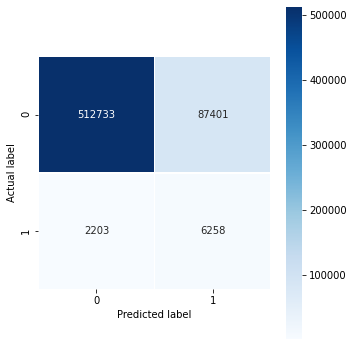

In [12]:
y_pred = my_xgb_model_final.predict(x_test)
y_pred_label = [0 if x<0.5 else 1 for x in y_pred]
print(f"Prediction Report of trial\n", classification_report(y_test, y_pred_label))
cm = confusion_matrix(y_test, y_pred_label)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm, linewidths=.5, annot=True, square=True, cmap='Blues', fmt='d')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [8]:
# check prediction time consumption

df_feature = df_complete_with_features_final[full_features_list]
idx_list = random.sample(range(0, 2028661), 100)
total_time = 0

for idx in idx_list:
    start = time.time()
    _ = my_xgb_model_final.predict(df_feature.iloc[[idx]])
    stop = time.time()
    total_time += stop - start
    
total_time /= 100
print(f'The time consumption for a prediction is {total_time}s, that is {total_time*1000}ms')

The time consumption for a prediction is 0.002813565731048584s, that is 2.813565731048584ms


#### check impact of predicting farther future

In [15]:
df_loss = df_complete_with_features_final[df_complete_with_features_final['lossOrNot'] > 0]
df_no_loss = df_complete_with_features_final[df_complete_with_features_final['lossOrNot'] < 1]

df_loss_shuffled = df_loss.sample(frac=1).reset_index()
df_loss_shuffled.drop(['index'], axis=1, inplace=True)
df_no_loss_shuffled = df_no_loss.sample(frac=1).reset_index()
df_no_loss_shuffled.drop(['index'], axis=1, inplace=True)

df_train = pd.concat([df_loss_shuffled.iloc[0:int(df_loss_shuffled.shape[0] * 0.7)], df_no_loss_shuffled.iloc[0:int(df_no_loss_shuffled.shape[0] * 0.7)]])
df_train_shuffled = df_train.sample(frac=1).reset_index()
df_train_shuffled.drop(['index'], axis=1, inplace=True)
df_test = pd.concat([df_loss_shuffled.iloc[int(df_loss_shuffled.shape[0] * 0.7)+1: -1], df_no_loss_shuffled.iloc[int(df_no_loss_shuffled.shape[0] * 0.7)+1: -1]])
df_test_shuffled = df_test.sample(frac=1).reset_index()
df_test_shuffled.drop(['index'], axis=1, inplace=True)

Prediction Report
               precision    recall  f1-score   support

           0       1.00      0.84      0.91    600134
           1       0.06      0.76      0.11      8461

    accuracy                           0.84    608595
   macro avg       0.53      0.80      0.51    608595
weighted avg       0.98      0.84      0.90    608595



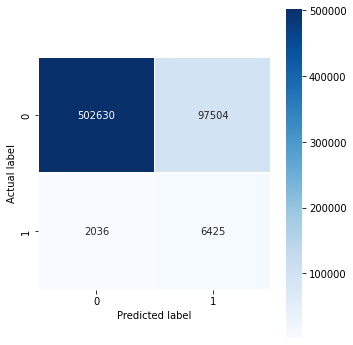

Prediction Report
               precision    recall  f1-score   support

           0       1.00      0.83      0.90    600134
           1       0.06      0.75      0.11      8461

    accuracy                           0.83    608595
   macro avg       0.53      0.79      0.51    608595
weighted avg       0.98      0.83      0.89    608595



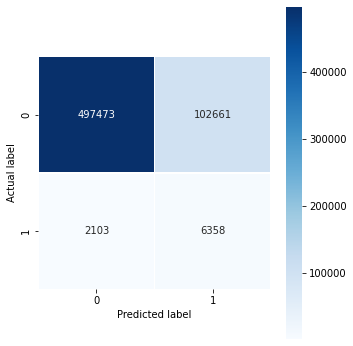

Prediction Report
               precision    recall  f1-score   support

           0       1.00      0.82      0.90    600134
           1       0.06      0.75      0.10      8461

    accuracy                           0.82    608595
   macro avg       0.53      0.79      0.50    608595
weighted avg       0.98      0.82      0.89    608595



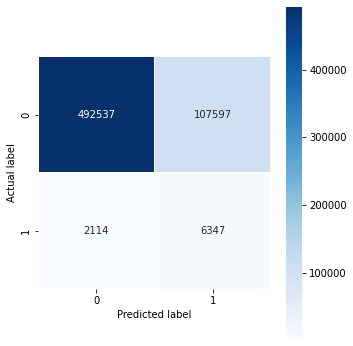

Prediction Report
               precision    recall  f1-score   support

           0       1.00      0.82      0.90    600134
           1       0.05      0.75      0.10      8461

    accuracy                           0.81    608595
   macro avg       0.52      0.78      0.50    608595
weighted avg       0.98      0.81      0.89    608595



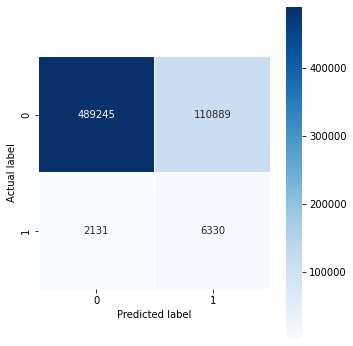

Prediction Report
               precision    recall  f1-score   support

           0       1.00      0.81      0.89    600134
           1       0.05      0.75      0.10      8461

    accuracy                           0.81    608595
   macro avg       0.52      0.78      0.50    608595
weighted avg       0.98      0.81      0.88    608595



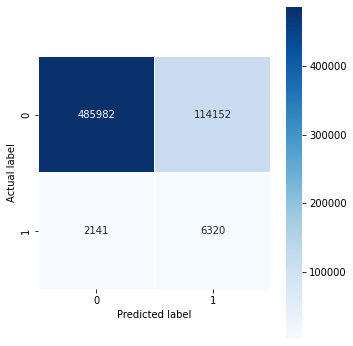

Prediction Report
               precision    recall  f1-score   support

           0       1.00      0.80      0.89    600134
           1       0.05      0.75      0.10      8461

    accuracy                           0.80    608595
   macro avg       0.52      0.78      0.49    608595
weighted avg       0.98      0.80      0.88    608595



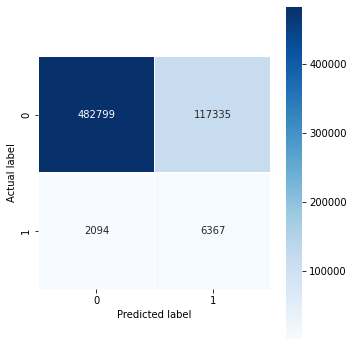

In [20]:
acc = []
precision = []                                         
recall = []
f1 = []

for select_num in range(1,7):
    
    # define the features based on different t+n
    shrink_features_list = []
    for feature in selected_features_list_removing_correlation:
        for i in range(select_num,11):
            col_title = f'{feature}_minus_{500*i}ms'
            shrink_features_list.append(col_title)
            
    # define new dataset       
    x_train_new = df_train_shuffled[shrink_features_list]
    x_test_new = df_test_shuffled[shrink_features_list]
    y_train_new = df_train_shuffled[['lossOrNot']]
    y_train_new = y_train_new.astype(int)
    y_test_new = df_test_shuffled[['lossOrNot']]
    y_test_new = y_test_new.astype(int)
    
    # define and train the model
    my_xgb_model_check = xgb.XGBRegressor(
        learning_rate = 0.138291641997073,
        gamma = 0.11468025232756118,
        max_depth = 5, 
        subsample = 0.7303257684188209,
        colsample_bytree = 0.8397581183840505,
        reg_lambda = 10,
        reg_alpha = 38,
        scale_pos_weight = 77.9123364143053,
        n_estimators = 300,
        n_jobs = 48, 
        objective = 'binary:logistic',
        random_state = 0
    )
#     my_xgb_model_check.fit(x_train_new, y_train_new, early_stopping_rounds=10, eval_metric='aucpr', eval_set=[(x_test_new, y_test_new)])
    my_xgb_model_check.fit(x_train_new, y_train_new)
    
    # show results
    y_pred = my_xgb_model_check.predict(x_test_new)
    y_pred_label = [0 if x<0.5 else 1 for x in y_pred]
    print("Prediction Report\n", classification_report(y_test_new, y_pred_label))
    cm = confusion_matrix(y_test_new, y_pred_label)
    plt.figure(figsize=(5,5))
    sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
    # store the result
    report = classification_report(y_test_new, y_pred_label, output_dict=True)
    acc.append(report['accuracy'])
    precision.append(report['macro avg']['precision'])                                  
    recall.append(report['macro avg']['recall'])
    f1.append(report['macro avg']['f1-score'])

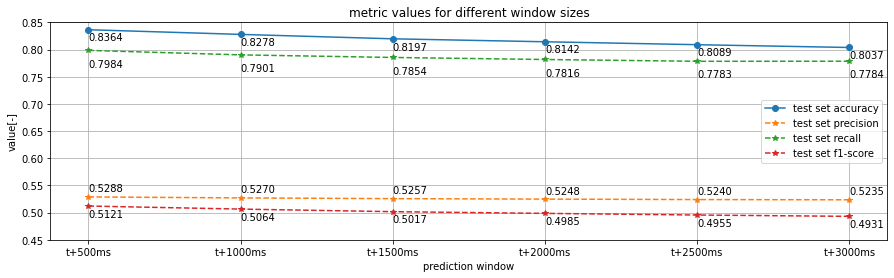

In [23]:
label = [f't+{500*x}ms' for x in range(1, 7)]

plt.figure(figsize=(15,4))
plt.ylim(0,1)
plt.plot(label, acc, 'o-', label='test set accuracy')
plt.plot(label, precision, '*--', label='test set precision')
plt.plot(label, recall, '*--', label='test set recall')
plt.plot(label, f1, '*--', label='test set f1-score')
plt.legend()
plt.xlabel('prediction window')
plt.ylabel('value[-]')
plt.title('metric values for different window sizes')
plt.ylim([0.45, 0.85])
plt.grid()

for i, txt in enumerate(acc):
    plt.annotate(str(txt)[0:6], (label[i], acc[i]-0.02))
for i, txt in enumerate(precision):
    plt.annotate(str(txt)[0:6], (label[i], precision[i]+0.01))
for i, txt in enumerate(recall):
    plt.annotate(str(txt)[0:6], (label[i], recall[i]-0.03))
for i, txt in enumerate(f1):
    plt.annotate(str(txt)[0:6], (label[i], f1[i]-0.02))
    
plt.show()

#### check behaviour in real case scenario of shuffling flows

In [24]:
complete_list = ['timestamp', 'lossOrNot', 'flow_id', 'num_packet_loss']
selected_features_list_removing_correlation = [
    'interarrival_std',
    'interarrival_min',
    'interarrival_max',
    'interarrival_skew',
    'interarrival_moment4',
    'interarrival_max_min_R',
    'interarrival_max_value_count_percent',
    'len_udp_moment4',
    'len_udp_max_min_diff',
    'len_udp_max_value_count_percent',
    'inter_time_sequence_std'
]
complete_list.extend(selected_features_list_removing_correlation)

full_features_list = []
for feature in selected_features_list_removing_correlation:
    for i in range(1,11):
        col_title = f'{feature}_minus_{500*i}ms'
        full_features_list.append(col_title)

In [25]:
df_complete_with_features_final = pd.read_csv('models/df_final_label_feature_modified.csv')
df_complete_with_features_final

timestamp  lossOrNot  flow_id  num_packet_loss  \
0        2020-12-14 13:34:44.500000        0.0      1.0              0.0   
1               2020-12-14 13:34:45        0.0      1.0              0.0   
2        2020-12-14 13:34:45.500000        0.0      1.0              0.0   
3               2020-12-14 13:34:46        0.0      1.0              0.0   
4        2020-12-14 13:34:46.500000        0.0      1.0              0.0   
...                             ...        ...      ...              ...   
2028655     2020-05-13 14:59:09.000        0.0   2881.0              0.0   
2028656     2020-05-13 14:59:09.500        0.0   2881.0              0.0   
2028657     2020-05-13 14:59:10.000        0.0   2881.0              0.0   
2028658     2020-05-13 14:59:10.500        0.0   2881.0              0.0   
2028659     2020-05-13 14:59:11.000        0.0   2881.0              0.0   

         interarrival_std_minus_500ms  interarrival_std_minus_1000ms  \
0                            0.185914                       0.111167   
1                            0.169699                       0.185914   
2                            0.122365                       0.169699   
3                            0.081800                       0.122365   
4                            0.113890                       0.081800   
...                               ...                            ...   
2028655                      0.083744                       0.075046   
2028656                      0.083497                       0.083744   
2028657                      0.048801                       0.083497   
2028658                      0.133611                       0.048801   
2028659                      0.098195                       0.133611   

         interarrival_std_minus_1500ms  interarrival_std_minus_2000ms  \
0                             0.149341                       0.168203   
1                             0.111167                       0.149341   
2                             0.185914                       0.111167   
3                             0.169699                       0.185914   
4                             0.122365                       0.169699   
...                                ...                            ...   
2028655                       0.078230                       0.131936   
2028656                       0.075046                       0.078230   
2028657                       0.083744                       0.075046   
2028658                       0.083497                       0.083744   
2028659                       0.048801                       0.083497   

         interarrival_std_minus_2500ms  interarrival_std_minus_3000ms  ...  \
0                             0.224819                       0.287330  ...   
1                             0.168203                       0.224819  ...   
2                             0.149341                       0.168203  ...   
3                             0.111167                       0.149341  ...   
4                             0.185914                       0.111167  ...   
...                                ...                            ...  ...   
2028655                       0.078184                       0.058745  ...   
2028656                       0.131936                       0.078184  ...   
2028657                       0.078230                       0.131936  ...   
2028658                       0.075046                       0.078230  ...   
2028659                       0.083744                       0.075046  ...   

         inter_time_sequence_std_minus_500ms  \
0                                   0.362588   
1                                   0.204396   
2                                   0.336296   
3                                   0.438010   
4                                   0.210085   
...                                      ...   
2028655                             0.213018   
2028656                             0.213018   
20

In [26]:
df_loss = df_complete_with_features_final[df_complete_with_features_final['lossOrNot'] > 0]
df_no_loss = df_complete_with_features_final[df_complete_with_features_final['lossOrNot'] < 1]
flow_id_loss = df_loss['flow_id'].drop_duplicates().tolist()
flow_id_no_loss = df_no_loss['flow_id'].drop_duplicates().tolist()

[0]	validation_0-aucpr:0.019112
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.019149
[2]	validation_0-aucpr:0.018903
[3]	validation_0-aucpr:0.017976
[4]	validation_0-aucpr:0.018294
[5]	validation_0-aucpr:0.01824
[6]	validation_0-aucpr:0.017826
[7]	validation_0-aucpr:0.017776
[8]	validation_0-aucpr:0.01705
[9]	validation_0-aucpr:0.017155
[10]	validation_0-aucpr:0.01746
[11]	validation_0-aucpr:0.017279
Stopping. Best iteration:
[1]	validation_0-aucpr:0.019149

Prediction Report of trial 1
               precision    recall  f1-score   support

           0       0.99      0.52      0.68    600134
           1       0.02      0.60      0.03      8461

    accuracy                           0.52    608595
   macro avg       0.50      0.56      0.36    608595
weighted avg       0.98      0.52      0.67    608595



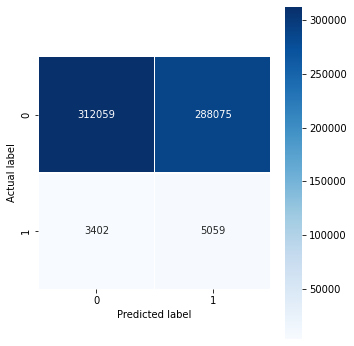

[0]	validation_0-aucpr:0.01348
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.014223
[2]	validation_0-aucpr:0.014516
[3]	validation_0-aucpr:0.015801
[4]	validation_0-aucpr:0.015767
[5]	validation_0-aucpr:0.016214
[6]	validation_0-aucpr:0.016306
[7]	validation_0-aucpr:0.016851
[8]	validation_0-aucpr:0.016474
[9]	validation_0-aucpr:0.01653
[10]	validation_0-aucpr:0.016741
[11]	validation_0-aucpr:0.01663
[12]	validation_0-aucpr:0.016904
[13]	validation_0-aucpr:0.016812
[14]	validation_0-aucpr:0.016652
[15]	validation_0-aucpr:0.01687
[16]	validation_0-aucpr:0.016737
[17]	validation_0-aucpr:0.016666
[18]	validation_0-aucpr:0.016338
[19]	validation_0-aucpr:0.016501
[20]	validation_0-aucpr:0.016513
[21]	validation_0-aucpr:0.016705
[22]	validation_0-aucpr:0.016451
Stopping. Best iteration:
[12]	validation_0-aucpr:0.016904

Prediction Report of trial 2
               precision    recall  f1-score   support

           0       0.99      0.63      0.77 

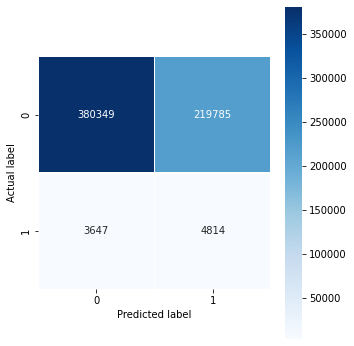

[0]	validation_0-aucpr:0.017801
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.017979
[2]	validation_0-aucpr:0.019982
[3]	validation_0-aucpr:0.018176
[4]	validation_0-aucpr:0.019415
[5]	validation_0-aucpr:0.021004
[6]	validation_0-aucpr:0.02095
[7]	validation_0-aucpr:0.021216
[8]	validation_0-aucpr:0.021116
[9]	validation_0-aucpr:0.022229
[10]	validation_0-aucpr:0.02206
[11]	validation_0-aucpr:0.021987
[12]	validation_0-aucpr:0.022034
[13]	validation_0-aucpr:0.022436
[14]	validation_0-aucpr:0.023196
[15]	validation_0-aucpr:0.02356
[16]	validation_0-aucpr:0.024181
[17]	validation_0-aucpr:0.024923
[18]	validation_0-aucpr:0.024982
[19]	validation_0-aucpr:0.025566
[20]	validation_0-aucpr:0.025521
[21]	validation_0-aucpr:0.02547
[22]	validation_0-aucpr:0.025424
[23]	validation_0-aucpr:0.024767
[24]	validation_0-aucpr:0.025321
[25]	validation_0-aucpr:0.025407
[26]	validation_0-aucpr:0.024946
[27]	validation_0-aucpr:0.025072
[28]	validation_0-aucpr:

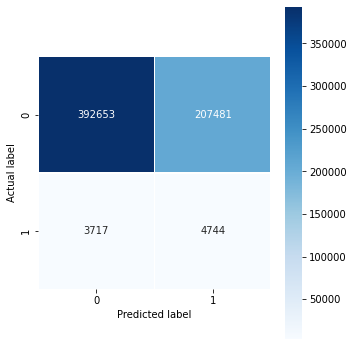

[0]	validation_0-aucpr:0.018477
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.019509
[2]	validation_0-aucpr:0.020118
[3]	validation_0-aucpr:0.021161
[4]	validation_0-aucpr:0.021073
[5]	validation_0-aucpr:0.021024
[6]	validation_0-aucpr:0.020648
[7]	validation_0-aucpr:0.020326
[8]	validation_0-aucpr:0.020331
[9]	validation_0-aucpr:0.020519
[10]	validation_0-aucpr:0.021075
[11]	validation_0-aucpr:0.021405
[12]	validation_0-aucpr:0.020658
[13]	validation_0-aucpr:0.021326
[14]	validation_0-aucpr:0.021097
[15]	validation_0-aucpr:0.021221
[16]	validation_0-aucpr:0.021567
[17]	validation_0-aucpr:0.022131
[18]	validation_0-aucpr:0.022458
[19]	validation_0-aucpr:0.022714
[20]	validation_0-aucpr:0.022687
[21]	validation_0-aucpr:0.022298
[22]	validation_0-aucpr:0.022629
[23]	validation_0-aucpr:0.022808
[24]	validation_0-aucpr:0.023162
[25]	validation_0-aucpr:0.02341
[26]	validation_0-aucpr:0.023206
[27]	validation_0-aucpr:0.02373
[28]	validation_0-aucp

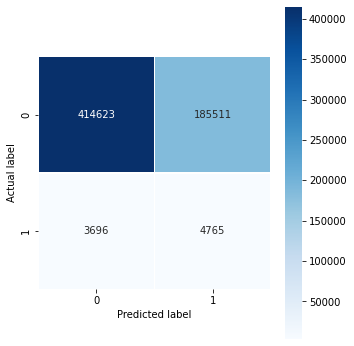

[0]	validation_0-aucpr:0.016621
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.016584
[2]	validation_0-aucpr:0.017162
[3]	validation_0-aucpr:0.01698
[4]	validation_0-aucpr:0.017102
[5]	validation_0-aucpr:0.016781
[6]	validation_0-aucpr:0.016907
[7]	validation_0-aucpr:0.016475
[8]	validation_0-aucpr:0.01679
[9]	validation_0-aucpr:0.016689
[10]	validation_0-aucpr:0.016707
[11]	validation_0-aucpr:0.016861
[12]	validation_0-aucpr:0.017156
Stopping. Best iteration:
[2]	validation_0-aucpr:0.017162

Prediction Report of trial 5
               precision    recall  f1-score   support

           0       0.99      0.61      0.75    600134
           1       0.02      0.50      0.03      8461

    accuracy                           0.60    608595
   macro avg       0.50      0.55      0.39    608595
weighted avg       0.97      0.60      0.74    608595



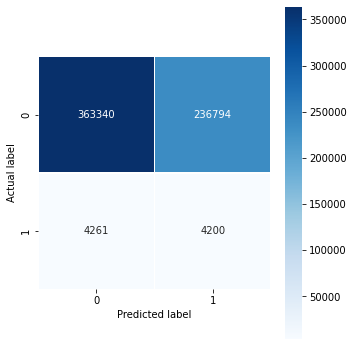

[0]	validation_0-aucpr:0.016424
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.015783
[2]	validation_0-aucpr:0.016219
[3]	validation_0-aucpr:0.015595
[4]	validation_0-aucpr:0.01619
[5]	validation_0-aucpr:0.015861
[6]	validation_0-aucpr:0.016162
[7]	validation_0-aucpr:0.016087
[8]	validation_0-aucpr:0.016219
[9]	validation_0-aucpr:0.016547
[10]	validation_0-aucpr:0.016482
[11]	validation_0-aucpr:0.016697
[12]	validation_0-aucpr:0.016901
[13]	validation_0-aucpr:0.016991
[14]	validation_0-aucpr:0.016956
[15]	validation_0-aucpr:0.017038
[16]	validation_0-aucpr:0.017277
[17]	validation_0-aucpr:0.017217
[18]	validation_0-aucpr:0.017185
[19]	validation_0-aucpr:0.017179
[20]	validation_0-aucpr:0.017124
[21]	validation_0-aucpr:0.017178
[22]	validation_0-aucpr:0.017235
[23]	validation_0-aucpr:0.017265
[24]	validation_0-aucpr:0.017676
[25]	validation_0-aucpr:0.017622
[26]	validation_0-aucpr:0.01768
[27]	validation_0-aucpr:0.017841
[28]	validation_0-aucp

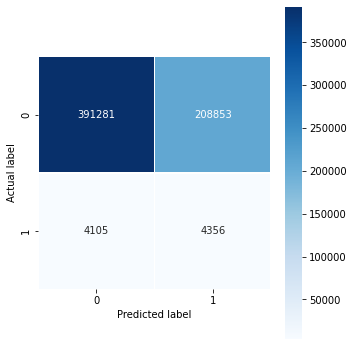

[0]	validation_0-aucpr:0.014401
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.014473
[2]	validation_0-aucpr:0.01462
[3]	validation_0-aucpr:0.015018
[4]	validation_0-aucpr:0.014914
[5]	validation_0-aucpr:0.014725
[6]	validation_0-aucpr:0.014802
[7]	validation_0-aucpr:0.014697
[8]	validation_0-aucpr:0.014818
[9]	validation_0-aucpr:0.015044
[10]	validation_0-aucpr:0.015092
[11]	validation_0-aucpr:0.015009
[12]	validation_0-aucpr:0.014985
[13]	validation_0-aucpr:0.015151
[14]	validation_0-aucpr:0.015269
[15]	validation_0-aucpr:0.015627
[16]	validation_0-aucpr:0.015612
[17]	validation_0-aucpr:0.015836
[18]	validation_0-aucpr:0.01622
[19]	validation_0-aucpr:0.016144
[20]	validation_0-aucpr:0.016268
[21]	validation_0-aucpr:0.01624
[22]	validation_0-aucpr:0.016254
[23]	validation_0-aucpr:0.016237
[24]	validation_0-aucpr:0.016489
[25]	validation_0-aucpr:0.01684
[26]	validation_0-aucpr:0.016714
[27]	validation_0-aucpr:0.016953
[28]	validation_0-aucpr:

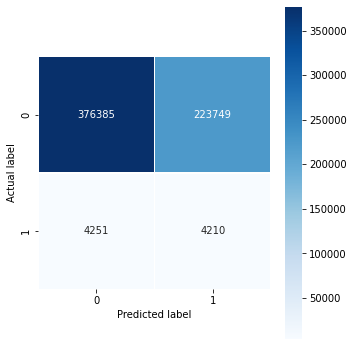

[0]	validation_0-aucpr:0.022351
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.022768
[2]	validation_0-aucpr:0.025941
[3]	validation_0-aucpr:0.024768
[4]	validation_0-aucpr:0.025972
[5]	validation_0-aucpr:0.02807
[6]	validation_0-aucpr:0.028187
[7]	validation_0-aucpr:0.032659
[8]	validation_0-aucpr:0.034392
[9]	validation_0-aucpr:0.032809
[10]	validation_0-aucpr:0.033054
[11]	validation_0-aucpr:0.032823
[12]	validation_0-aucpr:0.034711
[13]	validation_0-aucpr:0.035873
[14]	validation_0-aucpr:0.036552
[15]	validation_0-aucpr:0.038295
[16]	validation_0-aucpr:0.037948
[17]	validation_0-aucpr:0.039272
[18]	validation_0-aucpr:0.038959
[19]	validation_0-aucpr:0.038995
[20]	validation_0-aucpr:0.038463
[21]	validation_0-aucpr:0.038996
[22]	validation_0-aucpr:0.04007
[23]	validation_0-aucpr:0.039725
[24]	validation_0-aucpr:0.039793
[25]	validation_0-aucpr:0.039304
[26]	validation_0-aucpr:0.039481
[27]	validation_0-aucpr:0.038725
[28]	validation_0-aucp

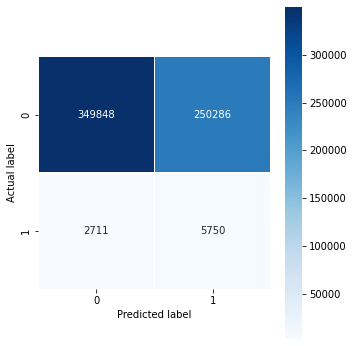

[0]	validation_0-aucpr:0.017673
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.018897
[2]	validation_0-aucpr:0.019255
[3]	validation_0-aucpr:0.018331
[4]	validation_0-aucpr:0.018026
[5]	validation_0-aucpr:0.017418
[6]	validation_0-aucpr:0.017232
[7]	validation_0-aucpr:0.017192
[8]	validation_0-aucpr:0.017683
[9]	validation_0-aucpr:0.017196
[10]	validation_0-aucpr:0.017248
[11]	validation_0-aucpr:0.017065
[12]	validation_0-aucpr:0.017048
Stopping. Best iteration:
[2]	validation_0-aucpr:0.019255

Prediction Report of trial 9
               precision    recall  f1-score   support

           0       0.99      0.51      0.67    600134
           1       0.02      0.58      0.03      8461

    accuracy                           0.51    608595
   macro avg       0.50      0.55      0.35    608595
weighted avg       0.98      0.51      0.66    608595



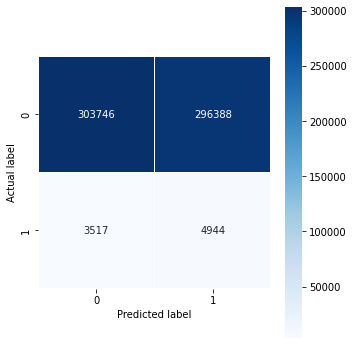

[0]	validation_0-aucpr:0.012803
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.012898
[2]	validation_0-aucpr:0.014794
[3]	validation_0-aucpr:0.014205
[4]	validation_0-aucpr:0.014969
[5]	validation_0-aucpr:0.014667
[6]	validation_0-aucpr:0.015442
[7]	validation_0-aucpr:0.015832
[8]	validation_0-aucpr:0.016288
[9]	validation_0-aucpr:0.016294
[10]	validation_0-aucpr:0.016482
[11]	validation_0-aucpr:0.016917
[12]	validation_0-aucpr:0.017137
[13]	validation_0-aucpr:0.017123
[14]	validation_0-aucpr:0.017504
[15]	validation_0-aucpr:0.018006
[16]	validation_0-aucpr:0.017988
[17]	validation_0-aucpr:0.017785
[18]	validation_0-aucpr:0.017863
[19]	validation_0-aucpr:0.017846
[20]	validation_0-aucpr:0.017889
[21]	validation_0-aucpr:0.018107
[22]	validation_0-aucpr:0.018303
[23]	validation_0-aucpr:0.018457
[24]	validation_0-aucpr:0.018447
[25]	validation_0-aucpr:0.01843
[26]	validation_0-aucpr:0.018701
[27]	validation_0-aucpr:0.018564
[28]	validation_0-auc

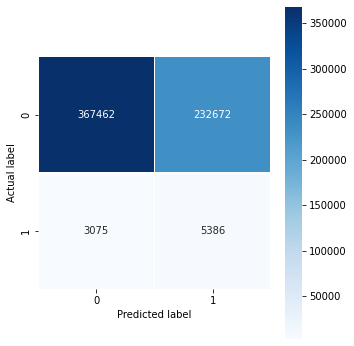

[0]	validation_0-aucpr:0.020542
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.020804
[2]	validation_0-aucpr:0.020838
[3]	validation_0-aucpr:0.021064
[4]	validation_0-aucpr:0.020951
[5]	validation_0-aucpr:0.02075
[6]	validation_0-aucpr:0.020851
[7]	validation_0-aucpr:0.020891
[8]	validation_0-aucpr:0.021038
[9]	validation_0-aucpr:0.021544
[10]	validation_0-aucpr:0.022025
[11]	validation_0-aucpr:0.02219
[12]	validation_0-aucpr:0.022172
[13]	validation_0-aucpr:0.021928
[14]	validation_0-aucpr:0.021851
[15]	validation_0-aucpr:0.021884
[16]	validation_0-aucpr:0.022371
[17]	validation_0-aucpr:0.022265
[18]	validation_0-aucpr:0.022196
[19]	validation_0-aucpr:0.022308
[20]	validation_0-aucpr:0.022273
[21]	validation_0-aucpr:0.022202
[22]	validation_0-aucpr:0.022038
[23]	validation_0-aucpr:0.021922
[24]	validation_0-aucpr:0.02183
[25]	validation_0-aucpr:0.02132
[26]	validation_0-aucpr:0.021643
Stopping. Best iteration:
[16]	validation_0-aucpr:0.02237

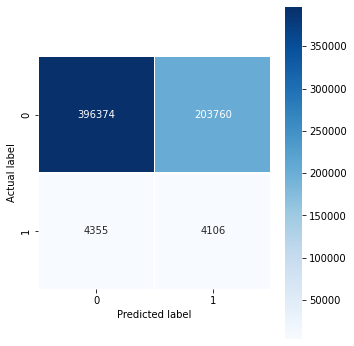

[0]	validation_0-aucpr:0.01659
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.017985
[2]	validation_0-aucpr:0.017365
[3]	validation_0-aucpr:0.018351
[4]	validation_0-aucpr:0.018539
[5]	validation_0-aucpr:0.018373
[6]	validation_0-aucpr:0.019161
[7]	validation_0-aucpr:0.019066
[8]	validation_0-aucpr:0.019116
[9]	validation_0-aucpr:0.019228
[10]	validation_0-aucpr:0.019506
[11]	validation_0-aucpr:0.019494
[12]	validation_0-aucpr:0.019732
[13]	validation_0-aucpr:0.019999
[14]	validation_0-aucpr:0.019315
[15]	validation_0-aucpr:0.019094
[16]	validation_0-aucpr:0.019377
[17]	validation_0-aucpr:0.019647
[18]	validation_0-aucpr:0.019583
[19]	validation_0-aucpr:0.020288
[20]	validation_0-aucpr:0.020283
[21]	validation_0-aucpr:0.020144
[22]	validation_0-aucpr:0.019595
[23]	validation_0-aucpr:0.019987
[24]	validation_0-aucpr:0.019579
[25]	validation_0-aucpr:0.019548
[26]	validation_0-aucpr:0.019561
[27]	validation_0-aucpr:0.019822
[28]	validation_0-auc

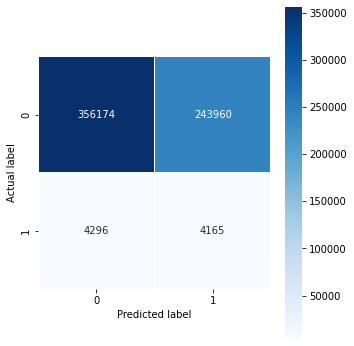

[0]	validation_0-aucpr:0.020612
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.019924
[2]	validation_0-aucpr:0.020299
[3]	validation_0-aucpr:0.021251
[4]	validation_0-aucpr:0.021477
[5]	validation_0-aucpr:0.022036
[6]	validation_0-aucpr:0.021814
[7]	validation_0-aucpr:0.021874
[8]	validation_0-aucpr:0.021925
[9]	validation_0-aucpr:0.021859
[10]	validation_0-aucpr:0.022784
[11]	validation_0-aucpr:0.022732
[12]	validation_0-aucpr:0.02268
[13]	validation_0-aucpr:0.02323
[14]	validation_0-aucpr:0.023009
[15]	validation_0-aucpr:0.023033
[16]	validation_0-aucpr:0.023341
[17]	validation_0-aucpr:0.023286
[18]	validation_0-aucpr:0.023351
[19]	validation_0-aucpr:0.023487
[20]	validation_0-aucpr:0.023723
[21]	validation_0-aucpr:0.023778
[22]	validation_0-aucpr:0.023808
[23]	validation_0-aucpr:0.024061
[24]	validation_0-aucpr:0.024609
[25]	validation_0-aucpr:0.024674
[26]	validation_0-aucpr:0.024524
[27]	validation_0-aucpr:0.024781
[28]	validation_0-aucp

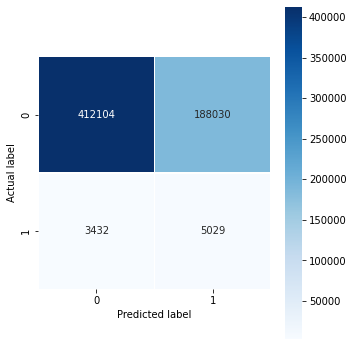

[0]	validation_0-aucpr:0.017309
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.017759
[2]	validation_0-aucpr:0.017486
[3]	validation_0-aucpr:0.017392
[4]	validation_0-aucpr:0.018509
[5]	validation_0-aucpr:0.018926
[6]	validation_0-aucpr:0.019476
[7]	validation_0-aucpr:0.02047
[8]	validation_0-aucpr:0.020632
[9]	validation_0-aucpr:0.020783
[10]	validation_0-aucpr:0.020929
[11]	validation_0-aucpr:0.021571
[12]	validation_0-aucpr:0.021837
[13]	validation_0-aucpr:0.021258
[14]	validation_0-aucpr:0.021362
[15]	validation_0-aucpr:0.020316
[16]	validation_0-aucpr:0.020802
[17]	validation_0-aucpr:0.020772
[18]	validation_0-aucpr:0.020594
[19]	validation_0-aucpr:0.020794
[20]	validation_0-aucpr:0.020822
[21]	validation_0-aucpr:0.019776
[22]	validation_0-aucpr:0.01949
Stopping. Best iteration:
[12]	validation_0-aucpr:0.021837

Prediction Report of trial 14
               precision    recall  f1-score   support

           0       0.99      0.61      0.

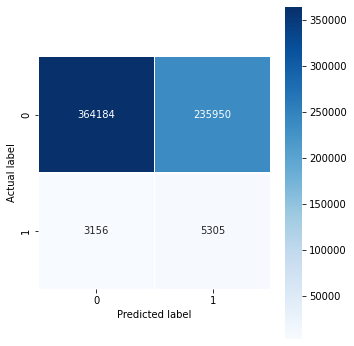

[0]	validation_0-aucpr:0.016859
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.016629
[2]	validation_0-aucpr:0.015996
[3]	validation_0-aucpr:0.016704
[4]	validation_0-aucpr:0.016299
[5]	validation_0-aucpr:0.016709
[6]	validation_0-aucpr:0.016242
[7]	validation_0-aucpr:0.016013
[8]	validation_0-aucpr:0.01632
[9]	validation_0-aucpr:0.015934
[10]	validation_0-aucpr:0.016213
Stopping. Best iteration:
[0]	validation_0-aucpr:0.016859

Prediction Report of trial 15
               precision    recall  f1-score   support

           0       0.99      0.46      0.63    600134
           1       0.02      0.63      0.03      8461

    accuracy                           0.46    608595
   macro avg       0.50      0.55      0.33    608595
weighted avg       0.98      0.46      0.62    608595



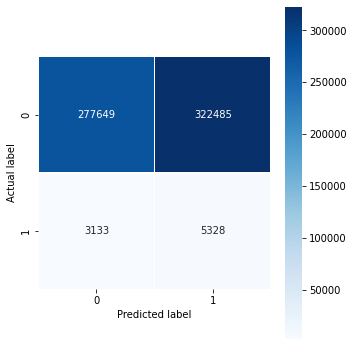

[0]	validation_0-aucpr:0.01841
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.019957
[2]	validation_0-aucpr:0.021149
[3]	validation_0-aucpr:0.021365
[4]	validation_0-aucpr:0.022718
[5]	validation_0-aucpr:0.024143
[6]	validation_0-aucpr:0.022663
[7]	validation_0-aucpr:0.023195
[8]	validation_0-aucpr:0.020887
[9]	validation_0-aucpr:0.022085
[10]	validation_0-aucpr:0.022404
[11]	validation_0-aucpr:0.020866
[12]	validation_0-aucpr:0.021164
[13]	validation_0-aucpr:0.02053
[14]	validation_0-aucpr:0.021761
[15]	validation_0-aucpr:0.021725
Stopping. Best iteration:
[5]	validation_0-aucpr:0.024143

Prediction Report of trial 16
               precision    recall  f1-score   support

           0       0.99      0.45      0.62    600134
           1       0.02      0.72      0.04      8461

    accuracy                           0.46    608595
   macro avg       0.50      0.59      0.33    608595
weighted avg       0.98      0.46      0.61    608595



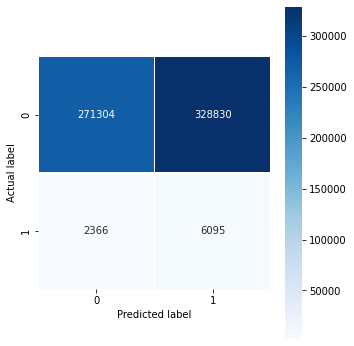

[0]	validation_0-aucpr:0.01243
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.013145
[2]	validation_0-aucpr:0.013237
[3]	validation_0-aucpr:0.012984
[4]	validation_0-aucpr:0.012889
[5]	validation_0-aucpr:0.012763
[6]	validation_0-aucpr:0.012578
[7]	validation_0-aucpr:0.012682
[8]	validation_0-aucpr:0.012566
[9]	validation_0-aucpr:0.012427
[10]	validation_0-aucpr:0.012244
[11]	validation_0-aucpr:0.012203
[12]	validation_0-aucpr:0.012192
Stopping. Best iteration:
[2]	validation_0-aucpr:0.013237

Prediction Report of trial 17
               precision    recall  f1-score   support

           0       0.98      0.58      0.73    600134
           1       0.01      0.32      0.02      8461

    accuracy                           0.57    608595
   macro avg       0.50      0.45      0.37    608595
weighted avg       0.97      0.57      0.72    608595



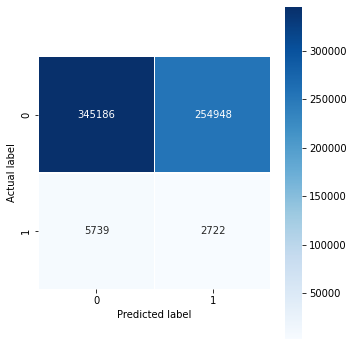

[0]	validation_0-aucpr:0.017648
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.015243
[2]	validation_0-aucpr:0.015366
[3]	validation_0-aucpr:0.015449
[4]	validation_0-aucpr:0.015572
[5]	validation_0-aucpr:0.015744
[6]	validation_0-aucpr:0.016417
[7]	validation_0-aucpr:0.016713
[8]	validation_0-aucpr:0.016761
[9]	validation_0-aucpr:0.016589
[10]	validation_0-aucpr:0.016249
Stopping. Best iteration:
[0]	validation_0-aucpr:0.017648

Prediction Report of trial 18
               precision    recall  f1-score   support

           0       0.99      0.58      0.73    600134
           1       0.02      0.51      0.03      8461

    accuracy                           0.58    608595
   macro avg       0.50      0.54      0.38    608595
weighted avg       0.97      0.58      0.72    608595



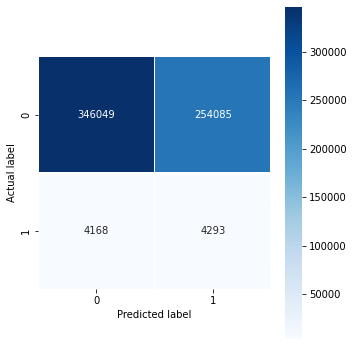

[0]	validation_0-aucpr:0.01819
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.019863
[2]	validation_0-aucpr:0.021944
[3]	validation_0-aucpr:0.022427
[4]	validation_0-aucpr:0.021954
[5]	validation_0-aucpr:0.022483
[6]	validation_0-aucpr:0.022074
[7]	validation_0-aucpr:0.021058
[8]	validation_0-aucpr:0.021095
[9]	validation_0-aucpr:0.020526
[10]	validation_0-aucpr:0.020054
[11]	validation_0-aucpr:0.02071
[12]	validation_0-aucpr:0.020673
[13]	validation_0-aucpr:0.020337
[14]	validation_0-aucpr:0.02027
[15]	validation_0-aucpr:0.019884
Stopping. Best iteration:
[5]	validation_0-aucpr:0.022483

Prediction Report of trial 19
               precision    recall  f1-score   support

           0       0.99      0.56      0.72    600134
           1       0.02      0.56      0.03      8461

    accuracy                           0.56    608595
   macro avg       0.50      0.56      0.38    608595
weighted avg       0.98      0.56      0.71    608595



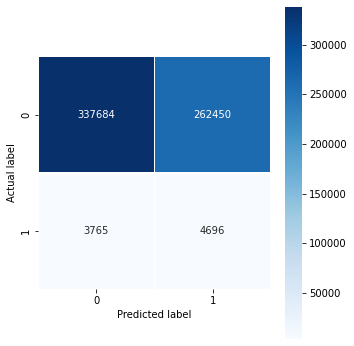

[0]	validation_0-aucpr:0.020541
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.02232
[2]	validation_0-aucpr:0.021529
[3]	validation_0-aucpr:0.021183
[4]	validation_0-aucpr:0.019547
[5]	validation_0-aucpr:0.019428
[6]	validation_0-aucpr:0.020958
[7]	validation_0-aucpr:0.02119
[8]	validation_0-aucpr:0.022284
[9]	validation_0-aucpr:0.021661
[10]	validation_0-aucpr:0.021777
[11]	validation_0-aucpr:0.02261
[12]	validation_0-aucpr:0.022544
[13]	validation_0-aucpr:0.022445
[14]	validation_0-aucpr:0.021968
[15]	validation_0-aucpr:0.022152
[16]	validation_0-aucpr:0.022305
[17]	validation_0-aucpr:0.022648
[18]	validation_0-aucpr:0.022579
[19]	validation_0-aucpr:0.022089
[20]	validation_0-aucpr:0.022066
[21]	validation_0-aucpr:0.021953
[22]	validation_0-aucpr:0.021894
[23]	validation_0-aucpr:0.021861
[24]	validation_0-aucpr:0.02178
[25]	validation_0-aucpr:0.021647
[26]	validation_0-aucpr:0.02173
[27]	validation_0-aucpr:0.021686
Stopping. Best iteration:

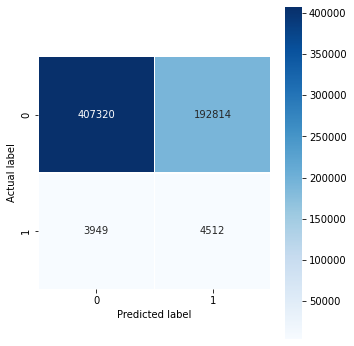

[0]	validation_0-aucpr:0.017125
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.017314
[2]	validation_0-aucpr:0.017616
[3]	validation_0-aucpr:0.01756
[4]	validation_0-aucpr:0.017744
[5]	validation_0-aucpr:0.018137
[6]	validation_0-aucpr:0.017829
[7]	validation_0-aucpr:0.018494
[8]	validation_0-aucpr:0.018281
[9]	validation_0-aucpr:0.018538
[10]	validation_0-aucpr:0.018539
[11]	validation_0-aucpr:0.018612
[12]	validation_0-aucpr:0.018585
[13]	validation_0-aucpr:0.018952
[14]	validation_0-aucpr:0.018982
[15]	validation_0-aucpr:0.018964
[16]	validation_0-aucpr:0.019298
[17]	validation_0-aucpr:0.019119
[18]	validation_0-aucpr:0.019469
[19]	validation_0-aucpr:0.019611
[20]	validation_0-aucpr:0.019744
[21]	validation_0-aucpr:0.020026
[22]	validation_0-aucpr:0.020015
[23]	validation_0-aucpr:0.020055
[24]	validation_0-aucpr:0.020004
[25]	validation_0-aucpr:0.020036
[26]	validation_0-aucpr:0.020151
[27]	validation_0-aucpr:0.020065
[28]	validation_0-auc

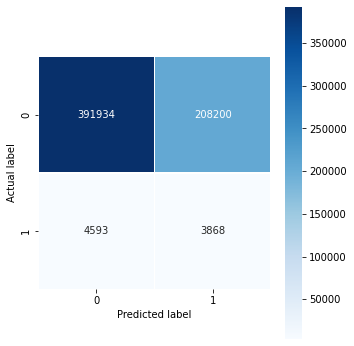

[0]	validation_0-aucpr:0.01576
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.015345
[2]	validation_0-aucpr:0.015015
[3]	validation_0-aucpr:0.015232
[4]	validation_0-aucpr:0.015646
[5]	validation_0-aucpr:0.015857
[6]	validation_0-aucpr:0.015593
[7]	validation_0-aucpr:0.015739
[8]	validation_0-aucpr:0.015892
[9]	validation_0-aucpr:0.015728
[10]	validation_0-aucpr:0.016267
[11]	validation_0-aucpr:0.016198
[12]	validation_0-aucpr:0.016026
[13]	validation_0-aucpr:0.016126
[14]	validation_0-aucpr:0.016089
[15]	validation_0-aucpr:0.01629
[16]	validation_0-aucpr:0.01656
[17]	validation_0-aucpr:0.016723
[18]	validation_0-aucpr:0.016746
[19]	validation_0-aucpr:0.016603
[20]	validation_0-aucpr:0.016775
[21]	validation_0-aucpr:0.017189
[22]	validation_0-aucpr:0.017288
[23]	validation_0-aucpr:0.017129
[24]	validation_0-aucpr:0.017071
[25]	validation_0-aucpr:0.017107
[26]	validation_0-aucpr:0.01728
[27]	validation_0-aucpr:0.017386
[28]	validation_0-aucpr:

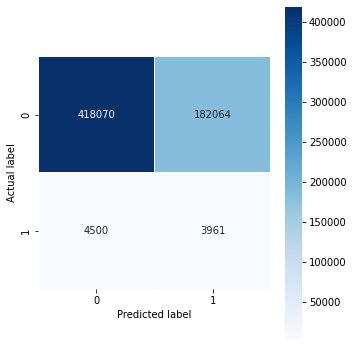

[0]	validation_0-aucpr:0.014098
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.015634
[2]	validation_0-aucpr:0.014577
[3]	validation_0-aucpr:0.014339
[4]	validation_0-aucpr:0.014464
[5]	validation_0-aucpr:0.014425
[6]	validation_0-aucpr:0.014701
[7]	validation_0-aucpr:0.014978
[8]	validation_0-aucpr:0.015161
[9]	validation_0-aucpr:0.015009
[10]	validation_0-aucpr:0.015052
[11]	validation_0-aucpr:0.015207
Stopping. Best iteration:
[1]	validation_0-aucpr:0.015634

Prediction Report of trial 23
               precision    recall  f1-score   support

           0       0.99      0.57      0.73    600134
           1       0.02      0.50      0.03      8461

    accuracy                           0.57    608595
   macro avg       0.50      0.53      0.38    608595
weighted avg       0.97      0.57      0.72    608595



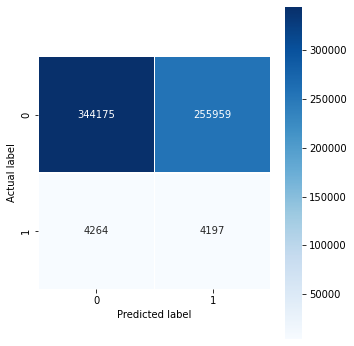

[0]	validation_0-aucpr:0.017149
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.017096
[2]	validation_0-aucpr:0.01807
[3]	validation_0-aucpr:0.01763
[4]	validation_0-aucpr:0.016836
[5]	validation_0-aucpr:0.018498
[6]	validation_0-aucpr:0.018103
[7]	validation_0-aucpr:0.018642
[8]	validation_0-aucpr:0.018569
[9]	validation_0-aucpr:0.018716
[10]	validation_0-aucpr:0.018551
[11]	validation_0-aucpr:0.018486
[12]	validation_0-aucpr:0.018349
[13]	validation_0-aucpr:0.018234
[14]	validation_0-aucpr:0.018726
[15]	validation_0-aucpr:0.018973
[16]	validation_0-aucpr:0.018766
[17]	validation_0-aucpr:0.019191
[18]	validation_0-aucpr:0.019458
[19]	validation_0-aucpr:0.019567
[20]	validation_0-aucpr:0.019531
[21]	validation_0-aucpr:0.020072
[22]	validation_0-aucpr:0.020159
[23]	validation_0-aucpr:0.020765
[24]	validation_0-aucpr:0.021328
[25]	validation_0-aucpr:0.021483
[26]	validation_0-aucpr:0.021856
[27]	validation_0-aucpr:0.021806
[28]	validation_0-aucp

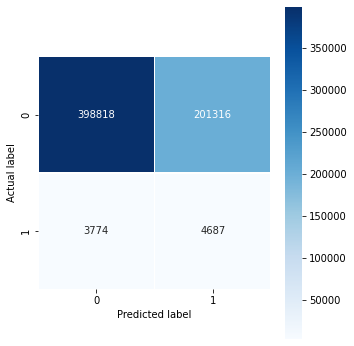

[0]	validation_0-aucpr:0.021375
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.02064
[2]	validation_0-aucpr:0.021561
[3]	validation_0-aucpr:0.022215
[4]	validation_0-aucpr:0.023606
[5]	validation_0-aucpr:0.022672
[6]	validation_0-aucpr:0.024876
[7]	validation_0-aucpr:0.024694
[8]	validation_0-aucpr:0.024442
[9]	validation_0-aucpr:0.023838
[10]	validation_0-aucpr:0.024011
[11]	validation_0-aucpr:0.024188
[12]	validation_0-aucpr:0.024229
[13]	validation_0-aucpr:0.024291
[14]	validation_0-aucpr:0.024097
[15]	validation_0-aucpr:0.024439
[16]	validation_0-aucpr:0.024359
Stopping. Best iteration:
[6]	validation_0-aucpr:0.024876

Prediction Report of trial 25
               precision    recall  f1-score   support

           0       0.99      0.55      0.71    600134
           1       0.02      0.58      0.03      8461

    accuracy                           0.55    608595
   macro avg       0.50      0.56      0.37    608595
weighted avg       0.9

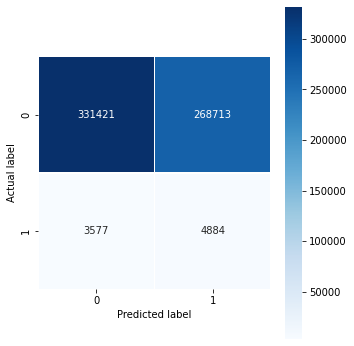

[0]	validation_0-aucpr:0.019304
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.019516
[2]	validation_0-aucpr:0.01965
[3]	validation_0-aucpr:0.019156
[4]	validation_0-aucpr:0.017889
[5]	validation_0-aucpr:0.018174
[6]	validation_0-aucpr:0.017748
[7]	validation_0-aucpr:0.017654
[8]	validation_0-aucpr:0.01724
[9]	validation_0-aucpr:0.017233
[10]	validation_0-aucpr:0.01742
[11]	validation_0-aucpr:0.017555
[12]	validation_0-aucpr:0.017664
Stopping. Best iteration:
[2]	validation_0-aucpr:0.01965

Prediction Report of trial 26
               precision    recall  f1-score   support

           0       0.99      0.55      0.71    600134
           1       0.02      0.55      0.03      8461

    accuracy                           0.55    608595
   macro avg       0.50      0.55      0.37    608595
weighted avg       0.98      0.55      0.70    608595



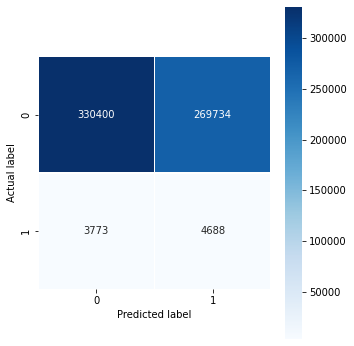

[0]	validation_0-aucpr:0.01931
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.017092
[2]	validation_0-aucpr:0.017637
[3]	validation_0-aucpr:0.017429
[4]	validation_0-aucpr:0.017877
[5]	validation_0-aucpr:0.017619
[6]	validation_0-aucpr:0.017618
[7]	validation_0-aucpr:0.017493
[8]	validation_0-aucpr:0.0177
[9]	validation_0-aucpr:0.017399
[10]	validation_0-aucpr:0.01724
Stopping. Best iteration:
[0]	validation_0-aucpr:0.01931

Prediction Report of trial 27
               precision    recall  f1-score   support

           0       0.99      0.42      0.59    600134
           1       0.02      0.73      0.03      8461

    accuracy                           0.42    608595
   macro avg       0.50      0.57      0.31    608595
weighted avg       0.98      0.42      0.58    608595



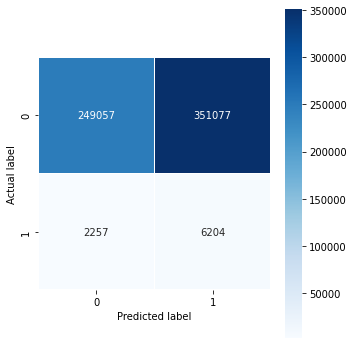

[0]	validation_0-aucpr:0.016559
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.015993
[2]	validation_0-aucpr:0.018481
[3]	validation_0-aucpr:0.018621
[4]	validation_0-aucpr:0.019502
[5]	validation_0-aucpr:0.019223
[6]	validation_0-aucpr:0.01914
[7]	validation_0-aucpr:0.019637
[8]	validation_0-aucpr:0.019058
[9]	validation_0-aucpr:0.018966
[10]	validation_0-aucpr:0.018843
[11]	validation_0-aucpr:0.0192
[12]	validation_0-aucpr:0.019414
[13]	validation_0-aucpr:0.02078
[14]	validation_0-aucpr:0.021219
[15]	validation_0-aucpr:0.020908
[16]	validation_0-aucpr:0.021435
[17]	validation_0-aucpr:0.021195
[18]	validation_0-aucpr:0.021377
[19]	validation_0-aucpr:0.021764
[20]	validation_0-aucpr:0.022
[21]	validation_0-aucpr:0.021992
[22]	validation_0-aucpr:0.022326
[23]	validation_0-aucpr:0.022145
[24]	validation_0-aucpr:0.022129
[25]	validation_0-aucpr:0.02272
[26]	validation_0-aucpr:0.022626
[27]	validation_0-aucpr:0.021849
[28]	validation_0-aucpr:0.02

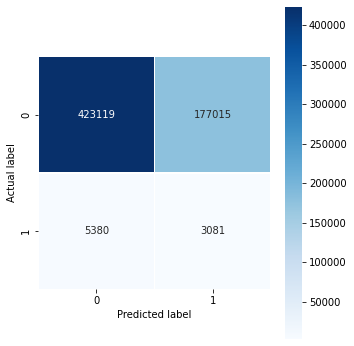

[0]	validation_0-aucpr:0.016641
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.016883
[2]	validation_0-aucpr:0.017473
[3]	validation_0-aucpr:0.018316
[4]	validation_0-aucpr:0.017427
[5]	validation_0-aucpr:0.017376
[6]	validation_0-aucpr:0.018088
[7]	validation_0-aucpr:0.017753
[8]	validation_0-aucpr:0.01811
[9]	validation_0-aucpr:0.018099
[10]	validation_0-aucpr:0.018549
[11]	validation_0-aucpr:0.019217
[12]	validation_0-aucpr:0.0193
[13]	validation_0-aucpr:0.019691
[14]	validation_0-aucpr:0.019801
[15]	validation_0-aucpr:0.01969
[16]	validation_0-aucpr:0.019491
[17]	validation_0-aucpr:0.019402
[18]	validation_0-aucpr:0.019865
[19]	validation_0-aucpr:0.02015
[20]	validation_0-aucpr:0.020281
[21]	validation_0-aucpr:0.020399
[22]	validation_0-aucpr:0.020061
[23]	validation_0-aucpr:0.020097
[24]	validation_0-aucpr:0.020213
[25]	validation_0-aucpr:0.019919
[26]	validation_0-aucpr:0.020004
[27]	validation_0-aucpr:0.02
[28]	validation_0-aucpr:0.019

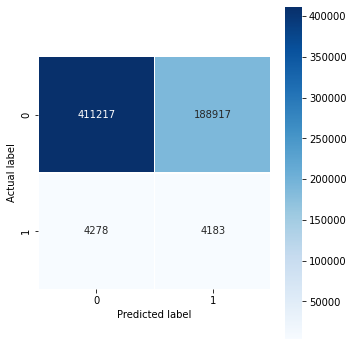

[0]	validation_0-aucpr:0.02267
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.024629
[2]	validation_0-aucpr:0.024308
[3]	validation_0-aucpr:0.024642
[4]	validation_0-aucpr:0.024449
[5]	validation_0-aucpr:0.027717
[6]	validation_0-aucpr:0.028244
[7]	validation_0-aucpr:0.028248
[8]	validation_0-aucpr:0.02813
[9]	validation_0-aucpr:0.027604
[10]	validation_0-aucpr:0.027466
[11]	validation_0-aucpr:0.027555
[12]	validation_0-aucpr:0.027274
[13]	validation_0-aucpr:0.028465
[14]	validation_0-aucpr:0.029946
[15]	validation_0-aucpr:0.029628
[16]	validation_0-aucpr:0.030138
[17]	validation_0-aucpr:0.029258
[18]	validation_0-aucpr:0.030153
[19]	validation_0-aucpr:0.031621
[20]	validation_0-aucpr:0.032471
[21]	validation_0-aucpr:0.031661
[22]	validation_0-aucpr:0.033101
[23]	validation_0-aucpr:0.034172
[24]	validation_0-aucpr:0.035204
[25]	validation_0-aucpr:0.035788
[26]	validation_0-aucpr:0.035384
[27]	validation_0-aucpr:0.035304
[28]	validation_0-aucp

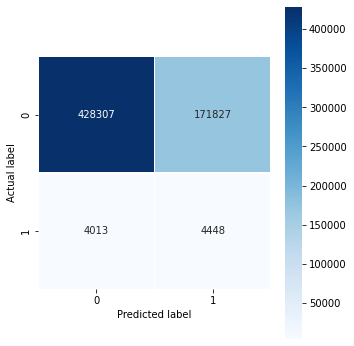

[0]	validation_0-aucpr:0.017053
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.016911
[2]	validation_0-aucpr:0.017857
[3]	validation_0-aucpr:0.017606
[4]	validation_0-aucpr:0.017908
[5]	validation_0-aucpr:0.018027
[6]	validation_0-aucpr:0.018115
[7]	validation_0-aucpr:0.018043
[8]	validation_0-aucpr:0.017973
[9]	validation_0-aucpr:0.018053
[10]	validation_0-aucpr:0.01776
[11]	validation_0-aucpr:0.017804
[12]	validation_0-aucpr:0.018409
[13]	validation_0-aucpr:0.018488
[14]	validation_0-aucpr:0.018583
[15]	validation_0-aucpr:0.018935
[16]	validation_0-aucpr:0.018889
[17]	validation_0-aucpr:0.019136
[18]	validation_0-aucpr:0.019168
[19]	validation_0-aucpr:0.019181
[20]	validation_0-aucpr:0.019312
[21]	validation_0-aucpr:0.019433
[22]	validation_0-aucpr:0.019762
[23]	validation_0-aucpr:0.019919
[24]	validation_0-aucpr:0.019786
[25]	validation_0-aucpr:0.019585
[26]	validation_0-aucpr:0.019604
[27]	validation_0-aucpr:0.019442
[28]	validation_0-auc

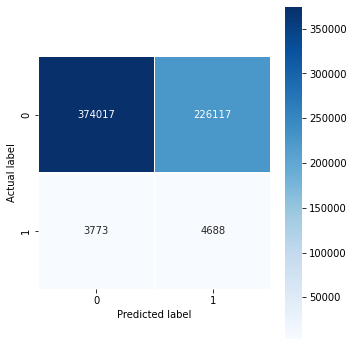

[0]	validation_0-aucpr:0.017572
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.016165
[2]	validation_0-aucpr:0.016166
[3]	validation_0-aucpr:0.016355
[4]	validation_0-aucpr:0.01623
[5]	validation_0-aucpr:0.016164
[6]	validation_0-aucpr:0.01653
[7]	validation_0-aucpr:0.016372
[8]	validation_0-aucpr:0.016376
[9]	validation_0-aucpr:0.016264
[10]	validation_0-aucpr:0.016181
Stopping. Best iteration:
[0]	validation_0-aucpr:0.017572

Prediction Report of trial 32
               precision    recall  f1-score   support

           0       0.99      0.65      0.79    600134
           1       0.02      0.44      0.03      8461

    accuracy                           0.65    608595
   macro avg       0.50      0.55      0.41    608595
weighted avg       0.97      0.65      0.78    608595



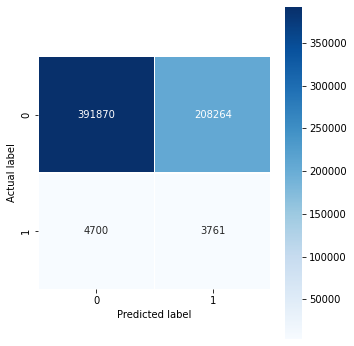

[0]	validation_0-aucpr:0.015313
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.0153
[2]	validation_0-aucpr:0.01751
[3]	validation_0-aucpr:0.017344
[4]	validation_0-aucpr:0.017409
[5]	validation_0-aucpr:0.018296
[6]	validation_0-aucpr:0.018926
[7]	validation_0-aucpr:0.018989
[8]	validation_0-aucpr:0.01816
[9]	validation_0-aucpr:0.017059
[10]	validation_0-aucpr:0.017393
[11]	validation_0-aucpr:0.017239
[12]	validation_0-aucpr:0.018054
[13]	validation_0-aucpr:0.0177
[14]	validation_0-aucpr:0.017984
[15]	validation_0-aucpr:0.018692
[16]	validation_0-aucpr:0.018715
[17]	validation_0-aucpr:0.019703
[18]	validation_0-aucpr:0.019503
[19]	validation_0-aucpr:0.020216
[20]	validation_0-aucpr:0.020421
[21]	validation_0-aucpr:0.02041
[22]	validation_0-aucpr:0.021265
[23]	validation_0-aucpr:0.021025
[24]	validation_0-aucpr:0.021639
[25]	validation_0-aucpr:0.021769
[26]	validation_0-aucpr:0.021458
[27]	validation_0-aucpr:0.02204
[28]	validation_0-aucpr:0.02

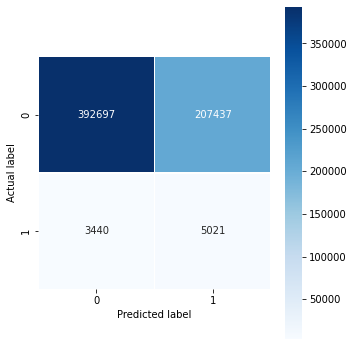

[0]	validation_0-aucpr:0.022311
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.022103
[2]	validation_0-aucpr:0.021486
[3]	validation_0-aucpr:0.02138
[4]	validation_0-aucpr:0.024201
[5]	validation_0-aucpr:0.022939
[6]	validation_0-aucpr:0.020945
[7]	validation_0-aucpr:0.021394
[8]	validation_0-aucpr:0.020839
[9]	validation_0-aucpr:0.021475
[10]	validation_0-aucpr:0.021039
[11]	validation_0-aucpr:0.021929
[12]	validation_0-aucpr:0.022571
[13]	validation_0-aucpr:0.02229
[14]	validation_0-aucpr:0.024496
[15]	validation_0-aucpr:0.024626
[16]	validation_0-aucpr:0.02409
[17]	validation_0-aucpr:0.023828
[18]	validation_0-aucpr:0.024754
[19]	validation_0-aucpr:0.023678
[20]	validation_0-aucpr:0.023799
[21]	validation_0-aucpr:0.024584
[22]	validation_0-aucpr:0.025143
[23]	validation_0-aucpr:0.024538
[24]	validation_0-aucpr:0.02428
[25]	validation_0-aucpr:0.024464
[26]	validation_0-aucpr:0.02547
[27]	validation_0-aucpr:0.024964
[28]	validation_0-aucpr:0

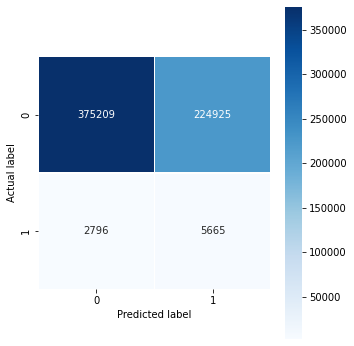

[0]	validation_0-aucpr:0.020126
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.018012
[2]	validation_0-aucpr:0.019964
[3]	validation_0-aucpr:0.020353
[4]	validation_0-aucpr:0.020271
[5]	validation_0-aucpr:0.020326
[6]	validation_0-aucpr:0.021254
[7]	validation_0-aucpr:0.02003
[8]	validation_0-aucpr:0.020327
[9]	validation_0-aucpr:0.019977
[10]	validation_0-aucpr:0.01958
[11]	validation_0-aucpr:0.020244
[12]	validation_0-aucpr:0.020312
[13]	validation_0-aucpr:0.019994
[14]	validation_0-aucpr:0.020029
[15]	validation_0-aucpr:0.020936
[16]	validation_0-aucpr:0.020595
Stopping. Best iteration:
[6]	validation_0-aucpr:0.021254

Prediction Report of trial 35
               precision    recall  f1-score   support

           0       0.99      0.48      0.64    600134
           1       0.02      0.74      0.04      8461

    accuracy                           0.48    608595
   macro avg       0.51      0.61      0.34    608595
weighted avg       0.98

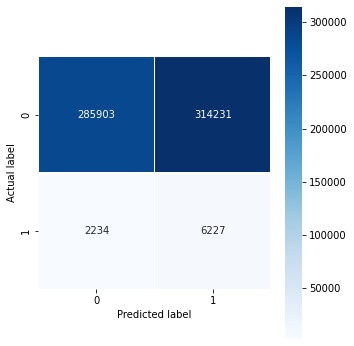

[0]	validation_0-aucpr:0.018482
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.017664
[2]	validation_0-aucpr:0.017487
[3]	validation_0-aucpr:0.016807
[4]	validation_0-aucpr:0.017698
[5]	validation_0-aucpr:0.018349
[6]	validation_0-aucpr:0.017751
[7]	validation_0-aucpr:0.017179
[8]	validation_0-aucpr:0.016734
[9]	validation_0-aucpr:0.016726
[10]	validation_0-aucpr:0.017181
Stopping. Best iteration:
[0]	validation_0-aucpr:0.018482

Prediction Report of trial 36
               precision    recall  f1-score   support

           0       0.99      0.43      0.60    600134
           1       0.02      0.78      0.04      8461

    accuracy                           0.44    608595
   macro avg       0.51      0.61      0.32    608595
weighted avg       0.98      0.44      0.59    608595



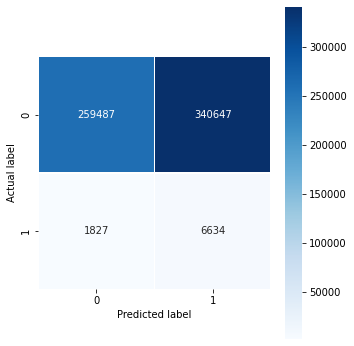

[0]	validation_0-aucpr:0.01658
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.017133
[2]	validation_0-aucpr:0.01729
[3]	validation_0-aucpr:0.017253
[4]	validation_0-aucpr:0.016892
[5]	validation_0-aucpr:0.01731
[6]	validation_0-aucpr:0.017016
[7]	validation_0-aucpr:0.015881
[8]	validation_0-aucpr:0.016582
[9]	validation_0-aucpr:0.016651
[10]	validation_0-aucpr:0.016809
[11]	validation_0-aucpr:0.017014
[12]	validation_0-aucpr:0.017068
[13]	validation_0-aucpr:0.017099
[14]	validation_0-aucpr:0.017259
[15]	validation_0-aucpr:0.017452
[16]	validation_0-aucpr:0.017423
[17]	validation_0-aucpr:0.017516
[18]	validation_0-aucpr:0.017697
[19]	validation_0-aucpr:0.01792
[20]	validation_0-aucpr:0.017966
[21]	validation_0-aucpr:0.017959
[22]	validation_0-aucpr:0.01813
[23]	validation_0-aucpr:0.018281
[24]	validation_0-aucpr:0.018345
[25]	validation_0-aucpr:0.018404
[26]	validation_0-aucpr:0.018201
[27]	validation_0-aucpr:0.018008
[28]	validation_0-aucpr:0

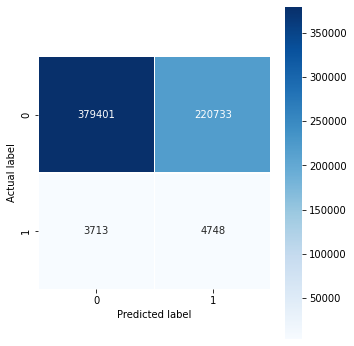

[0]	validation_0-aucpr:0.017612
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.017809
[2]	validation_0-aucpr:0.018266
[3]	validation_0-aucpr:0.017892
[4]	validation_0-aucpr:0.017881
[5]	validation_0-aucpr:0.017129
[6]	validation_0-aucpr:0.016487
[7]	validation_0-aucpr:0.015469
[8]	validation_0-aucpr:0.016301
[9]	validation_0-aucpr:0.016871
[10]	validation_0-aucpr:0.016718
[11]	validation_0-aucpr:0.017073
[12]	validation_0-aucpr:0.016917
Stopping. Best iteration:
[2]	validation_0-aucpr:0.018266

Prediction Report of trial 38
               precision    recall  f1-score   support

           0       0.99      0.51      0.67    600134
           1       0.02      0.55      0.03      8461

    accuracy                           0.51    608595
   macro avg       0.50      0.53      0.35    608595
weighted avg       0.97      0.51      0.66    608595



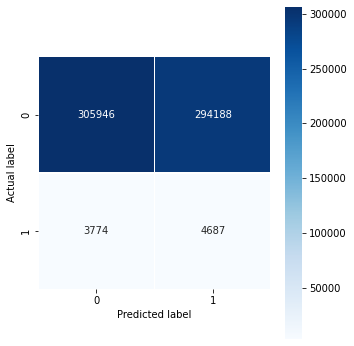

[0]	validation_0-aucpr:0.019569
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.019429
[2]	validation_0-aucpr:0.019178
[3]	validation_0-aucpr:0.019444
[4]	validation_0-aucpr:0.019511
[5]	validation_0-aucpr:0.020406
[6]	validation_0-aucpr:0.020883
[7]	validation_0-aucpr:0.020903
[8]	validation_0-aucpr:0.021239
[9]	validation_0-aucpr:0.021428
[10]	validation_0-aucpr:0.022033
[11]	validation_0-aucpr:0.021504
[12]	validation_0-aucpr:0.021107
[13]	validation_0-aucpr:0.021331
[14]	validation_0-aucpr:0.021287
[15]	validation_0-aucpr:0.021162
[16]	validation_0-aucpr:0.020372
[17]	validation_0-aucpr:0.020581
[18]	validation_0-aucpr:0.02024
[19]	validation_0-aucpr:0.020622
[20]	validation_0-aucpr:0.020307
Stopping. Best iteration:
[10]	validation_0-aucpr:0.022033

Prediction Report of trial 39
               precision    recall  f1-score   support

           0       0.99      0.59      0.74    600134
           1       0.02      0.61      0.04      846

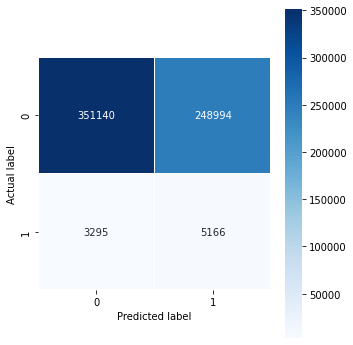

[0]	validation_0-aucpr:0.018612
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.019466
[2]	validation_0-aucpr:0.020249
[3]	validation_0-aucpr:0.020149
[4]	validation_0-aucpr:0.019733
[5]	validation_0-aucpr:0.019189
[6]	validation_0-aucpr:0.018601
[7]	validation_0-aucpr:0.019348
[8]	validation_0-aucpr:0.019131
[9]	validation_0-aucpr:0.019585
[10]	validation_0-aucpr:0.019821
[11]	validation_0-aucpr:0.01966
[12]	validation_0-aucpr:0.019807
Stopping. Best iteration:
[2]	validation_0-aucpr:0.020249

Prediction Report of trial 40
               precision    recall  f1-score   support

           0       0.99      0.53      0.69    600134
           1       0.02      0.63      0.04      8461

    accuracy                           0.54    608595
   macro avg       0.50      0.58      0.37    608595
weighted avg       0.98      0.54      0.68    608595



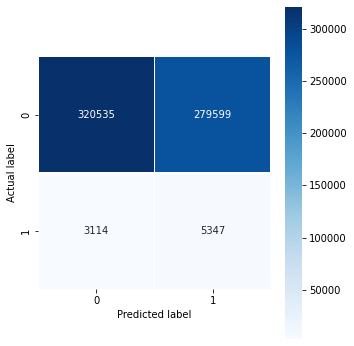

[0]	validation_0-aucpr:0.02254
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.022235
[2]	validation_0-aucpr:0.022286
[3]	validation_0-aucpr:0.022636
[4]	validation_0-aucpr:0.022894
[5]	validation_0-aucpr:0.021426
[6]	validation_0-aucpr:0.020954
[7]	validation_0-aucpr:0.021398
[8]	validation_0-aucpr:0.021756
[9]	validation_0-aucpr:0.022429
[10]	validation_0-aucpr:0.021866
[11]	validation_0-aucpr:0.021206
[12]	validation_0-aucpr:0.021565
[13]	validation_0-aucpr:0.022026
[14]	validation_0-aucpr:0.021822
Stopping. Best iteration:
[4]	validation_0-aucpr:0.022894

Prediction Report of trial 41
               precision    recall  f1-score   support

           0       0.99      0.58      0.73    600134
           1       0.02      0.58      0.04      8461

    accuracy                           0.58    608595
   macro avg       0.50      0.58      0.38    608595
weighted avg       0.98      0.58      0.72    608595



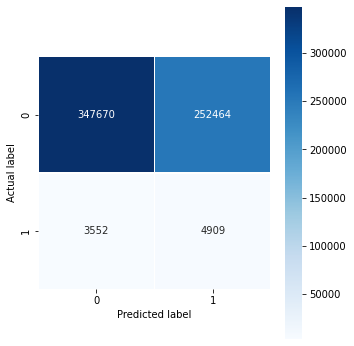

[0]	validation_0-aucpr:0.02367
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.024582
[2]	validation_0-aucpr:0.026381
[3]	validation_0-aucpr:0.02604
[4]	validation_0-aucpr:0.027009
[5]	validation_0-aucpr:0.027352
[6]	validation_0-aucpr:0.028061
[7]	validation_0-aucpr:0.027166
[8]	validation_0-aucpr:0.023708
[9]	validation_0-aucpr:0.023626
[10]	validation_0-aucpr:0.022058
[11]	validation_0-aucpr:0.021168
[12]	validation_0-aucpr:0.021737
[13]	validation_0-aucpr:0.02216
[14]	validation_0-aucpr:0.022796
[15]	validation_0-aucpr:0.023666
[16]	validation_0-aucpr:0.023744
Stopping. Best iteration:
[6]	validation_0-aucpr:0.028061

Prediction Report of trial 42
               precision    recall  f1-score   support

           0       0.99      0.55      0.71    600134
           1       0.02      0.64      0.04      8461

    accuracy                           0.56    608595
   macro avg       0.51      0.60      0.37    608595
weighted avg       0.98 

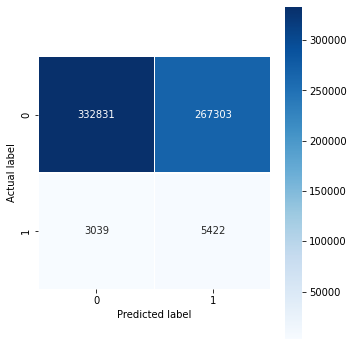

[0]	validation_0-aucpr:0.015684
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.020221
[2]	validation_0-aucpr:0.019201
[3]	validation_0-aucpr:0.019553
[4]	validation_0-aucpr:0.018739
[5]	validation_0-aucpr:0.019047
[6]	validation_0-aucpr:0.019189
[7]	validation_0-aucpr:0.018949
[8]	validation_0-aucpr:0.018894
[9]	validation_0-aucpr:0.018852
[10]	validation_0-aucpr:0.019415
[11]	validation_0-aucpr:0.019607
Stopping. Best iteration:
[1]	validation_0-aucpr:0.020221

Prediction Report of trial 43
               precision    recall  f1-score   support

           0       0.99      0.45      0.62    600134
           1       0.02      0.68      0.03      8461

    accuracy                           0.45    608595
   macro avg       0.50      0.57      0.33    608595
weighted avg       0.98      0.45      0.61    608595



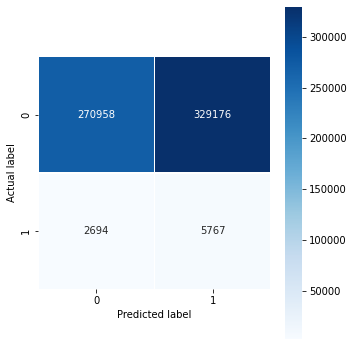

[0]	validation_0-aucpr:0.018268
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.022628
[2]	validation_0-aucpr:0.022898
[3]	validation_0-aucpr:0.023395
[4]	validation_0-aucpr:0.023059
[5]	validation_0-aucpr:0.021923
[6]	validation_0-aucpr:0.021699
[7]	validation_0-aucpr:0.022505
[8]	validation_0-aucpr:0.022054
[9]	validation_0-aucpr:0.020784
[10]	validation_0-aucpr:0.019489
[11]	validation_0-aucpr:0.019459
[12]	validation_0-aucpr:0.018944
[13]	validation_0-aucpr:0.01887
Stopping. Best iteration:
[3]	validation_0-aucpr:0.023395

Prediction Report of trial 44
               precision    recall  f1-score   support

           0       0.99      0.44      0.61    600134
           1       0.02      0.65      0.03      8461

    accuracy                           0.44    608595
   macro avg       0.50      0.54      0.32    608595
weighted avg       0.98      0.44      0.60    608595



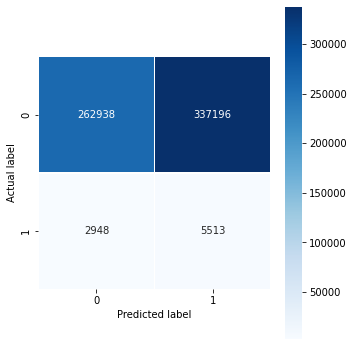

[0]	validation_0-aucpr:0.02004
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.018741
[2]	validation_0-aucpr:0.018745
[3]	validation_0-aucpr:0.018507
[4]	validation_0-aucpr:0.018872
[5]	validation_0-aucpr:0.017303
[6]	validation_0-aucpr:0.016544
[7]	validation_0-aucpr:0.0162
[8]	validation_0-aucpr:0.016423
[9]	validation_0-aucpr:0.01596
[10]	validation_0-aucpr:0.016075
Stopping. Best iteration:
[0]	validation_0-aucpr:0.02004

Prediction Report of trial 45
               precision    recall  f1-score   support

           0       0.99      0.45      0.62    600134
           1       0.02      0.68      0.03      8461

    accuracy                           0.45    608595
   macro avg       0.50      0.56      0.33    608595
weighted avg       0.98      0.45      0.61    608595



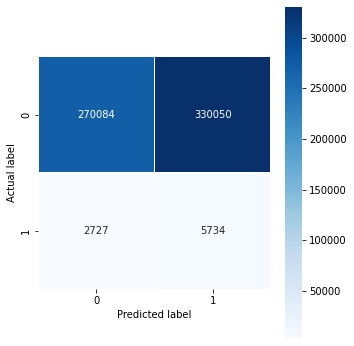

[0]	validation_0-aucpr:0.018813
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.022404
[2]	validation_0-aucpr:0.023558
[3]	validation_0-aucpr:0.024062
[4]	validation_0-aucpr:0.024548
[5]	validation_0-aucpr:0.025647
[6]	validation_0-aucpr:0.02673
[7]	validation_0-aucpr:0.026512
[8]	validation_0-aucpr:0.026931
[9]	validation_0-aucpr:0.025776
[10]	validation_0-aucpr:0.024897
[11]	validation_0-aucpr:0.023647
[12]	validation_0-aucpr:0.023691
[13]	validation_0-aucpr:0.023782
[14]	validation_0-aucpr:0.024521
[15]	validation_0-aucpr:0.024568
[16]	validation_0-aucpr:0.025161
[17]	validation_0-aucpr:0.025048
[18]	validation_0-aucpr:0.025441
Stopping. Best iteration:
[8]	validation_0-aucpr:0.026931

Prediction Report of trial 46
               precision    recall  f1-score   support

           0       0.99      0.53      0.69    600134
           1       0.02      0.69      0.04      8461

    accuracy                           0.54    608595
   macro a

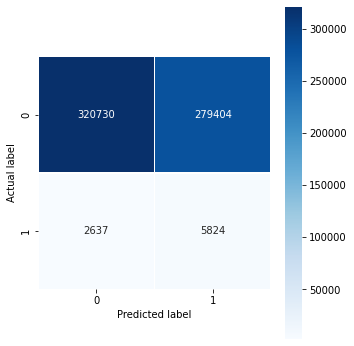

[0]	validation_0-aucpr:0.021723
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.023229
[2]	validation_0-aucpr:0.020741
[3]	validation_0-aucpr:0.018529
[4]	validation_0-aucpr:0.019026
[5]	validation_0-aucpr:0.018313
[6]	validation_0-aucpr:0.017146
[7]	validation_0-aucpr:0.017155
[8]	validation_0-aucpr:0.016839
[9]	validation_0-aucpr:0.017261
[10]	validation_0-aucpr:0.017131
[11]	validation_0-aucpr:0.016515
Stopping. Best iteration:
[1]	validation_0-aucpr:0.023229

Prediction Report of trial 47
               precision    recall  f1-score   support

           0       0.99      0.43      0.60    600134
           1       0.02      0.77      0.04      8461

    accuracy                           0.43    608595
   macro avg       0.51      0.60      0.32    608595
weighted avg       0.98      0.43      0.59    608595



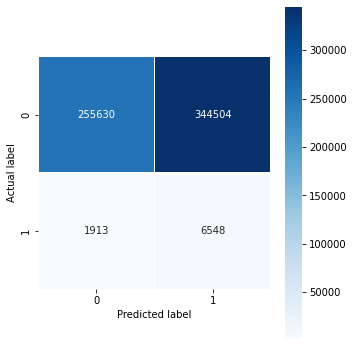

[0]	validation_0-aucpr:0.018895
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.020376
[2]	validation_0-aucpr:0.019308
[3]	validation_0-aucpr:0.020355
[4]	validation_0-aucpr:0.01957
[5]	validation_0-aucpr:0.01924
[6]	validation_0-aucpr:0.018898
[7]	validation_0-aucpr:0.018632
[8]	validation_0-aucpr:0.01892
[9]	validation_0-aucpr:0.019531
[10]	validation_0-aucpr:0.019656
[11]	validation_0-aucpr:0.019134
Stopping. Best iteration:
[1]	validation_0-aucpr:0.020376

Prediction Report of trial 48
               precision    recall  f1-score   support

           0       0.99      0.55      0.71    600134
           1       0.02      0.52      0.03      8461

    accuracy                           0.55    608595
   macro avg       0.50      0.53      0.37    608595
weighted avg       0.97      0.55      0.70    608595



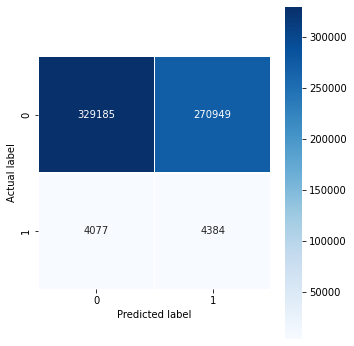

[0]	validation_0-aucpr:0.016707
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.016678
[2]	validation_0-aucpr:0.017244
[3]	validation_0-aucpr:0.016565
[4]	validation_0-aucpr:0.01658
[5]	validation_0-aucpr:0.016432
[6]	validation_0-aucpr:0.016506
[7]	validation_0-aucpr:0.016475
[8]	validation_0-aucpr:0.016698
[9]	validation_0-aucpr:0.016806
[10]	validation_0-aucpr:0.016837
[11]	validation_0-aucpr:0.016844
[12]	validation_0-aucpr:0.016934
Stopping. Best iteration:
[2]	validation_0-aucpr:0.017244

Prediction Report of trial 49
               precision    recall  f1-score   support

           0       0.99      0.57      0.73    600134
           1       0.02      0.56      0.04      8461

    accuracy                           0.57    608595
   macro avg       0.50      0.57      0.38    608595
weighted avg       0.98      0.57      0.72    608595



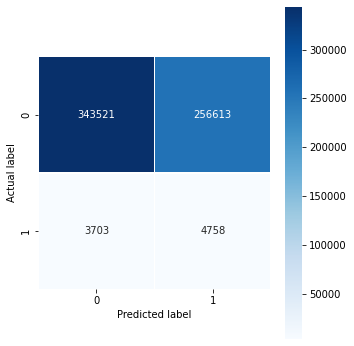

[0]	validation_0-aucpr:0.020321
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.020319
[2]	validation_0-aucpr:0.021945
[3]	validation_0-aucpr:0.024257
[4]	validation_0-aucpr:0.025033
[5]	validation_0-aucpr:0.027862
[6]	validation_0-aucpr:0.030444
[7]	validation_0-aucpr:0.031618
[8]	validation_0-aucpr:0.031232
[9]	validation_0-aucpr:0.033353
[10]	validation_0-aucpr:0.033725
[11]	validation_0-aucpr:0.033665
[12]	validation_0-aucpr:0.034529
[13]	validation_0-aucpr:0.03306
[14]	validation_0-aucpr:0.03316
[15]	validation_0-aucpr:0.034318
[16]	validation_0-aucpr:0.034756
[17]	validation_0-aucpr:0.034856
[18]	validation_0-aucpr:0.035719
[19]	validation_0-aucpr:0.032616
[20]	validation_0-aucpr:0.03173
[21]	validation_0-aucpr:0.03163
[22]	validation_0-aucpr:0.033507
[23]	validation_0-aucpr:0.034
[24]	validation_0-aucpr:0.034211
[25]	validation_0-aucpr:0.03359
[26]	validation_0-aucpr:0.034156
[27]	validation_0-aucpr:0.03379
[28]	validation_0-aucpr:0.034

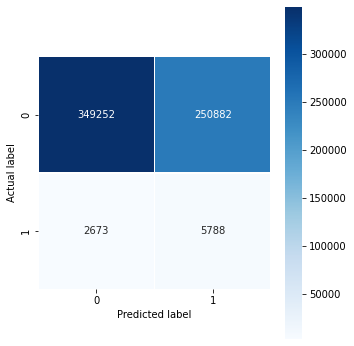

In [27]:
shuffled_flow_id_loss = flow_id_loss.copy()
shuffled_flow_id_no_loss = flow_id_no_loss.copy()

recall_0_list = []
recall_1_list = []
recall_avg_list = []

for trial in range(1, 51):
    random.seed(trial)
    
    random.shuffle(shuffled_flow_id_loss)
    random.shuffle(shuffled_flow_id_no_loss)
    
    df_loss_new = pd.concat([df_loss[df_loss['flow_id']==x] for x in shuffled_flow_id_loss])
    df_no_loss_new = pd.concat([df_no_loss[df_no_loss['flow_id']==x] for x in shuffled_flow_id_no_loss])
            
    df_train = pd.concat([df_loss_new.iloc[0:int(df_loss_new.shape[0] * 0.7)], df_no_loss_new.iloc[0:int(df_no_loss_new.shape[0] * 0.7)]])
    df_train_shuffled = df_train.sample(frac=1).reset_index()
    df_train_shuffled.drop(['index'], axis=1, inplace=True)
    df_test = pd.concat([df_loss_new.iloc[int(df_loss_new.shape[0] * 0.7)+1: -1], df_no_loss_new.iloc[int(df_no_loss_new.shape[0] * 0.7)+1: -1]])
    df_test_shuffled = df_test.sample(frac=1).reset_index()
    df_test_shuffled.drop(['index'], axis=1, inplace=True)

    x_train = df_train_shuffled[full_features_list]
    x_test = df_test_shuffled[full_features_list]
    y_train = df_train_shuffled[['lossOrNot']]
    y_train = y_train.astype(int)
    y_test = df_test_shuffled[['lossOrNot']]
    y_test = y_test.astype(int)
    
    clf_xgb_check = xgb.XGBClassifier(
        n_estimators=500, 
        objective='binary:logistic', 
        scale_pos_weight=70, 
        n_jobs=48
    )

    clf_xgb_check.fit(x_train, y_train, early_stopping_rounds=10, eval_metric='aucpr', eval_set=[(x_test, y_test)])
            
    y_pred = clf_xgb_check.predict(x_test)
    print(f"Prediction Report of trial {trial}\n", classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,5))
    sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
    report = classification_report(y_test, y_pred, output_dict=True)
    recall_0_list.append(report['0']['recall'])
    recall_1_list.append(report['1']['recall'])
    recall_avg_list.append(report['macro avg']['recall'])

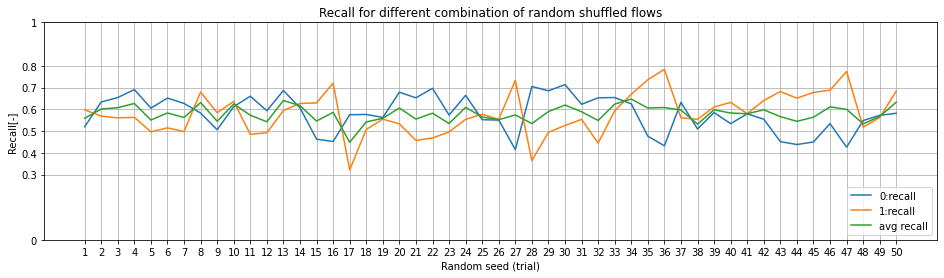

The best performance is at trial 34:
   recall of class 0: 0.6252087033895763
   recall of class 1: 0.6695426072568255
   macro average recall: 0.6473756553232008
                 OR
The best performance is at trial 13:
   recall of class 0: 0.6866866399837369
   recall of class 1: 0.5943741874482922
   macro average recall: 0.6405304137160146

The average is 0.5802469448489838 (0:recall), 0.5797683488949297 (1:recall), 0.5800076468719567 (avg recall)


In [32]:
x_label = list(range(1,51))
plt.figure(figsize=(16,4))
plt.plot(x_label, recall_0_list, label='0:recall')
plt.plot(x_label, recall_1_list, label='1:recall')
plt.plot(x_label, recall_avg_list, label='avg recall')
plt.xticks(x_label, x_label)
plt.legend(loc=4)
plt.grid()
plt.ylim([0,1])
plt.yticks([0, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1], [0, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1])
plt.title('Recall for different combination of random shuffled flows')
plt.xlabel('Random seed (trial)')
plt.ylabel('Recall[-]')
plt.show()

print(f'The best performance is at trial 34:\n   recall of class 0: {recall_0_list[33]}\n   recall of class 1: {recall_1_list[33]}\n   macro average recall: {recall_avg_list[33]}')
print('                 OR')
print(f'The best performance is at trial 13:\n   recall of class 0: {recall_0_list[12]}\n   recall of class 1: {recall_1_list[12]}\n   macro average recall: {recall_avg_list[12]}')
print()
print(f'The average is {np.array(recall_0_list).mean()} (0:recall), {np.array(recall_1_list).mean()} (1:recall), {np.array(recall_avg_list).mean()} (avg recall)')

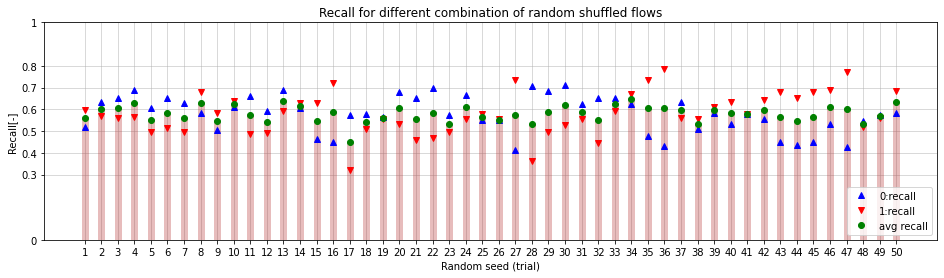

In [30]:
x_label = list(range(1,51))
plt.figure(figsize=(16,4))
plt.plot(x_label, recall_0_list, '^', label='0:recall', color='b')
plt.plot(x_label, recall_1_list, 'v', label='1:recall', color='r')
plt.plot(x_label, recall_avg_list, 'o', label='avg recall', color='g')
plt.vlines(x=x_label, ymin=0, ymax=recall_avg_list, linestyles='solid', color='firebrick', alpha=0.3, linewidth=7)
plt.xticks(x_label, x_label)
plt.legend(loc=4)
plt.grid(alpha=0.6)
plt.ylim([0,1])
plt.yticks([0, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1], [0, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1])
plt.title('Recall for different combination of random shuffled flows')
plt.xlabel('Random seed (trial)')
plt.ylabel('Recall[-]')
plt.show()

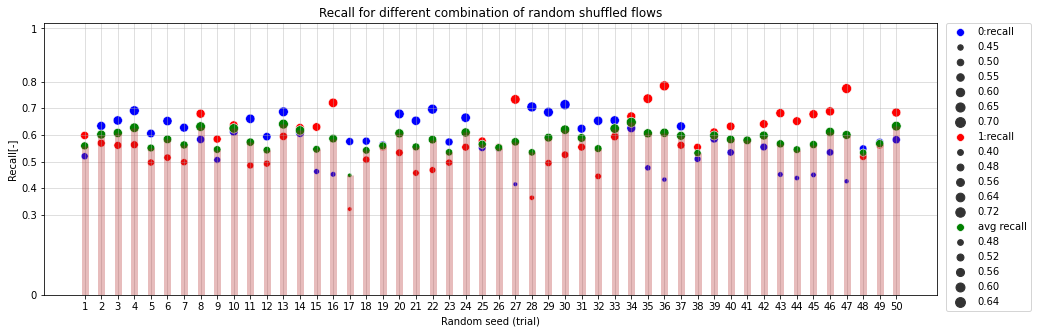

In [31]:
plt.figure(figsize=(16,5))
sns.scatterplot(x=x_label, y=recall_0_list, label='0:recall', size=recall_0_list, sizes=(20, 100), color='b')
sns.scatterplot(x=x_label, y=recall_1_list, label='1:recall', size=recall_1_list, sizes=(20, 100), color='r')
sns.scatterplot(x=x_label, y=recall_avg_list, label='avg recall', size=recall_avg_list, sizes=(20, 100), color='g')
plt.vlines(x=x_label, ymin=0, ymax=recall_avg_list, linestyles='solid', color='firebrick', alpha=0.3, linewidth=7)
plt.xticks(x_label, x_label)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.grid(alpha=0.5)
plt.ylim([0,1.02])
plt.yticks([0, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1], [0, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1])
plt.title('Recall for different combination of random shuffled flows')
plt.xlabel('Random seed (trial)')
plt.ylabel('Recall[-]')
plt.show()

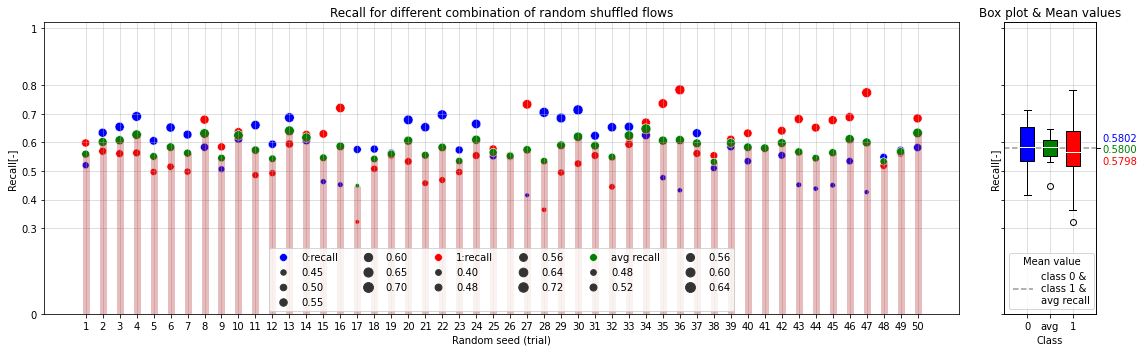

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5), sharey=True, gridspec_kw={'width_ratios': [10, 1]})

sns.scatterplot(x=x_label, y=recall_0_list, label='0:recall', size=recall_0_list, sizes=(20, 100), color='b', ax=ax1)
sns.scatterplot(x=x_label, y=recall_1_list, label='1:recall', size=recall_1_list, sizes=(20, 100), color='r', ax=ax1)
sns.scatterplot(x=x_label, y=recall_avg_list, label='avg recall', size=recall_avg_list, sizes=(20, 100), color='g', ax=ax1)
ax1.vlines(x=x_label, ymin=0, ymax=recall_avg_list, linestyles='solid', color='firebrick', alpha=0.3, linewidth=7)
ax1.set_xticks(x_label)
ax1.legend(loc='lower center', bbox_to_anchor=(0.5, 0.01), borderaxespad=0, ncol=6)
ax1.grid(alpha=0.5)
plt.ylim([0,1.02])
plt.yticks([0, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1], [0, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1])
ax1.set_xlabel('Random seed (trial)')
ax1.set_ylabel('Recall[-]')
ax1.set_title('Recall for different combination of random shuffled flows')

box = ax2.boxplot([recall_0_list, recall_1_list, recall_avg_list], positions=[1, 2, 1.5], widths=0.3, patch_artist=True) # meanline=True, showmeans=True
ax2.set_title('Box plot & Mean values')
ax2.set_xticks([1, 2, 1.5])
ax2.set_xticklabels(['0', '1', 'avg'])
ax2.set_xlabel('Class')
ax2.grid(alpha=0.5)
ax2.set_ylabel('Recall[-]')
# ax2.yaxis.set_label_position("right")
colors = ['blue', 'red', 'green']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
for median in box['medians']:
    median.set_color('white')
ax2.axhline(y=0.580, color='black', linestyle='--', alpha=0.4, label='class 0 &\nclass 1 &\navg recall')
ax2.legend(title='Mean value', loc=3)
ax3 = ax2.twinx()
ax3.set_yticks([0.58, 0.58, 0.58])
ax3.set_yticklabels(['0.5802\n\n', '0.5800', '\n\n0.5798'])
ax3.set_ylim([0,1.02])
ax3.get_yticklabels()[0].set_color("b")
ax3.get_yticklabels()[1].set_color("g")
ax3.get_yticklabels()[2].set_color("r")

plt.tight_layout()
plt.show()

In [39]:
print(recall_0_list)
print(recall_1_list)
print(recall_avg_list)

[0.5199822039744457, 0.6337734572612117, 0.6542755451282547, 0.6908840358986493, 0.60543145364202, 0.6519893890364485, 0.6271682657539817, 0.582949807876241, 0.5061302975668768, 0.6122999196846037, 0.6604758270652887, 0.5934907870575572, 0.6866866399837369, 0.6068378062232768, 0.4626450092812605, 0.4520723705039208, 0.5751815427887772, 0.5766195549660575, 0.5626810012430558, 0.6787150869639114, 0.6530774793629422, 0.6966277531351331, 0.5734969190214185, 0.6645482508906344, 0.5522449986169755, 0.5505437119043414, 0.4150023161493933, 0.7050408742047609, 0.6852086367377952, 0.7136856102137189, 0.6232224803127302, 0.6529708365131788, 0.6543488620874671, 0.6252087033895763, 0.4763986043117037, 0.4323817680717973, 0.632193810049089, 0.5097961455274989, 0.5851026604058427, 0.5341057163900063, 0.5793206183952251, 0.5545944739008288, 0.45149583259738657, 0.43813215048639137, 0.45003949118030306, 0.5344306438228795, 0.42595487007901567, 0.5485191640533614, 0.5724071624003972, 0.5819566963378179]

#### correlation with number of packet loss and include everything

In [18]:
import glob
import os
from sklearn import preprocessing

In [19]:
files = glob.glob("Retina/shared/*/*/*_500ms_Song_no_log.csv")

scaler = preprocessing.MinMaxScaler() 

df_total = []
for file in files:   
    df_input = pd.read_csv(file)
    
    df_inter = copy.deepcopy(df_input)
    df_inter = df_inter.loc[~df_inter['ip_src'].str.startswith('192')]
    drop_col = [
        'software', 
        'label', 
        'pcap', 
        'ssrc', 
        'rtp_seq_num_packet_loss', 
        'ip_src', 
        'ip_dst', 
        'prt_src', 
        'prt_dst', 
        'rtp_csrc_csrc_agg',
        'p_type'
    ]
    for col in df_inter.columns:
        if col in drop_col or col.startswith('rtp_interarrival'): 
            df_inter.drop(col, axis=1, inplace=True)
    
    flow_list = df_inter['flow'].drop_duplicates().tolist()
    for flow in flow_list:
        df_check = df_inter[df_inter['flow'] == flow].copy()
        if df_check.shape[0] > 10: 
            df_total.append(df_check)
        
df_total_final = []
flow_id = 1
for df_per_flow in df_total:
    df_temp = copy.deepcopy(df_per_flow)
    df_temp.reset_index(inplace=True)
    df_temp['lossOrNot'] = [1 if x>0 else 0 for x in df_temp['num_packet_loss']] 
    df_temp.drop(['index', 'flow'], axis=1, inplace=True) 
    df_temp['flow_id'] = flow_id
    flow_id += 1
    
    for col in df_temp.columns:
        if col not in ['timestamp', 'lossOrNot', 'num_packet_loss', 'flow_id']:
            df_temp[col] = scaler.fit_transform(df_temp[col].values.reshape(-1,1))
    
    start_time = pd.to_datetime(df_temp['timestamp'].min())
    stop_time = pd.to_datetime(df_temp['timestamp'].max())
    timestamp_ser = pd.date_range(start_time, stop_time, freq="500L")
    correct_len = len(timestamp_ser)
    
    if df_temp.shape[0] == correct_len:
        df_full = copy.deepcopy(df_temp)
        df_total_final.append(df_full)
    
    else:
        df_temp['timestamp'] = pd.to_datetime(df_temp['timestamp'])
        df_full = pd.DataFrame({'timestamp': timestamp_ser})
        df_full['timestamp'] = df_full['timestamp']
        df_full = df_full.merge(df_temp, on='timestamp', how='left')
        
        nan_index_list = [0]
        nan_index_list.extend(df_full[np.isnan(df_full['interarrival_std'])].index.tolist())
        nan_index_list.append(df_full.index[-1])
        
        for i in range(1, len(nan_index_list)):
            if nan_index_list[i] - nan_index_list[i-1] - 1 >= 11:
                start_idx = 0 if nan_index_list[i-1]==0 else nan_index_list[i-1]+1
                stop_idx = df_full.index[-1]+1 if nan_index_list[i]==df_full.index[-1] else nan_index_list[i]
                df_separate = df_full.iloc[start_idx:stop_idx, :].copy()
                df_separate.reset_index(inplace=True)
                df_separate.drop(['index'], axis=1, inplace=True)
                df_total_final.append(df_separate)

In [20]:
# only need features from past 5000ms to 1000ms, do not need 500ms

# 32 in total
possible_features_list = [
    'interarrival_std',
    'interarrival_mean',
    'interarrival_min',
    'interarrival_max',
    'interarrival_kurtosis',
    'interarrival_skew',
    'interarrival_moment3',
    'interarrival_moment4',
    'interarrival_max_min_diff',
    'interarrival_max_min_R',
    'interarrival_min_max_R',
    'interarrival_max_value_count_percent',
    'len_udp_std',
    'len_udp_mean',
    'len_udp_kurtosis',
    'len_udp_skew',
    'len_udp_moment4',
    'len_udp_max_min_diff',
    'len_udp_max_min_R',
    'len_udp_min_max_R',
    'len_udp_max_value_count_percent',
    'interlength_udp_max',
    'interlength_udp_kurtosis',
    'interlength_udp_moment4',
    'interlength_udp_max_min_diff',
    'interlength_udp_max_value_count_percent',
    'rtp_inter_timestamp_std',
    'inter_time_sequence_std',
    'inter_time_sequence_max',
    'inter_time_sequence_moment4',
    'inter_time_sequence_max_min_diff',
    'inter_time_sequence_max_value_count_percent'
]

complete_list = ['lossOrNot', 'num_packet_loss', 'flow_id']
complete_list.extend(possible_features_list)

In [5]:
best_feature_list = [
    'interarrival_std_minus_500ms',
    'interarrival_std_minus_3000ms',
    'interarrival_std_minus_4000ms',
    'interarrival_std_minus_4500ms',
    'interarrival_std_minus_5000ms',
    'interarrival_mean_minus_500ms',
    'interarrival_mean_minus_1000ms',
    'interarrival_mean_minus_1500ms',
    'interarrival_mean_minus_2000ms',
    'interarrival_mean_minus_2500ms',
    'interarrival_mean_minus_3000ms',
    'interarrival_mean_minus_3500ms',
    'interarrival_mean_minus_4000ms',
    'interarrival_mean_minus_4500ms',
    'interarrival_mean_minus_5000ms',
    'interarrival_min_minus_500ms',
    'interarrival_max_minus_500ms',
    'interarrival_max_minus_1000ms',
    'interarrival_max_minus_1500ms',
    'interarrival_max_minus_2000ms',
    'interarrival_max_minus_2500ms',
    'interarrival_max_minus_3000ms',
    'interarrival_max_minus_3500ms',
    'interarrival_max_minus_4000ms',
    'interarrival_max_minus_4500ms',
    'interarrival_max_minus_5000ms',
    'interarrival_kurtosis_minus_500ms',
    'interarrival_kurtosis_minus_3000ms',
    'interarrival_skew_minus_500ms',
    'interarrival_skew_minus_1000ms',
    'interarrival_skew_minus_1500ms',
    'interarrival_skew_minus_2000ms',
    'interarrival_skew_minus_4000ms',
    'interarrival_skew_minus_4500ms',
    'interarrival_moment3_minus_500ms',
    'interarrival_moment3_minus_1000ms',
    'interarrival_moment3_minus_1500ms',
    'interarrival_moment3_minus_2000ms',
    'interarrival_moment3_minus_2500ms',
    'interarrival_moment3_minus_3000ms',
    'interarrival_moment3_minus_3500ms',
    'interarrival_moment3_minus_4000ms',
    'interarrival_moment3_minus_4500ms',
    'interarrival_moment3_minus_5000ms',
    'interarrival_moment4_minus_500ms',
    'interarrival_max_min_diff_minus_500ms',
    'interarrival_max_min_diff_minus_1000ms',
    'interarrival_max_min_diff_minus_4000ms',
    'interarrival_max_min_R_minus_500ms',
    'interarrival_max_min_R_minus_1000ms',
    'interarrival_min_max_R_minus_500ms',
    'interarrival_min_max_R_minus_1000ms',
    'interarrival_max_value_count_percent_minus_500ms',
    'interarrival_max_value_count_percent_minus_1000ms',
    'interarrival_max_value_count_percent_minus_1500ms',
    'interarrival_max_value_count_percent_minus_2000ms',
    'interarrival_max_value_count_percent_minus_2500ms',
    'interarrival_max_value_count_percent_minus_3000ms',
    'interarrival_max_value_count_percent_minus_3500ms',
    'interarrival_max_value_count_percent_minus_5000ms',
    'len_udp_mean_minus_500ms',
    'len_udp_mean_minus_1000ms',
    'len_udp_mean_minus_1500ms',
    'len_udp_mean_minus_2000ms',
    'len_udp_mean_minus_2500ms',
    'len_udp_mean_minus_3000ms',
    'len_udp_mean_minus_3500ms',
    'len_udp_mean_minus_4000ms',
    'len_udp_mean_minus_4500ms',
    'len_udp_mean_minus_5000ms',
    'len_udp_skew_minus_500ms',
    'len_udp_skew_minus_1000ms',
    'len_udp_skew_minus_1500ms',
    'len_udp_skew_minus_3000ms',
    'len_udp_skew_minus_4000ms',
    'len_udp_skew_minus_4500ms',
    'len_udp_skew_minus_5000ms',
    'len_udp_moment4_minus_500ms',
    'len_udp_moment4_minus_3500ms',
    'len_udp_max_min_R_minus_500ms',
    'len_udp_max_min_R_minus_1000ms',
    'len_udp_max_min_R_minus_2500ms',
    'interlength_udp_kurtosis_minus_1000ms',
    'interlength_udp_moment4_minus_500ms',
    'interlength_udp_moment4_minus_1000ms',
    'interlength_udp_moment4_minus_1500ms',
    'interlength_udp_max_value_count_percent_minus_500ms',
    'rtp_inter_timestamp_std_minus_500ms',
    'rtp_inter_timestamp_std_minus_1000ms',
    'rtp_inter_timestamp_std_minus_1500ms',
    'rtp_inter_timestamp_std_minus_2000ms',
    'rtp_inter_timestamp_std_minus_2500ms',
    'rtp_inter_timestamp_std_minus_3000ms',
    'rtp_inter_timestamp_std_minus_3500ms',
    'rtp_inter_timestamp_std_minus_4000ms',
    'rtp_inter_timestamp_std_minus_4500ms',
    'rtp_inter_timestamp_std_minus_5000ms',
    'inter_time_sequence_std_minus_500ms',
    'inter_time_sequence_std_minus_1000ms',
    'inter_time_sequence_moment4_minus_500ms',
    'inter_time_sequence_max_value_count_percent_minus_500ms',
    'inter_time_sequence_max_value_count_percent_minus_1000ms',
    'inter_time_sequence_max_value_count_percent_minus_1500ms',
    'inter_time_sequence_max_value_count_percent_minus_2000ms',
    'inter_time_sequence_max_value_count_percent_minus_2500ms',
    'inter_time_sequence_max_value_count_percent_minus_3000ms',
    'inter_time_sequence_max_value_count_percent_minus_3500ms',
    'inter_time_sequence_max_value_count_percent_minus_4000ms',
    'inter_time_sequence_max_value_count_percent_minus_4500ms',
    'inter_time_sequence_max_value_count_percent_minus_5000ms'
]

In [28]:
# remove features in past 500 ms

best_feature_list_removing_500ms = []
for feature in best_feature_list:
    if '_500ms' not in feature:
        best_feature_list_removing_500ms.append(feature)

len(best_feature_list_removing_500ms)

88

In [21]:
df_total_final_all_possible_feature_extraction_with_num_packet_loss = []
for df in df_total_final:
    df_temp = copy.deepcopy(df)
    df_temp = df_temp[complete_list]
    for feature in possible_features_list:
        for i in range(2,11):
            col_title = f'{feature}_minus_{500*i}ms'
            df_temp[col_title] = df_temp[feature].shift(periods=i, fill_value=-1)
    df_temp.drop(possible_features_list, axis=1, inplace=True)
    df_temp = df_temp.iloc[10:]
    df_temp.reset_index(inplace=True)
    df_temp.drop(['index'], axis=1, inplace=True)
    
    df_total_final_all_possible_feature_extraction_with_num_packet_loss.append(df_temp)

In [22]:
df_complete_with_all_possible_features_final_with_num_packet_loss = pd.concat(df_total_final_all_possible_feature_extraction_with_num_packet_loss)
df_complete_with_all_possible_features_final_with_num_packet_loss.reset_index(inplace=True)
df_complete_with_all_possible_features_final_with_num_packet_loss.drop(['index'], axis=1, inplace=True)
df_complete_with_all_possible_features_final_with_num_packet_loss

lossOrNot  num_packet_loss  flow_id  interarrival_std_minus_1000ms  \
0              0.0              0.0      1.0                       0.111167   
1              0.0              0.0      1.0                       0.185914   
2              0.0              0.0      1.0                       0.169699   
3              0.0              0.0      1.0                       0.122365   
4              0.0              0.0      1.0                       0.081800   
...            ...              ...      ...                            ...   
2028655        0.0              0.0   2882.0                       0.075046   
2028656        0.0              0.0   2882.0                       0.083744   
2028657        0.0              0.0   2882.0                       0.083497   
2028658        0.0              0.0   2882.0                       0.048801   
2028659        0.0              0.0   2882.0                       0.133611   

         interarrival_std_minus_1500ms  interarrival_std_minus_2000ms  \
0                             0.149341                       0.168203   
1                             0.111167                       0.149341   
2                             0.185914                       0.111167   
3                             0.169699                       0.185914   
4                             0.122365                       0.169699   
...                                ...                            ...   
2028655                       0.078230                       0.131936   
2028656                       0.075046                       0.078230   
2028657                       0.083744                       0.075046   
2028658                       0.083497                       0.083744   
2028659                       0.048801                       0.083497   

         interarrival_std_minus_2500ms  interarrival_std_minus_3000ms  \
0                             0.224819                       0.287330   
1                             0.168203                       0.224819   
2                             0.149341                       0.168203   
3                             0.111167                       0.149341   
4                             0.185914                       0.111167   
...                                ...                            ...   
2028655                       0.078184                       0.058745   
2028656                       0.131936                       0.078184   
2028657                       0.078230                       0.131936   
2028658                       0.075046                       0.078230   
2028659                       0.083744                       0.075046   

         interarrival_std_minus_3500ms  interarrival_std_minus_4000ms  ...  \
0                             0.584144                       0.439564  ...   
1                             0.287330                       0.584144  ...   
2                             0.224819                       0.287330  ...   
3                             0.168203                       0.224819  ...   
4                             0.149341                       0.168203  ...   
...                                ...                            ...  ...   
2028655                       0.069150                       0.058216  ...   
2028656                       0.058745                       0.069150  ...   
2028657                       0.078184                       0.058745  ...   
2028658                       0.131936                       0.078184  ...   
2028659                       0.078230                       0.131936  ...   

         inter_time_sequence_max_min_diff_minus_5000ms  \
0                                             0.000000   
1                                             0.263537   
2                                             0.489070   
3                                             0.248001   
4                                             0.335539   
...                  

In [23]:
df_loss = df_complete_with_all_possible_features_final_with_num_packet_loss[df_complete_with_all_possible_features_final_with_num_packet_loss['num_packet_loss'] > 2]
df_no_loss = df_complete_with_all_possible_features_final_with_num_packet_loss[df_complete_with_all_possible_features_final_with_num_packet_loss['num_packet_loss'] == 0]

In [26]:
weight = len(df_no_loss) / len(df_loss)
weight

464.1422273781902

In [33]:
flow_id_loss = df_loss['flow_id'].drop_duplicates().tolist()
flow_id_no_loss = df_no_loss['flow_id'].drop_duplicates().tolist()
shuffled_flow_id_loss = flow_id_loss.copy()
shuffled_flow_id_no_loss = flow_id_no_loss.copy()

[0]	validation_0-aucpr:0.010369
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.01167
[2]	validation_0-aucpr:0.008946
[3]	validation_0-aucpr:0.010094
[4]	validation_0-aucpr:0.010132
[5]	validation_0-aucpr:0.010002
[6]	validation_0-aucpr:0.01031
[7]	validation_0-aucpr:0.010557
[8]	validation_0-aucpr:0.013741
[9]	validation_0-aucpr:0.014658
[10]	validation_0-aucpr:0.018722
[11]	validation_0-aucpr:0.025834
[12]	validation_0-aucpr:0.026015
[13]	validation_0-aucpr:0.027911
[14]	validation_0-aucpr:0.032826
[15]	validation_0-aucpr:0.031904
[16]	validation_0-aucpr:0.036182
[17]	validation_0-aucpr:0.036565
[18]	validation_0-aucpr:0.038319
[19]	validation_0-aucpr:0.039967
[20]	validation_0-aucpr:0.045382
[21]	validation_0-aucpr:0.047365
[22]	validation_0-aucpr:0.050856
[23]	validation_0-aucpr:0.04663
[24]	validation_0-aucpr:0.04879
[25]	validation_0-aucpr:0.049192
[26]	validation_0-aucpr:0.052292
[27]	validation_0-aucpr:0.054373
[28]	validation_0-aucpr:

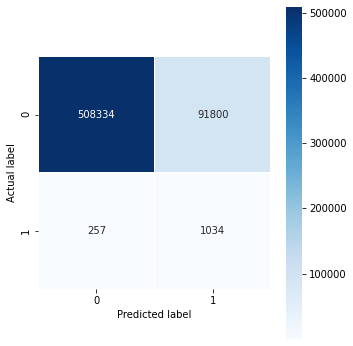

[0]	validation_0-aucpr:0.007806
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.007934
[2]	validation_0-aucpr:0.010227
[3]	validation_0-aucpr:0.010803
[4]	validation_0-aucpr:0.012602
[5]	validation_0-aucpr:0.012758
[6]	validation_0-aucpr:0.01716
[7]	validation_0-aucpr:0.016455
[8]	validation_0-aucpr:0.017135
[9]	validation_0-aucpr:0.025172
[10]	validation_0-aucpr:0.02549
[11]	validation_0-aucpr:0.02768
[12]	validation_0-aucpr:0.045249
[13]	validation_0-aucpr:0.03998
[14]	validation_0-aucpr:0.042616
[15]	validation_0-aucpr:0.043768
[16]	validation_0-aucpr:0.042807
[17]	validation_0-aucpr:0.038509
[18]	validation_0-aucpr:0.051177
[19]	validation_0-aucpr:0.051442
[20]	validation_0-aucpr:0.052863
[21]	validation_0-aucpr:0.053234
[22]	validation_0-aucpr:0.060797
[23]	validation_0-aucpr:0.060888
[24]	validation_0-aucpr:0.06317
[25]	validation_0-aucpr:0.050846
[26]	validation_0-aucpr:0.048113
[27]	validation_0-aucpr:0.047951
[28]	validation_0-aucpr:0

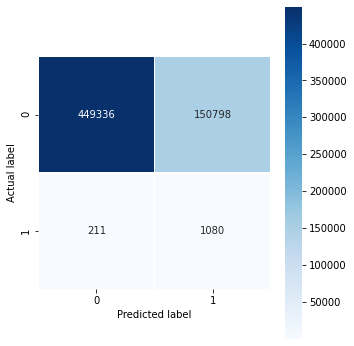

[0]	validation_0-aucpr:0.005309
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.006141
[2]	validation_0-aucpr:0.00658
[3]	validation_0-aucpr:0.006224
[4]	validation_0-aucpr:0.00727
[5]	validation_0-aucpr:0.007388
[6]	validation_0-aucpr:0.007275
[7]	validation_0-aucpr:0.007284
[8]	validation_0-aucpr:0.008306
[9]	validation_0-aucpr:0.008914
[10]	validation_0-aucpr:0.008549
[11]	validation_0-aucpr:0.00995
[12]	validation_0-aucpr:0.010649
[13]	validation_0-aucpr:0.010228
[14]	validation_0-aucpr:0.012224
[15]	validation_0-aucpr:0.012367
[16]	validation_0-aucpr:0.012951
[17]	validation_0-aucpr:0.013018
[18]	validation_0-aucpr:0.014691
[19]	validation_0-aucpr:0.014893
[20]	validation_0-aucpr:0.015267
[21]	validation_0-aucpr:0.015091
[22]	validation_0-aucpr:0.01515
[23]	validation_0-aucpr:0.015378
[24]	validation_0-aucpr:0.015371
[25]	validation_0-aucpr:0.015378
[26]	validation_0-aucpr:0.015885
[27]	validation_0-aucpr:0.016481
[28]	validation_0-aucpr:

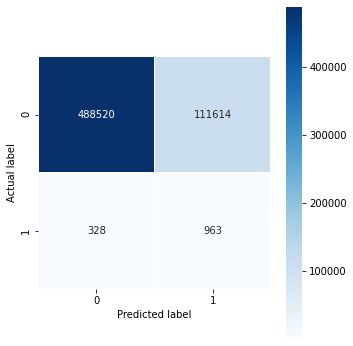

[0]	validation_0-aucpr:0.009186
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.012181
[2]	validation_0-aucpr:0.012376
[3]	validation_0-aucpr:0.019117
[4]	validation_0-aucpr:0.019369
[5]	validation_0-aucpr:0.019781
[6]	validation_0-aucpr:0.017006
[7]	validation_0-aucpr:0.017396
[8]	validation_0-aucpr:0.013666
[9]	validation_0-aucpr:0.019924
[10]	validation_0-aucpr:0.018892
[11]	validation_0-aucpr:0.020507
[12]	validation_0-aucpr:0.023356
[13]	validation_0-aucpr:0.026157
[14]	validation_0-aucpr:0.026682
[15]	validation_0-aucpr:0.027965
[16]	validation_0-aucpr:0.028962
[17]	validation_0-aucpr:0.029116
[18]	validation_0-aucpr:0.030349
[19]	validation_0-aucpr:0.030136
[20]	validation_0-aucpr:0.0299
[21]	validation_0-aucpr:0.030737
[22]	validation_0-aucpr:0.030647
[23]	validation_0-aucpr:0.031629
[24]	validation_0-aucpr:0.031325
[25]	validation_0-aucpr:0.031679
[26]	validation_0-aucpr:0.03099
[27]	validation_0-aucpr:0.030729
[28]	validation_0-aucpr

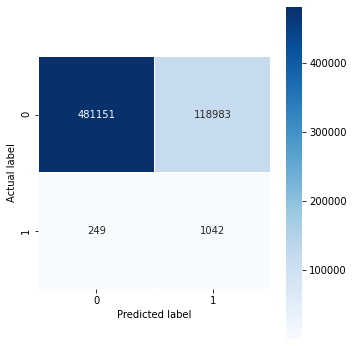

[0]	validation_0-aucpr:0.005405
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.00588
[2]	validation_0-aucpr:0.006024
[3]	validation_0-aucpr:0.007213
[4]	validation_0-aucpr:0.007026
[5]	validation_0-aucpr:0.011787
[6]	validation_0-aucpr:0.011089
[7]	validation_0-aucpr:0.017686
[8]	validation_0-aucpr:0.019008
[9]	validation_0-aucpr:0.019639
[10]	validation_0-aucpr:0.020409
[11]	validation_0-aucpr:0.024448
[12]	validation_0-aucpr:0.023815
[13]	validation_0-aucpr:0.025358
[14]	validation_0-aucpr:0.027005
[15]	validation_0-aucpr:0.027007
[16]	validation_0-aucpr:0.028352
[17]	validation_0-aucpr:0.028383
[18]	validation_0-aucpr:0.028731
[19]	validation_0-aucpr:0.029099
[20]	validation_0-aucpr:0.028566
[21]	validation_0-aucpr:0.029024
[22]	validation_0-aucpr:0.027169
[23]	validation_0-aucpr:0.027057
[24]	validation_0-aucpr:0.028365
[25]	validation_0-aucpr:0.027745
[26]	validation_0-aucpr:0.026311
[27]	validation_0-aucpr:0.025824
[28]	validation_0-auc

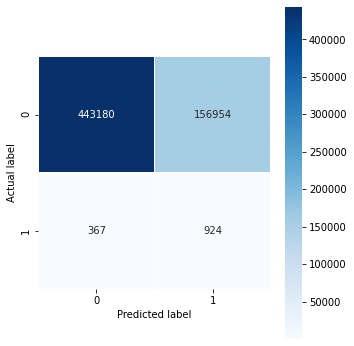

[0]	validation_0-aucpr:0.006323
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.006041
[2]	validation_0-aucpr:0.006577
[3]	validation_0-aucpr:0.006466
[4]	validation_0-aucpr:0.010705
[5]	validation_0-aucpr:0.010672
[6]	validation_0-aucpr:0.011071
[7]	validation_0-aucpr:0.01123
[8]	validation_0-aucpr:0.01254
[9]	validation_0-aucpr:0.013805
[10]	validation_0-aucpr:0.013708
[11]	validation_0-aucpr:0.013919
[12]	validation_0-aucpr:0.013708
[13]	validation_0-aucpr:0.014772
[14]	validation_0-aucpr:0.014419
[15]	validation_0-aucpr:0.015398
[16]	validation_0-aucpr:0.019733
[17]	validation_0-aucpr:0.019851
[18]	validation_0-aucpr:0.019391
[19]	validation_0-aucpr:0.019467
[20]	validation_0-aucpr:0.019843
[21]	validation_0-aucpr:0.014308
[22]	validation_0-aucpr:0.015897
[23]	validation_0-aucpr:0.015752
[24]	validation_0-aucpr:0.018706
[25]	validation_0-aucpr:0.016956
[26]	validation_0-aucpr:0.018109
[27]	validation_0-aucpr:0.018487
Stopping. Best iterati

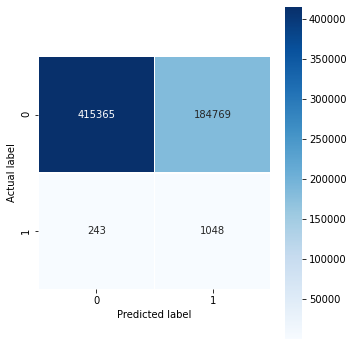

[0]	validation_0-aucpr:0.007228
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.007523
[2]	validation_0-aucpr:0.007577
[3]	validation_0-aucpr:0.0083
[4]	validation_0-aucpr:0.008102
[5]	validation_0-aucpr:0.008581
[6]	validation_0-aucpr:0.011069
[7]	validation_0-aucpr:0.012323
[8]	validation_0-aucpr:0.01386
[9]	validation_0-aucpr:0.013923
[10]	validation_0-aucpr:0.014413
[11]	validation_0-aucpr:0.014605
[12]	validation_0-aucpr:0.014558
[13]	validation_0-aucpr:0.0138
[14]	validation_0-aucpr:0.014533
[15]	validation_0-aucpr:0.014516
[16]	validation_0-aucpr:0.014522
[17]	validation_0-aucpr:0.014657
[18]	validation_0-aucpr:0.014536
[19]	validation_0-aucpr:0.0166
[20]	validation_0-aucpr:0.016656
[21]	validation_0-aucpr:0.018661
[22]	validation_0-aucpr:0.018419
[23]	validation_0-aucpr:0.017858
[24]	validation_0-aucpr:0.017471
[25]	validation_0-aucpr:0.017446
[26]	validation_0-aucpr:0.017272
[27]	validation_0-aucpr:0.017452
[28]	validation_0-aucpr:0.0

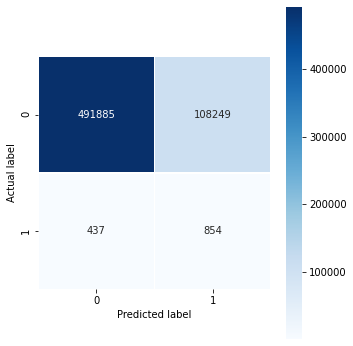

[0]	validation_0-aucpr:0.009066
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.010761
[2]	validation_0-aucpr:0.010467
[3]	validation_0-aucpr:0.010297
[4]	validation_0-aucpr:0.010983
[5]	validation_0-aucpr:0.010955
[6]	validation_0-aucpr:0.017549
[7]	validation_0-aucpr:0.024596
[8]	validation_0-aucpr:0.024304
[9]	validation_0-aucpr:0.02969
[10]	validation_0-aucpr:0.029839
[11]	validation_0-aucpr:0.031314
[12]	validation_0-aucpr:0.030783
[13]	validation_0-aucpr:0.032085
[14]	validation_0-aucpr:0.03024
[15]	validation_0-aucpr:0.032973
[16]	validation_0-aucpr:0.029632
[17]	validation_0-aucpr:0.030268
[18]	validation_0-aucpr:0.036769
[19]	validation_0-aucpr:0.035763
[20]	validation_0-aucpr:0.043878
[21]	validation_0-aucpr:0.050393
[22]	validation_0-aucpr:0.049543
[23]	validation_0-aucpr:0.051683
[24]	validation_0-aucpr:0.053955
[25]	validation_0-aucpr:0.059364
[26]	validation_0-aucpr:0.061953
[27]	validation_0-aucpr:0.069425
[28]	validation_0-aucp

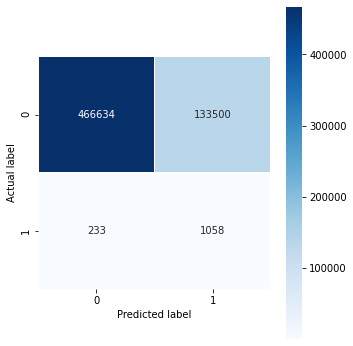

[0]	validation_0-aucpr:0.007293
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.007379
[2]	validation_0-aucpr:0.007878
[3]	validation_0-aucpr:0.007789
[4]	validation_0-aucpr:0.007822
[5]	validation_0-aucpr:0.007886
[6]	validation_0-aucpr:0.007861
[7]	validation_0-aucpr:0.008567
[8]	validation_0-aucpr:0.009319
[9]	validation_0-aucpr:0.013209
[10]	validation_0-aucpr:0.018256
[11]	validation_0-aucpr:0.018569
[12]	validation_0-aucpr:0.019608
[13]	validation_0-aucpr:0.019615
[14]	validation_0-aucpr:0.029443
[15]	validation_0-aucpr:0.033005
[16]	validation_0-aucpr:0.035637
[17]	validation_0-aucpr:0.034568
[18]	validation_0-aucpr:0.03621
[19]	validation_0-aucpr:0.032307
[20]	validation_0-aucpr:0.035134
[21]	validation_0-aucpr:0.037173
[22]	validation_0-aucpr:0.036798
[23]	validation_0-aucpr:0.034429
[24]	validation_0-aucpr:0.033887
[25]	validation_0-aucpr:0.031898
[26]	validation_0-aucpr:0.029414
[27]	validation_0-aucpr:0.025918
[28]	validation_0-auc

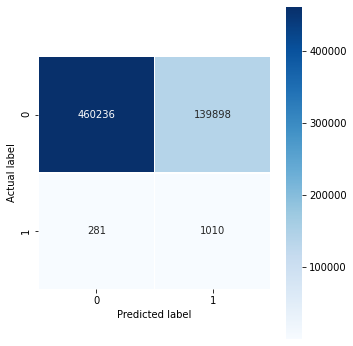

[0]	validation_0-aucpr:0.008107
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.009463
[2]	validation_0-aucpr:0.009779
[3]	validation_0-aucpr:0.008074
[4]	validation_0-aucpr:0.008337
[5]	validation_0-aucpr:0.008551
[6]	validation_0-aucpr:0.008547
[7]	validation_0-aucpr:0.012486
[8]	validation_0-aucpr:0.010258
[9]	validation_0-aucpr:0.011321
[10]	validation_0-aucpr:0.011991
[11]	validation_0-aucpr:0.014083
[12]	validation_0-aucpr:0.013743
[13]	validation_0-aucpr:0.016066
[14]	validation_0-aucpr:0.016159
[15]	validation_0-aucpr:0.016557
[16]	validation_0-aucpr:0.017065
[17]	validation_0-aucpr:0.015585
[18]	validation_0-aucpr:0.015115
[19]	validation_0-aucpr:0.014407
[20]	validation_0-aucpr:0.014432
[21]	validation_0-aucpr:0.013821
[22]	validation_0-aucpr:0.013562
[23]	validation_0-aucpr:0.012621
[24]	validation_0-aucpr:0.012505
[25]	validation_0-aucpr:0.012261
[26]	validation_0-aucpr:0.013041
Stopping. Best iteration:
[16]	validation_0-aucpr:0.0

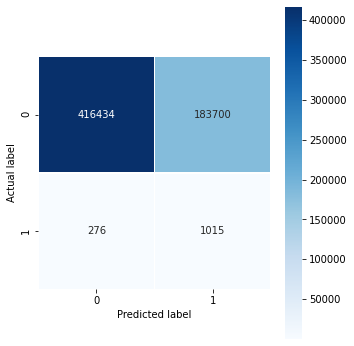

[0]	validation_0-aucpr:0.006866
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.006506
[2]	validation_0-aucpr:0.006537
[3]	validation_0-aucpr:0.006341
[4]	validation_0-aucpr:0.006491
[5]	validation_0-aucpr:0.006458
[6]	validation_0-aucpr:0.006564
[7]	validation_0-aucpr:0.006613
[8]	validation_0-aucpr:0.01143
[9]	validation_0-aucpr:0.011613
[10]	validation_0-aucpr:0.013151
[11]	validation_0-aucpr:0.016896
[12]	validation_0-aucpr:0.017025
[13]	validation_0-aucpr:0.014775
[14]	validation_0-aucpr:0.015074
[15]	validation_0-aucpr:0.013567
[16]	validation_0-aucpr:0.014572
[17]	validation_0-aucpr:0.013481
[18]	validation_0-aucpr:0.010977
[19]	validation_0-aucpr:0.011657
[20]	validation_0-aucpr:0.012267
[21]	validation_0-aucpr:0.012669
[22]	validation_0-aucpr:0.010997
Stopping. Best iteration:
[12]	validation_0-aucpr:0.017025

Prediction Report of trial 11
               precision    recall  f1-score   support

           0       1.00      0.72      0

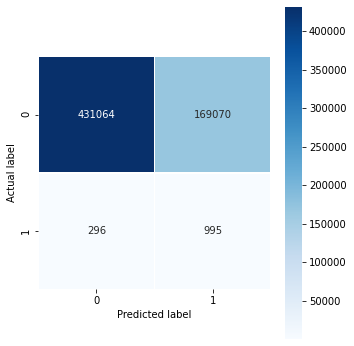

[0]	validation_0-aucpr:0.007823
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.007845
[2]	validation_0-aucpr:0.00815
[3]	validation_0-aucpr:0.008418
[4]	validation_0-aucpr:0.010876
[5]	validation_0-aucpr:0.012908
[6]	validation_0-aucpr:0.012718
[7]	validation_0-aucpr:0.01294
[8]	validation_0-aucpr:0.01396
[9]	validation_0-aucpr:0.014117
[10]	validation_0-aucpr:0.014087
[11]	validation_0-aucpr:0.014788
[12]	validation_0-aucpr:0.014966
[13]	validation_0-aucpr:0.015552
[14]	validation_0-aucpr:0.020559
[15]	validation_0-aucpr:0.021965
[16]	validation_0-aucpr:0.021907
[17]	validation_0-aucpr:0.024247
[18]	validation_0-aucpr:0.023925
[19]	validation_0-aucpr:0.025706
[20]	validation_0-aucpr:0.027559
[21]	validation_0-aucpr:0.026058
[22]	validation_0-aucpr:0.029077
[23]	validation_0-aucpr:0.030302
[24]	validation_0-aucpr:0.030378
[25]	validation_0-aucpr:0.031611
[26]	validation_0-aucpr:0.032297
[27]	validation_0-aucpr:0.033196
[28]	validation_0-aucpr

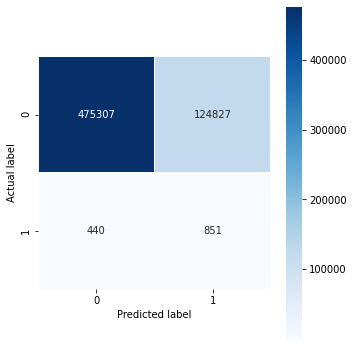

[0]	validation_0-aucpr:0.005999
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.006069
[2]	validation_0-aucpr:0.006224
[3]	validation_0-aucpr:0.006152
[4]	validation_0-aucpr:0.006236
[5]	validation_0-aucpr:0.00684
[6]	validation_0-aucpr:0.007094
[7]	validation_0-aucpr:0.007059
[8]	validation_0-aucpr:0.00815
[9]	validation_0-aucpr:0.007943
[10]	validation_0-aucpr:0.010549
[11]	validation_0-aucpr:0.010828
[12]	validation_0-aucpr:0.010795
[13]	validation_0-aucpr:0.010103
[14]	validation_0-aucpr:0.009692
[15]	validation_0-aucpr:0.015252
[16]	validation_0-aucpr:0.021966
[17]	validation_0-aucpr:0.02124
[18]	validation_0-aucpr:0.021263
[19]	validation_0-aucpr:0.020683
[20]	validation_0-aucpr:0.021606
[21]	validation_0-aucpr:0.021498
[22]	validation_0-aucpr:0.022338
[23]	validation_0-aucpr:0.025161
[24]	validation_0-aucpr:0.020265
[25]	validation_0-aucpr:0.020777
[26]	validation_0-aucpr:0.021093
[27]	validation_0-aucpr:0.020896
[28]	validation_0-aucpr

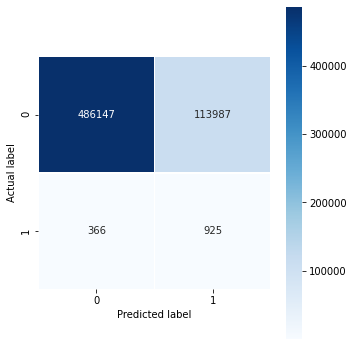

[0]	validation_0-aucpr:0.009207
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.01155
[2]	validation_0-aucpr:0.014119
[3]	validation_0-aucpr:0.013922
[4]	validation_0-aucpr:0.014483
[5]	validation_0-aucpr:0.013151
[6]	validation_0-aucpr:0.012862
[7]	validation_0-aucpr:0.013265
[8]	validation_0-aucpr:0.0151
[9]	validation_0-aucpr:0.015793
[10]	validation_0-aucpr:0.015941
[11]	validation_0-aucpr:0.015636
[12]	validation_0-aucpr:0.023571
[13]	validation_0-aucpr:0.024389
[14]	validation_0-aucpr:0.019005
[15]	validation_0-aucpr:0.021141
[16]	validation_0-aucpr:0.020985
[17]	validation_0-aucpr:0.02808
[18]	validation_0-aucpr:0.028309
[19]	validation_0-aucpr:0.025811
[20]	validation_0-aucpr:0.024351
[21]	validation_0-aucpr:0.024856
[22]	validation_0-aucpr:0.024173
[23]	validation_0-aucpr:0.024438
[24]	validation_0-aucpr:0.02815
[25]	validation_0-aucpr:0.028057
[26]	validation_0-aucpr:0.028603
[27]	validation_0-aucpr:0.031376
[28]	validation_0-aucpr:0

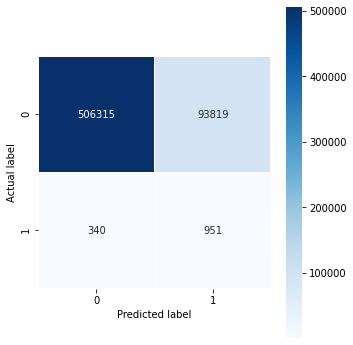

[0]	validation_0-aucpr:0.007377
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.007905
[2]	validation_0-aucpr:0.007987
[3]	validation_0-aucpr:0.008462
[4]	validation_0-aucpr:0.00889
[5]	validation_0-aucpr:0.008842
[6]	validation_0-aucpr:0.010173
[7]	validation_0-aucpr:0.010025
[8]	validation_0-aucpr:0.009936
[9]	validation_0-aucpr:0.009585
[10]	validation_0-aucpr:0.009442
[11]	validation_0-aucpr:0.009556
[12]	validation_0-aucpr:0.010438
[13]	validation_0-aucpr:0.010462
[14]	validation_0-aucpr:0.012397
[15]	validation_0-aucpr:0.011962
[16]	validation_0-aucpr:0.013453
[17]	validation_0-aucpr:0.013499
[18]	validation_0-aucpr:0.013326
[19]	validation_0-aucpr:0.012917
[20]	validation_0-aucpr:0.014337
[21]	validation_0-aucpr:0.013953
[22]	validation_0-aucpr:0.015562
[23]	validation_0-aucpr:0.012808
[24]	validation_0-aucpr:0.014663
[25]	validation_0-aucpr:0.01585
[26]	validation_0-aucpr:0.015144
[27]	validation_0-aucpr:0.01503
[28]	validation_0-aucpr

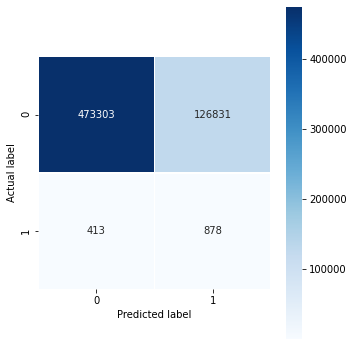

[0]	validation_0-aucpr:0.008171
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.008791
[2]	validation_0-aucpr:0.009611
[3]	validation_0-aucpr:0.009688
[4]	validation_0-aucpr:0.011216
[5]	validation_0-aucpr:0.011461
[6]	validation_0-aucpr:0.015335
[7]	validation_0-aucpr:0.01617
[8]	validation_0-aucpr:0.017149
[9]	validation_0-aucpr:0.020161
[10]	validation_0-aucpr:0.018772
[11]	validation_0-aucpr:0.018399
[12]	validation_0-aucpr:0.019074
[13]	validation_0-aucpr:0.019702
[14]	validation_0-aucpr:0.018987
[15]	validation_0-aucpr:0.018079
[16]	validation_0-aucpr:0.017956
[17]	validation_0-aucpr:0.018387
[18]	validation_0-aucpr:0.018224
[19]	validation_0-aucpr:0.017704
Stopping. Best iteration:
[9]	validation_0-aucpr:0.020161

Prediction Report of trial 16
               precision    recall  f1-score   support

           0       1.00      0.79      0.88    600134
           1       0.01      0.62      0.01      1291

    accuracy                   

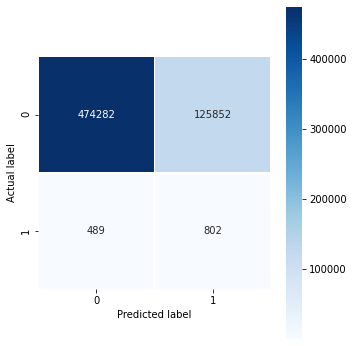

[0]	validation_0-aucpr:0.007402
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.007318
[2]	validation_0-aucpr:0.011778
[3]	validation_0-aucpr:0.015154
[4]	validation_0-aucpr:0.015501
[5]	validation_0-aucpr:0.026567
[6]	validation_0-aucpr:0.027101
[7]	validation_0-aucpr:0.027129
[8]	validation_0-aucpr:0.027334
[9]	validation_0-aucpr:0.02808
[10]	validation_0-aucpr:0.034203
[11]	validation_0-aucpr:0.033447
[12]	validation_0-aucpr:0.033933
[13]	validation_0-aucpr:0.039507
[14]	validation_0-aucpr:0.034368
[15]	validation_0-aucpr:0.032694
[16]	validation_0-aucpr:0.03536
[17]	validation_0-aucpr:0.052314
[18]	validation_0-aucpr:0.052646
[19]	validation_0-aucpr:0.050036
[20]	validation_0-aucpr:0.047622
[21]	validation_0-aucpr:0.046596
[22]	validation_0-aucpr:0.046766
[23]	validation_0-aucpr:0.048124
[24]	validation_0-aucpr:0.05204
[25]	validation_0-aucpr:0.051601
[26]	validation_0-aucpr:0.051225
[27]	validation_0-aucpr:0.06225
[28]	validation_0-aucpr:

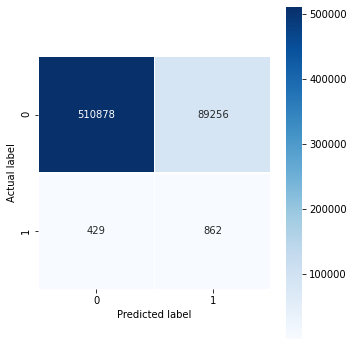

[0]	validation_0-aucpr:0.005282
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.007447
[2]	validation_0-aucpr:0.008749
[3]	validation_0-aucpr:0.008192
[4]	validation_0-aucpr:0.007983
[5]	validation_0-aucpr:0.008943
[6]	validation_0-aucpr:0.008597
[7]	validation_0-aucpr:0.009076
[8]	validation_0-aucpr:0.008937
[9]	validation_0-aucpr:0.009153
[10]	validation_0-aucpr:0.009591
[11]	validation_0-aucpr:0.009475
[12]	validation_0-aucpr:0.009437
[13]	validation_0-aucpr:0.009421
[14]	validation_0-aucpr:0.009563
[15]	validation_0-aucpr:0.009445
[16]	validation_0-aucpr:0.009516
[17]	validation_0-aucpr:0.009437
[18]	validation_0-aucpr:0.009449
[19]	validation_0-aucpr:0.00951
[20]	validation_0-aucpr:0.009603
[21]	validation_0-aucpr:0.009437
[22]	validation_0-aucpr:0.009397
[23]	validation_0-aucpr:0.009681
[24]	validation_0-aucpr:0.009764
[25]	validation_0-aucpr:0.010281
[26]	validation_0-aucpr:0.010348
[27]	validation_0-aucpr:0.010251
[28]	validation_0-auc

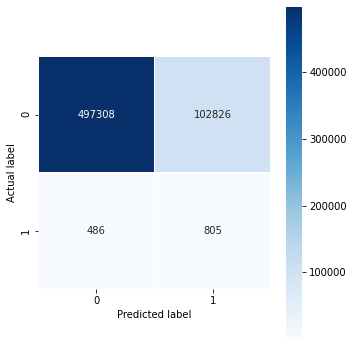

[0]	validation_0-aucpr:0.005653
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.005695
[2]	validation_0-aucpr:0.005593
[3]	validation_0-aucpr:0.005799
[4]	validation_0-aucpr:0.006672
[5]	validation_0-aucpr:0.006579
[6]	validation_0-aucpr:0.007358
[7]	validation_0-aucpr:0.007979
[8]	validation_0-aucpr:0.008187
[9]	validation_0-aucpr:0.008428
[10]	validation_0-aucpr:0.008512
[11]	validation_0-aucpr:0.008691
[12]	validation_0-aucpr:0.008727
[13]	validation_0-aucpr:0.0089
[14]	validation_0-aucpr:0.008906
[15]	validation_0-aucpr:0.008969
[16]	validation_0-aucpr:0.008916
[17]	validation_0-aucpr:0.009224
[18]	validation_0-aucpr:0.009107
[19]	validation_0-aucpr:0.009005
[20]	validation_0-aucpr:0.008941
[21]	validation_0-aucpr:0.009142
[22]	validation_0-aucpr:0.009352
[23]	validation_0-aucpr:0.009343
[24]	validation_0-aucpr:0.009549
[25]	validation_0-aucpr:0.00969
[26]	validation_0-aucpr:0.009342
[27]	validation_0-aucpr:0.009312
[28]	validation_0-aucpr

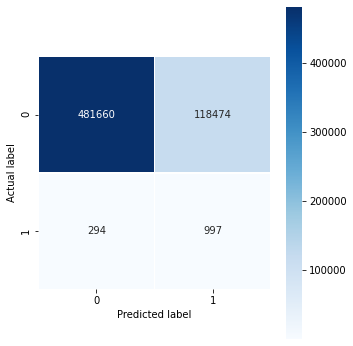

[0]	validation_0-aucpr:0.007997
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.008246
[2]	validation_0-aucpr:0.008209
[3]	validation_0-aucpr:0.008247
[4]	validation_0-aucpr:0.009515
[5]	validation_0-aucpr:0.013037
[6]	validation_0-aucpr:0.013867
[7]	validation_0-aucpr:0.015971
[8]	validation_0-aucpr:0.016262
[9]	validation_0-aucpr:0.017244
[10]	validation_0-aucpr:0.016369
[11]	validation_0-aucpr:0.017927
[12]	validation_0-aucpr:0.017233
[13]	validation_0-aucpr:0.015557
[14]	validation_0-aucpr:0.015408
[15]	validation_0-aucpr:0.014374
[16]	validation_0-aucpr:0.013233
[17]	validation_0-aucpr:0.014864
[18]	validation_0-aucpr:0.016184
[19]	validation_0-aucpr:0.017093
[20]	validation_0-aucpr:0.018227
[21]	validation_0-aucpr:0.01861
[22]	validation_0-aucpr:0.018215
[23]	validation_0-aucpr:0.018548
[24]	validation_0-aucpr:0.016931
[25]	validation_0-aucpr:0.01667
[26]	validation_0-aucpr:0.01527
[27]	validation_0-aucpr:0.015612
[28]	validation_0-aucpr

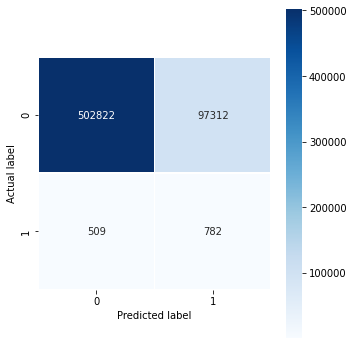

[0]	validation_0-aucpr:0.007603
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.007615
[2]	validation_0-aucpr:0.014863
[3]	validation_0-aucpr:0.014784
[4]	validation_0-aucpr:0.013325
[5]	validation_0-aucpr:0.014735
[6]	validation_0-aucpr:0.022741
[7]	validation_0-aucpr:0.024836
[8]	validation_0-aucpr:0.041277
[9]	validation_0-aucpr:0.036813
[10]	validation_0-aucpr:0.032636
[11]	validation_0-aucpr:0.033262
[12]	validation_0-aucpr:0.035227
[13]	validation_0-aucpr:0.033572
[14]	validation_0-aucpr:0.033631
[15]	validation_0-aucpr:0.046524
[16]	validation_0-aucpr:0.049379
[17]	validation_0-aucpr:0.04308
[18]	validation_0-aucpr:0.039656
[19]	validation_0-aucpr:0.036847
[20]	validation_0-aucpr:0.033082
[21]	validation_0-aucpr:0.036505
[22]	validation_0-aucpr:0.032247
[23]	validation_0-aucpr:0.031608
[24]	validation_0-aucpr:0.028285
[25]	validation_0-aucpr:0.028403
[26]	validation_0-aucpr:0.03122
Stopping. Best iteration:
[16]	validation_0-aucpr:0.049

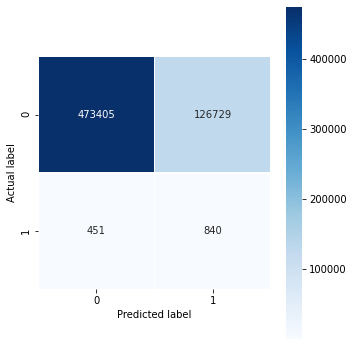

[0]	validation_0-aucpr:0.00566
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.005704
[2]	validation_0-aucpr:0.005696
[3]	validation_0-aucpr:0.006018
[4]	validation_0-aucpr:0.006323
[5]	validation_0-aucpr:0.006242
[6]	validation_0-aucpr:0.007277
[7]	validation_0-aucpr:0.007509
[8]	validation_0-aucpr:0.009362
[9]	validation_0-aucpr:0.010622
[10]	validation_0-aucpr:0.014152
[11]	validation_0-aucpr:0.014539
[12]	validation_0-aucpr:0.01494
[13]	validation_0-aucpr:0.01335
[14]	validation_0-aucpr:0.015883
[15]	validation_0-aucpr:0.015776
[16]	validation_0-aucpr:0.014425
[17]	validation_0-aucpr:0.014134
[18]	validation_0-aucpr:0.012903
[19]	validation_0-aucpr:0.012922
[20]	validation_0-aucpr:0.012763
[21]	validation_0-aucpr:0.013709
[22]	validation_0-aucpr:0.014664
[23]	validation_0-aucpr:0.015979
[24]	validation_0-aucpr:0.015863
[25]	validation_0-aucpr:0.015278
[26]	validation_0-aucpr:0.014847
[27]	validation_0-aucpr:0.015146
[28]	validation_0-aucpr

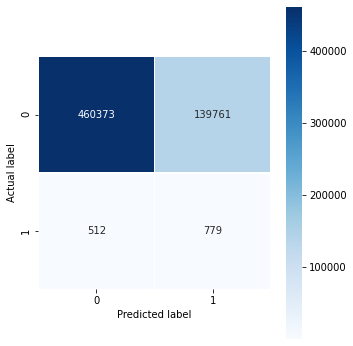

[0]	validation_0-aucpr:0.006742
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.00594
[2]	validation_0-aucpr:0.005512
[3]	validation_0-aucpr:0.005789
[4]	validation_0-aucpr:0.006726
[5]	validation_0-aucpr:0.00863
[6]	validation_0-aucpr:0.010234
[7]	validation_0-aucpr:0.010737
[8]	validation_0-aucpr:0.011347
[9]	validation_0-aucpr:0.011628
[10]	validation_0-aucpr:0.011093
[11]	validation_0-aucpr:0.011008
[12]	validation_0-aucpr:0.011153
[13]	validation_0-aucpr:0.012293
[14]	validation_0-aucpr:0.012497
[15]	validation_0-aucpr:0.013297
[16]	validation_0-aucpr:0.014178
[17]	validation_0-aucpr:0.014589
[18]	validation_0-aucpr:0.015121
[19]	validation_0-aucpr:0.015316
[20]	validation_0-aucpr:0.015544
[21]	validation_0-aucpr:0.016553
[22]	validation_0-aucpr:0.016884
[23]	validation_0-aucpr:0.016807
[24]	validation_0-aucpr:0.017044
[25]	validation_0-aucpr:0.016444
[26]	validation_0-aucpr:0.016668
[27]	validation_0-aucpr:0.017005
[28]	validation_0-aucp

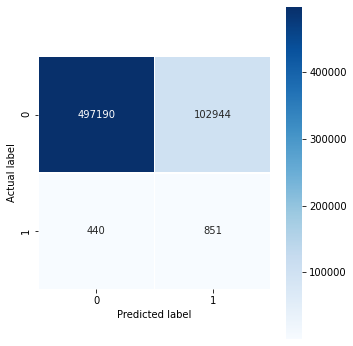

[0]	validation_0-aucpr:0.007299
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.007826
[2]	validation_0-aucpr:0.007896
[3]	validation_0-aucpr:0.007739
[4]	validation_0-aucpr:0.00834
[5]	validation_0-aucpr:0.0166
[6]	validation_0-aucpr:0.011118
[7]	validation_0-aucpr:0.013508
[8]	validation_0-aucpr:0.017587
[9]	validation_0-aucpr:0.018352
[10]	validation_0-aucpr:0.017001
[11]	validation_0-aucpr:0.022549
[12]	validation_0-aucpr:0.024847
[13]	validation_0-aucpr:0.024876
[14]	validation_0-aucpr:0.026457
[15]	validation_0-aucpr:0.025608
[16]	validation_0-aucpr:0.027237
[17]	validation_0-aucpr:0.030478
[18]	validation_0-aucpr:0.030358
[19]	validation_0-aucpr:0.034076
[20]	validation_0-aucpr:0.035672
[21]	validation_0-aucpr:0.030518
[22]	validation_0-aucpr:0.033103
[23]	validation_0-aucpr:0.033462
[24]	validation_0-aucpr:0.033295
[25]	validation_0-aucpr:0.034996
[26]	validation_0-aucpr:0.033874
[27]	validation_0-aucpr:0.034165
[28]	validation_0-aucpr

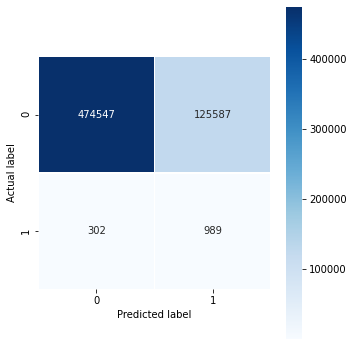

[0]	validation_0-aucpr:0.006832
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.010888
[2]	validation_0-aucpr:0.014251
[3]	validation_0-aucpr:0.014383
[4]	validation_0-aucpr:0.020819
[5]	validation_0-aucpr:0.016688
[6]	validation_0-aucpr:0.019674
[7]	validation_0-aucpr:0.024301
[8]	validation_0-aucpr:0.02634
[9]	validation_0-aucpr:0.022188
[10]	validation_0-aucpr:0.022805
[11]	validation_0-aucpr:0.037195
[12]	validation_0-aucpr:0.033056
[13]	validation_0-aucpr:0.038682
[14]	validation_0-aucpr:0.037934
[15]	validation_0-aucpr:0.042281
[16]	validation_0-aucpr:0.041688
[17]	validation_0-aucpr:0.046865
[18]	validation_0-aucpr:0.050805
[19]	validation_0-aucpr:0.051074
[20]	validation_0-aucpr:0.050671
[21]	validation_0-aucpr:0.054265
[22]	validation_0-aucpr:0.054937
[23]	validation_0-aucpr:0.056334
[24]	validation_0-aucpr:0.059367
[25]	validation_0-aucpr:0.059607
[26]	validation_0-aucpr:0.067529
[27]	validation_0-aucpr:0.071127
[28]	validation_0-auc

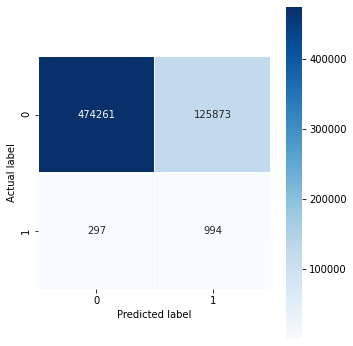

[0]	validation_0-aucpr:0.008762
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.008452
[2]	validation_0-aucpr:0.009755
[3]	validation_0-aucpr:0.009914
[4]	validation_0-aucpr:0.009904
[5]	validation_0-aucpr:0.012503
[6]	validation_0-aucpr:0.013066
[7]	validation_0-aucpr:0.012872
[8]	validation_0-aucpr:0.013129
[9]	validation_0-aucpr:0.014998
[10]	validation_0-aucpr:0.01494
[11]	validation_0-aucpr:0.014952
[12]	validation_0-aucpr:0.016567
[13]	validation_0-aucpr:0.016447
[14]	validation_0-aucpr:0.015988
[15]	validation_0-aucpr:0.016347
[16]	validation_0-aucpr:0.01752
[17]	validation_0-aucpr:0.017865
[18]	validation_0-aucpr:0.017768
[19]	validation_0-aucpr:0.018451
[20]	validation_0-aucpr:0.018779
[21]	validation_0-aucpr:0.019409
[22]	validation_0-aucpr:0.019356
[23]	validation_0-aucpr:0.019496
[24]	validation_0-aucpr:0.020219
[25]	validation_0-aucpr:0.02056
[26]	validation_0-aucpr:0.020674
[27]	validation_0-aucpr:0.020862
[28]	validation_0-aucpr

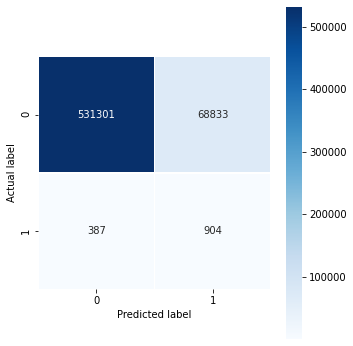

[0]	validation_0-aucpr:0.005636
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.007109
[2]	validation_0-aucpr:0.007989
[3]	validation_0-aucpr:0.007597
[4]	validation_0-aucpr:0.007629
[5]	validation_0-aucpr:0.007608
[6]	validation_0-aucpr:0.007535
[7]	validation_0-aucpr:0.007489
[8]	validation_0-aucpr:0.00761
[9]	validation_0-aucpr:0.007508
[10]	validation_0-aucpr:0.00819
[11]	validation_0-aucpr:0.008315
[12]	validation_0-aucpr:0.009106
[13]	validation_0-aucpr:0.011496
[14]	validation_0-aucpr:0.010706
[15]	validation_0-aucpr:0.012974
[16]	validation_0-aucpr:0.013776
[17]	validation_0-aucpr:0.014842
[18]	validation_0-aucpr:0.015249
[19]	validation_0-aucpr:0.014946
[20]	validation_0-aucpr:0.014076
[21]	validation_0-aucpr:0.014416
[22]	validation_0-aucpr:0.014397
[23]	validation_0-aucpr:0.01455
[24]	validation_0-aucpr:0.014409
[25]	validation_0-aucpr:0.014357
[26]	validation_0-aucpr:0.014889
[27]	validation_0-aucpr:0.017575
[28]	validation_0-aucpr

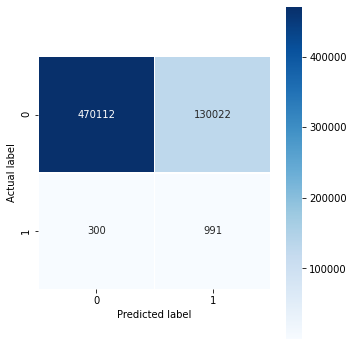

[0]	validation_0-aucpr:0.006627
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.006567
[2]	validation_0-aucpr:0.012403
[3]	validation_0-aucpr:0.012282
[4]	validation_0-aucpr:0.014581
[5]	validation_0-aucpr:0.020994
[6]	validation_0-aucpr:0.028389
[7]	validation_0-aucpr:0.03771
[8]	validation_0-aucpr:0.034731
[9]	validation_0-aucpr:0.047095
[10]	validation_0-aucpr:0.047675
[11]	validation_0-aucpr:0.046569
[12]	validation_0-aucpr:0.062247
[13]	validation_0-aucpr:0.077782
[14]	validation_0-aucpr:0.077393
[15]	validation_0-aucpr:0.066509
[16]	validation_0-aucpr:0.069179
[17]	validation_0-aucpr:0.069428
[18]	validation_0-aucpr:0.069472
[19]	validation_0-aucpr:0.067306
[20]	validation_0-aucpr:0.069849
[21]	validation_0-aucpr:0.086425
[22]	validation_0-aucpr:0.091573
[23]	validation_0-aucpr:0.092122
[24]	validation_0-aucpr:0.093447
[25]	validation_0-aucpr:0.091797
[26]	validation_0-aucpr:0.088764
[27]	validation_0-aucpr:0.082568
[28]	validation_0-auc

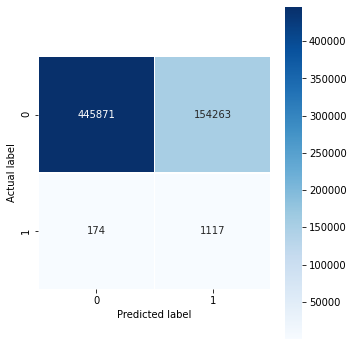

[0]	validation_0-aucpr:0.006284
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.007672
[2]	validation_0-aucpr:0.013822
[3]	validation_0-aucpr:0.013836
[4]	validation_0-aucpr:0.015169
[5]	validation_0-aucpr:0.01569
[6]	validation_0-aucpr:0.013503
[7]	validation_0-aucpr:0.015165
[8]	validation_0-aucpr:0.01501
[9]	validation_0-aucpr:0.015677
[10]	validation_0-aucpr:0.015031
[11]	validation_0-aucpr:0.015037
[12]	validation_0-aucpr:0.015605
[13]	validation_0-aucpr:0.022221
[14]	validation_0-aucpr:0.019008
[15]	validation_0-aucpr:0.017064
[16]	validation_0-aucpr:0.016533
[17]	validation_0-aucpr:0.017996
[18]	validation_0-aucpr:0.017959
[19]	validation_0-aucpr:0.017487
[20]	validation_0-aucpr:0.017653
[21]	validation_0-aucpr:0.017355
[22]	validation_0-aucpr:0.017386
[23]	validation_0-aucpr:0.017572
Stopping. Best iteration:
[13]	validation_0-aucpr:0.022221

Prediction Report of trial 29
               precision    recall  f1-score   support

        

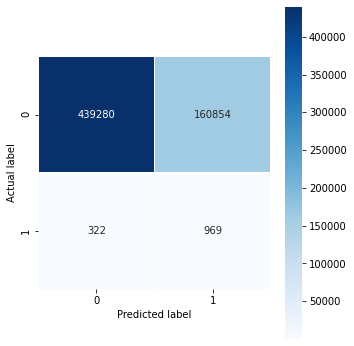

[0]	validation_0-aucpr:0.006764
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.007109
[2]	validation_0-aucpr:0.008798
[3]	validation_0-aucpr:0.015141
[4]	validation_0-aucpr:0.01546
[5]	validation_0-aucpr:0.01965
[6]	validation_0-aucpr:0.023986
[7]	validation_0-aucpr:0.025169
[8]	validation_0-aucpr:0.02592
[9]	validation_0-aucpr:0.026458
[10]	validation_0-aucpr:0.026711
[11]	validation_0-aucpr:0.027917
[12]	validation_0-aucpr:0.030199
[13]	validation_0-aucpr:0.044722
[14]	validation_0-aucpr:0.042197
[15]	validation_0-aucpr:0.043219
[16]	validation_0-aucpr:0.045836
[17]	validation_0-aucpr:0.044983
[18]	validation_0-aucpr:0.048643
[19]	validation_0-aucpr:0.045707
[20]	validation_0-aucpr:0.047241
[21]	validation_0-aucpr:0.045009
[22]	validation_0-aucpr:0.046336
[23]	validation_0-aucpr:0.046668
[24]	validation_0-aucpr:0.045909
[25]	validation_0-aucpr:0.046135
[26]	validation_0-aucpr:0.045938
[27]	validation_0-aucpr:0.047863
[28]	validation_0-aucpr

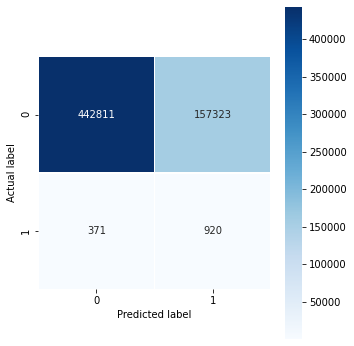

[0]	validation_0-aucpr:0.008355
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.010301
[2]	validation_0-aucpr:0.012478
[3]	validation_0-aucpr:0.014699
[4]	validation_0-aucpr:0.017115
[5]	validation_0-aucpr:0.014873
[6]	validation_0-aucpr:0.016829
[7]	validation_0-aucpr:0.016713
[8]	validation_0-aucpr:0.016248
[9]	validation_0-aucpr:0.019595
[10]	validation_0-aucpr:0.023281
[11]	validation_0-aucpr:0.019878
[12]	validation_0-aucpr:0.019976
[13]	validation_0-aucpr:0.020495
[14]	validation_0-aucpr:0.02724
[15]	validation_0-aucpr:0.029566
[16]	validation_0-aucpr:0.021964
[17]	validation_0-aucpr:0.02567
[18]	validation_0-aucpr:0.026551
[19]	validation_0-aucpr:0.024076
[20]	validation_0-aucpr:0.026289
[21]	validation_0-aucpr:0.027928
[22]	validation_0-aucpr:0.022561
[23]	validation_0-aucpr:0.02662
[24]	validation_0-aucpr:0.025926
[25]	validation_0-aucpr:0.022557
Stopping. Best iteration:
[15]	validation_0-aucpr:0.029566

Prediction Report of trial 31

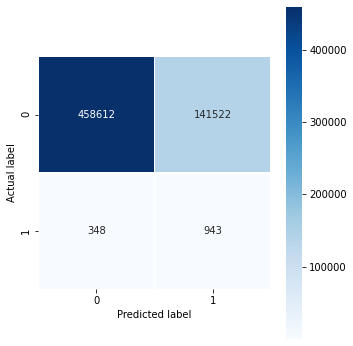

[0]	validation_0-aucpr:0.007631
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.00854
[2]	validation_0-aucpr:0.009671
[3]	validation_0-aucpr:0.011955
[4]	validation_0-aucpr:0.011788
[5]	validation_0-aucpr:0.011542
[6]	validation_0-aucpr:0.011851
[7]	validation_0-aucpr:0.012996
[8]	validation_0-aucpr:0.014092
[9]	validation_0-aucpr:0.014552
[10]	validation_0-aucpr:0.014724
[11]	validation_0-aucpr:0.017633
[12]	validation_0-aucpr:0.017408
[13]	validation_0-aucpr:0.019896
[14]	validation_0-aucpr:0.020236
[15]	validation_0-aucpr:0.020199
[16]	validation_0-aucpr:0.021125
[17]	validation_0-aucpr:0.02007
[18]	validation_0-aucpr:0.019714
[19]	validation_0-aucpr:0.021028
[20]	validation_0-aucpr:0.020906
[21]	validation_0-aucpr:0.020705
[22]	validation_0-aucpr:0.021607
[23]	validation_0-aucpr:0.021834
[24]	validation_0-aucpr:0.021513
[25]	validation_0-aucpr:0.021301
[26]	validation_0-aucpr:0.02102
[27]	validation_0-aucpr:0.021514
[28]	validation_0-aucpr

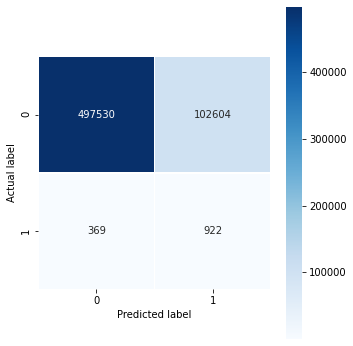

[0]	validation_0-aucpr:0.005851
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.005937
[2]	validation_0-aucpr:0.00604
[3]	validation_0-aucpr:0.005546
[4]	validation_0-aucpr:0.005744
[5]	validation_0-aucpr:0.005596
[6]	validation_0-aucpr:0.006107
[7]	validation_0-aucpr:0.005978
[8]	validation_0-aucpr:0.005967
[9]	validation_0-aucpr:0.006252
[10]	validation_0-aucpr:0.006496
[11]	validation_0-aucpr:0.008657
[12]	validation_0-aucpr:0.008995
[13]	validation_0-aucpr:0.009188
[14]	validation_0-aucpr:0.0091
[15]	validation_0-aucpr:0.010118
[16]	validation_0-aucpr:0.010233
[17]	validation_0-aucpr:0.010645
[18]	validation_0-aucpr:0.011396
[19]	validation_0-aucpr:0.010843
[20]	validation_0-aucpr:0.012168
[21]	validation_0-aucpr:0.012513
[22]	validation_0-aucpr:0.012353
[23]	validation_0-aucpr:0.012222
[24]	validation_0-aucpr:0.013586
[25]	validation_0-aucpr:0.013495
[26]	validation_0-aucpr:0.013428
[27]	validation_0-aucpr:0.013797
[28]	validation_0-aucpr

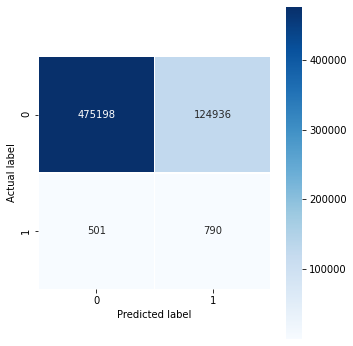

[0]	validation_0-aucpr:0.004931
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.008051
[2]	validation_0-aucpr:0.007863
[3]	validation_0-aucpr:0.008964
[4]	validation_0-aucpr:0.009605
[5]	validation_0-aucpr:0.009994
[6]	validation_0-aucpr:0.010272
[7]	validation_0-aucpr:0.010478
[8]	validation_0-aucpr:0.00948
[9]	validation_0-aucpr:0.009752
[10]	validation_0-aucpr:0.009732
[11]	validation_0-aucpr:0.010014
[12]	validation_0-aucpr:0.011722
[13]	validation_0-aucpr:0.012681
[14]	validation_0-aucpr:0.012748
[15]	validation_0-aucpr:0.012618
[16]	validation_0-aucpr:0.013106
[17]	validation_0-aucpr:0.01303
[18]	validation_0-aucpr:0.013751
[19]	validation_0-aucpr:0.01337
[20]	validation_0-aucpr:0.01446
[21]	validation_0-aucpr:0.013625
[22]	validation_0-aucpr:0.013745
[23]	validation_0-aucpr:0.013891
[24]	validation_0-aucpr:0.014165
[25]	validation_0-aucpr:0.013858
[26]	validation_0-aucpr:0.013643
[27]	validation_0-aucpr:0.013025
[28]	validation_0-aucpr:

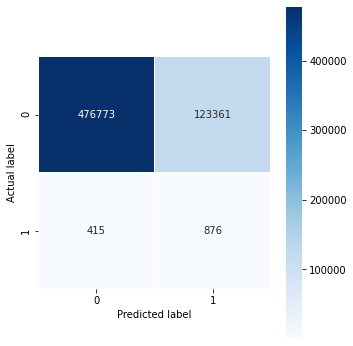

[0]	validation_0-aucpr:0.002246
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.002664
[2]	validation_0-aucpr:0.002813
[3]	validation_0-aucpr:0.003427
[4]	validation_0-aucpr:0.003549
[5]	validation_0-aucpr:0.004428
[6]	validation_0-aucpr:0.00377
[7]	validation_0-aucpr:0.004097
[8]	validation_0-aucpr:0.00402
[9]	validation_0-aucpr:0.004234
[10]	validation_0-aucpr:0.004423
[11]	validation_0-aucpr:0.004177
[12]	validation_0-aucpr:0.004204
[13]	validation_0-aucpr:0.004567
[14]	validation_0-aucpr:0.004946
[15]	validation_0-aucpr:0.004824
[16]	validation_0-aucpr:0.004953
[17]	validation_0-aucpr:0.004907
[18]	validation_0-aucpr:0.004873
[19]	validation_0-aucpr:0.004972
[20]	validation_0-aucpr:0.004919
[21]	validation_0-aucpr:0.005111
[22]	validation_0-aucpr:0.005197
[23]	validation_0-aucpr:0.005163
[24]	validation_0-aucpr:0.005141
[25]	validation_0-aucpr:0.005194
[26]	validation_0-aucpr:0.005666
[27]	validation_0-aucpr:0.005639
[28]	validation_0-aucp

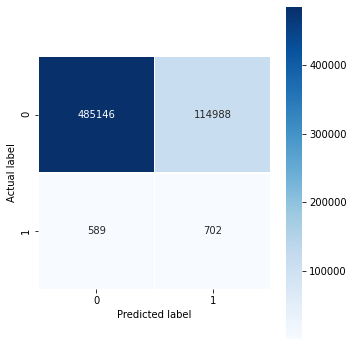

[0]	validation_0-aucpr:0.004093
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.005237
[2]	validation_0-aucpr:0.004167
[3]	validation_0-aucpr:0.006264
[4]	validation_0-aucpr:0.006799
[5]	validation_0-aucpr:0.007095
[6]	validation_0-aucpr:0.006375
[7]	validation_0-aucpr:0.006881
[8]	validation_0-aucpr:0.007854
[9]	validation_0-aucpr:0.008157
[10]	validation_0-aucpr:0.007281
[11]	validation_0-aucpr:0.009248
[12]	validation_0-aucpr:0.010456
[13]	validation_0-aucpr:0.009378
[14]	validation_0-aucpr:0.00999
[15]	validation_0-aucpr:0.011232
[16]	validation_0-aucpr:0.012221
[17]	validation_0-aucpr:0.01305
[18]	validation_0-aucpr:0.015811
[19]	validation_0-aucpr:0.014142
[20]	validation_0-aucpr:0.014071
[21]	validation_0-aucpr:0.015562
[22]	validation_0-aucpr:0.015821
[23]	validation_0-aucpr:0.017081
[24]	validation_0-aucpr:0.01788
[25]	validation_0-aucpr:0.019468
[26]	validation_0-aucpr:0.018279
[27]	validation_0-aucpr:0.019183
[28]	validation_0-aucpr

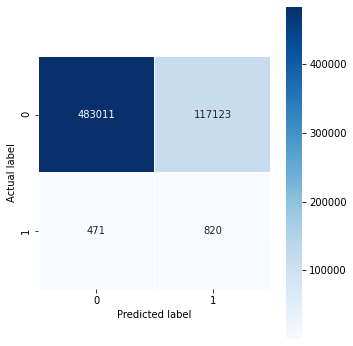

[0]	validation_0-aucpr:0.006282
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.007461
[2]	validation_0-aucpr:0.007046
[3]	validation_0-aucpr:0.007561
[4]	validation_0-aucpr:0.007701
[5]	validation_0-aucpr:0.008398
[6]	validation_0-aucpr:0.009129
[7]	validation_0-aucpr:0.009312
[8]	validation_0-aucpr:0.009615
[9]	validation_0-aucpr:0.009515
[10]	validation_0-aucpr:0.008535
[11]	validation_0-aucpr:0.009879
[12]	validation_0-aucpr:0.010457
[13]	validation_0-aucpr:0.010373
[14]	validation_0-aucpr:0.010337
[15]	validation_0-aucpr:0.011748
[16]	validation_0-aucpr:0.010441
[17]	validation_0-aucpr:0.008763
[18]	validation_0-aucpr:0.009036
[19]	validation_0-aucpr:0.009355
[20]	validation_0-aucpr:0.00988
[21]	validation_0-aucpr:0.009873
[22]	validation_0-aucpr:0.009505
[23]	validation_0-aucpr:0.010191
[24]	validation_0-aucpr:0.01074
[25]	validation_0-aucpr:0.010622
Stopping. Best iteration:
[15]	validation_0-aucpr:0.011748

Prediction Report of trial 3

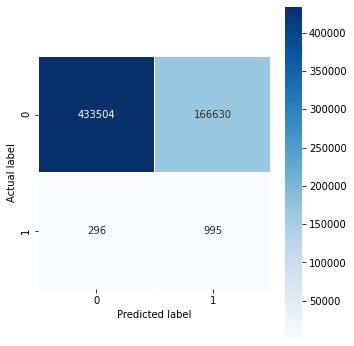

[0]	validation_0-aucpr:0.009299
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.009798
[2]	validation_0-aucpr:0.008767
[3]	validation_0-aucpr:0.008411
[4]	validation_0-aucpr:0.008618
[5]	validation_0-aucpr:0.009176
[6]	validation_0-aucpr:0.009343
[7]	validation_0-aucpr:0.010076
[8]	validation_0-aucpr:0.010605
[9]	validation_0-aucpr:0.010639
[10]	validation_0-aucpr:0.011519
[11]	validation_0-aucpr:0.011712
[12]	validation_0-aucpr:0.011372
[13]	validation_0-aucpr:0.012209
[14]	validation_0-aucpr:0.013257
[15]	validation_0-aucpr:0.017493
[16]	validation_0-aucpr:0.018604
[17]	validation_0-aucpr:0.019163
[18]	validation_0-aucpr:0.019942
[19]	validation_0-aucpr:0.020839
[20]	validation_0-aucpr:0.021381
[21]	validation_0-aucpr:0.02241
[22]	validation_0-aucpr:0.022517
[23]	validation_0-aucpr:0.022696
[24]	validation_0-aucpr:0.027722
[25]	validation_0-aucpr:0.030432
[26]	validation_0-aucpr:0.02919
[27]	validation_0-aucpr:0.027862
[28]	validation_0-aucp

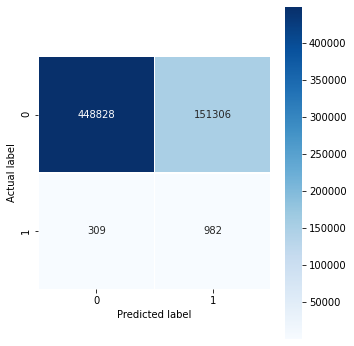

[0]	validation_0-aucpr:0.009956
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.0094
[2]	validation_0-aucpr:0.010031
[3]	validation_0-aucpr:0.011277
[4]	validation_0-aucpr:0.016857
[5]	validation_0-aucpr:0.016824
[6]	validation_0-aucpr:0.016889
[7]	validation_0-aucpr:0.017289
[8]	validation_0-aucpr:0.02638
[9]	validation_0-aucpr:0.027837
[10]	validation_0-aucpr:0.027508
[11]	validation_0-aucpr:0.028925
[12]	validation_0-aucpr:0.02922
[13]	validation_0-aucpr:0.028998
[14]	validation_0-aucpr:0.031367
[15]	validation_0-aucpr:0.03175
[16]	validation_0-aucpr:0.030693
[17]	validation_0-aucpr:0.034138
[18]	validation_0-aucpr:0.029713
[19]	validation_0-aucpr:0.028771
[20]	validation_0-aucpr:0.029666
[21]	validation_0-aucpr:0.028225
[22]	validation_0-aucpr:0.030692
[23]	validation_0-aucpr:0.030851
[24]	validation_0-aucpr:0.033748
[25]	validation_0-aucpr:0.034785
[26]	validation_0-aucpr:0.036026
[27]	validation_0-aucpr:0.035712
[28]	validation_0-aucpr:0

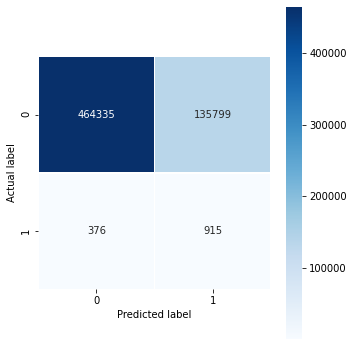

[0]	validation_0-aucpr:0.009711
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.010434
[2]	validation_0-aucpr:0.01078
[3]	validation_0-aucpr:0.012374
[4]	validation_0-aucpr:0.01215
[5]	validation_0-aucpr:0.014389
[6]	validation_0-aucpr:0.014337
[7]	validation_0-aucpr:0.017522
[8]	validation_0-aucpr:0.017304
[9]	validation_0-aucpr:0.020787
[10]	validation_0-aucpr:0.020796
[11]	validation_0-aucpr:0.020806
[12]	validation_0-aucpr:0.019622
[13]	validation_0-aucpr:0.019682
[14]	validation_0-aucpr:0.021402
[15]	validation_0-aucpr:0.021285
[16]	validation_0-aucpr:0.022082
[17]	validation_0-aucpr:0.021889
[18]	validation_0-aucpr:0.022192
[19]	validation_0-aucpr:0.024063
[20]	validation_0-aucpr:0.025255
[21]	validation_0-aucpr:0.025273
[22]	validation_0-aucpr:0.026275
[23]	validation_0-aucpr:0.025916
[24]	validation_0-aucpr:0.025617
[25]	validation_0-aucpr:0.02638
[26]	validation_0-aucpr:0.027998
[27]	validation_0-aucpr:0.028373
[28]	validation_0-aucpr

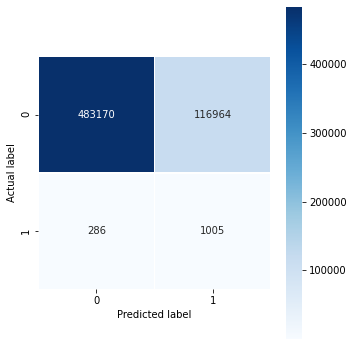

[0]	validation_0-aucpr:0.008084
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.008967
[2]	validation_0-aucpr:0.00912
[3]	validation_0-aucpr:0.01651
[4]	validation_0-aucpr:0.017415
[5]	validation_0-aucpr:0.026407
[6]	validation_0-aucpr:0.027088
[7]	validation_0-aucpr:0.027394
[8]	validation_0-aucpr:0.026732
[9]	validation_0-aucpr:0.025558
[10]	validation_0-aucpr:0.046547
[11]	validation_0-aucpr:0.044647
[12]	validation_0-aucpr:0.043563
[13]	validation_0-aucpr:0.043829
[14]	validation_0-aucpr:0.027772
[15]	validation_0-aucpr:0.030453
[16]	validation_0-aucpr:0.032426
[17]	validation_0-aucpr:0.033371
[18]	validation_0-aucpr:0.033399
[19]	validation_0-aucpr:0.033772
[20]	validation_0-aucpr:0.034133
Stopping. Best iteration:
[10]	validation_0-aucpr:0.046547

Prediction Report of trial 41
               precision    recall  f1-score   support

           0       1.00      0.76      0.86    600134
           1       0.01      0.73      0.01      1291

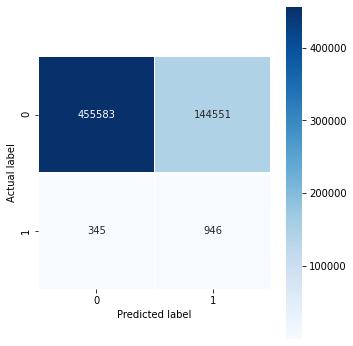

[0]	validation_0-aucpr:0.006518
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.007395
[2]	validation_0-aucpr:0.007401
[3]	validation_0-aucpr:0.017013
[4]	validation_0-aucpr:0.015666
[5]	validation_0-aucpr:0.018537
[6]	validation_0-aucpr:0.019661
[7]	validation_0-aucpr:0.019754
[8]	validation_0-aucpr:0.019682
[9]	validation_0-aucpr:0.020744
[10]	validation_0-aucpr:0.021385
[11]	validation_0-aucpr:0.021696
[12]	validation_0-aucpr:0.01594
[13]	validation_0-aucpr:0.020875
[14]	validation_0-aucpr:0.022059
[15]	validation_0-aucpr:0.026069
[16]	validation_0-aucpr:0.031825
[17]	validation_0-aucpr:0.032161
[18]	validation_0-aucpr:0.032835
[19]	validation_0-aucpr:0.032736
[20]	validation_0-aucpr:0.024656
[21]	validation_0-aucpr:0.022105
[22]	validation_0-aucpr:0.023761
[23]	validation_0-aucpr:0.022548
[24]	validation_0-aucpr:0.01829
[25]	validation_0-aucpr:0.019983
[26]	validation_0-aucpr:0.019297
[27]	validation_0-aucpr:0.019508
[28]	validation_0-aucp

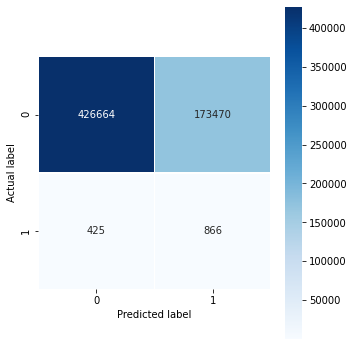

[0]	validation_0-aucpr:0.006641
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.009731
[2]	validation_0-aucpr:0.009816
[3]	validation_0-aucpr:0.009835
[4]	validation_0-aucpr:0.009884
[5]	validation_0-aucpr:0.009162
[6]	validation_0-aucpr:0.009169
[7]	validation_0-aucpr:0.009361
[8]	validation_0-aucpr:0.009484
[9]	validation_0-aucpr:0.009684
[10]	validation_0-aucpr:0.011761
[11]	validation_0-aucpr:0.017198
[12]	validation_0-aucpr:0.016802
[13]	validation_0-aucpr:0.01709
[14]	validation_0-aucpr:0.02036
[15]	validation_0-aucpr:0.020375
[16]	validation_0-aucpr:0.022693
[17]	validation_0-aucpr:0.023557
[18]	validation_0-aucpr:0.023624
[19]	validation_0-aucpr:0.023763
[20]	validation_0-aucpr:0.022401
[21]	validation_0-aucpr:0.021993
[22]	validation_0-aucpr:0.02289
[23]	validation_0-aucpr:0.022997
[24]	validation_0-aucpr:0.021954
[25]	validation_0-aucpr:0.02223
[26]	validation_0-aucpr:0.023565
[27]	validation_0-aucpr:0.024563
[28]	validation_0-aucpr:

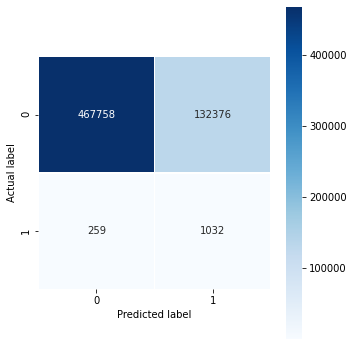

[0]	validation_0-aucpr:0.006248
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.006376
[2]	validation_0-aucpr:0.00633
[3]	validation_0-aucpr:0.006539
[4]	validation_0-aucpr:0.008542
[5]	validation_0-aucpr:0.009028
[6]	validation_0-aucpr:0.00893
[7]	validation_0-aucpr:0.009975
[8]	validation_0-aucpr:0.009962
[9]	validation_0-aucpr:0.010631
[10]	validation_0-aucpr:0.011062
[11]	validation_0-aucpr:0.01125
[12]	validation_0-aucpr:0.014206
[13]	validation_0-aucpr:0.014432
[14]	validation_0-aucpr:0.012949
[15]	validation_0-aucpr:0.012679
[16]	validation_0-aucpr:0.012275
[17]	validation_0-aucpr:0.012186
[18]	validation_0-aucpr:0.013115
[19]	validation_0-aucpr:0.013592
[20]	validation_0-aucpr:0.014447
[21]	validation_0-aucpr:0.014304
[22]	validation_0-aucpr:0.0136
[23]	validation_0-aucpr:0.014757
[24]	validation_0-aucpr:0.015069
[25]	validation_0-aucpr:0.01535
[26]	validation_0-aucpr:0.015578
[27]	validation_0-aucpr:0.016022
[28]	validation_0-aucpr:0.

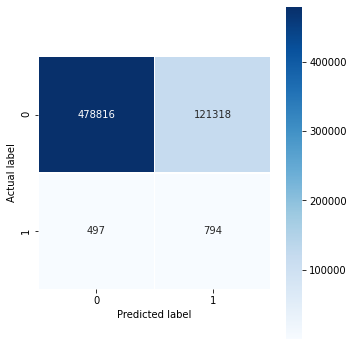

[0]	validation_0-aucpr:0.008132
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.008335
[2]	validation_0-aucpr:0.00861
[3]	validation_0-aucpr:0.008489
[4]	validation_0-aucpr:0.008426
[5]	validation_0-aucpr:0.01023
[6]	validation_0-aucpr:0.009433
[7]	validation_0-aucpr:0.008765
[8]	validation_0-aucpr:0.010929
[9]	validation_0-aucpr:0.011262
[10]	validation_0-aucpr:0.01507
[11]	validation_0-aucpr:0.014011
[12]	validation_0-aucpr:0.013659
[13]	validation_0-aucpr:0.014605
[14]	validation_0-aucpr:0.015489
[15]	validation_0-aucpr:0.015501
[16]	validation_0-aucpr:0.014769
[17]	validation_0-aucpr:0.015899
[18]	validation_0-aucpr:0.016957
[19]	validation_0-aucpr:0.017157
[20]	validation_0-aucpr:0.017226
[21]	validation_0-aucpr:0.016609
[22]	validation_0-aucpr:0.017174
[23]	validation_0-aucpr:0.017165
[24]	validation_0-aucpr:0.016117
[25]	validation_0-aucpr:0.016452
[26]	validation_0-aucpr:0.016178
[27]	validation_0-aucpr:0.015961
[28]	validation_0-aucpr

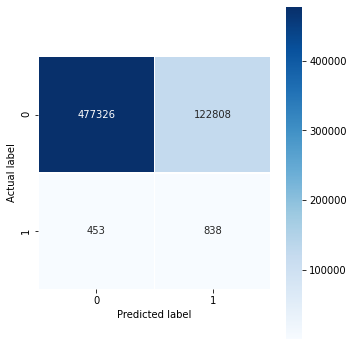

[0]	validation_0-aucpr:0.005863
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.005883
[2]	validation_0-aucpr:0.006583
[3]	validation_0-aucpr:0.006543
[4]	validation_0-aucpr:0.010011
[5]	validation_0-aucpr:0.010102
[6]	validation_0-aucpr:0.009999
[7]	validation_0-aucpr:0.010208
[8]	validation_0-aucpr:0.009975
[9]	validation_0-aucpr:0.009749
[10]	validation_0-aucpr:0.010343
[11]	validation_0-aucpr:0.010216
[12]	validation_0-aucpr:0.009543
[13]	validation_0-aucpr:0.009188
[14]	validation_0-aucpr:0.009133
[15]	validation_0-aucpr:0.009006
[16]	validation_0-aucpr:0.009424
[17]	validation_0-aucpr:0.009557
[18]	validation_0-aucpr:0.010147
[19]	validation_0-aucpr:0.01054
[20]	validation_0-aucpr:0.010436
[21]	validation_0-aucpr:0.01042
[22]	validation_0-aucpr:0.01078
[23]	validation_0-aucpr:0.012051
[24]	validation_0-aucpr:0.012126
[25]	validation_0-aucpr:0.011452
[26]	validation_0-aucpr:0.011368
[27]	validation_0-aucpr:0.011366
[28]	validation_0-aucpr

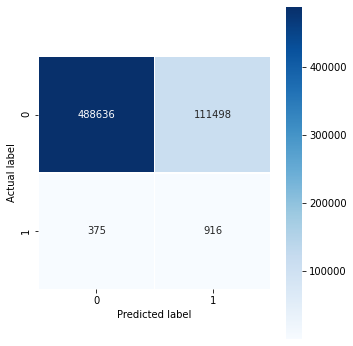

[0]	validation_0-aucpr:0.006056
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.007228
[2]	validation_0-aucpr:0.007436
[3]	validation_0-aucpr:0.007323
[4]	validation_0-aucpr:0.007342
[5]	validation_0-aucpr:0.008168
[6]	validation_0-aucpr:0.008699
[7]	validation_0-aucpr:0.008537
[8]	validation_0-aucpr:0.008569
[9]	validation_0-aucpr:0.00891
[10]	validation_0-aucpr:0.00942
[11]	validation_0-aucpr:0.011583
[12]	validation_0-aucpr:0.011388
[13]	validation_0-aucpr:0.011649
[14]	validation_0-aucpr:0.011649
[15]	validation_0-aucpr:0.011757
[16]	validation_0-aucpr:0.011557
[17]	validation_0-aucpr:0.013237
[18]	validation_0-aucpr:0.01326
[19]	validation_0-aucpr:0.013737
[20]	validation_0-aucpr:0.013552
[21]	validation_0-aucpr:0.015166
[22]	validation_0-aucpr:0.015118
[23]	validation_0-aucpr:0.015641
[24]	validation_0-aucpr:0.016092
[25]	validation_0-aucpr:0.016104
[26]	validation_0-aucpr:0.016428
[27]	validation_0-aucpr:0.016669
[28]	validation_0-aucpr

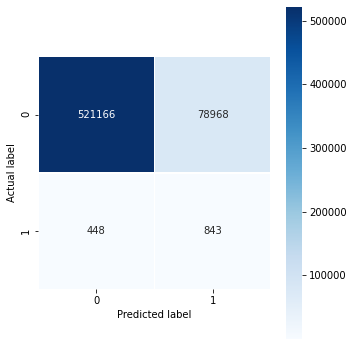

[0]	validation_0-aucpr:0.004857
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.005046
[2]	validation_0-aucpr:0.005068
[3]	validation_0-aucpr:0.00556
[4]	validation_0-aucpr:0.006191
[5]	validation_0-aucpr:0.006195
[6]	validation_0-aucpr:0.006289
[7]	validation_0-aucpr:0.006484
[8]	validation_0-aucpr:0.006745
[9]	validation_0-aucpr:0.006929
[10]	validation_0-aucpr:0.006868
[11]	validation_0-aucpr:0.006945
[12]	validation_0-aucpr:0.006986
[13]	validation_0-aucpr:0.007253
[14]	validation_0-aucpr:0.007339
[15]	validation_0-aucpr:0.007944
[16]	validation_0-aucpr:0.007814
[17]	validation_0-aucpr:0.008362
[18]	validation_0-aucpr:0.008399
[19]	validation_0-aucpr:0.008783
[20]	validation_0-aucpr:0.008665
[21]	validation_0-aucpr:0.009348
[22]	validation_0-aucpr:0.010747
[23]	validation_0-aucpr:0.011047
[24]	validation_0-aucpr:0.011635
[25]	validation_0-aucpr:0.012129
[26]	validation_0-aucpr:0.01263
[27]	validation_0-aucpr:0.013776
[28]	validation_0-aucp

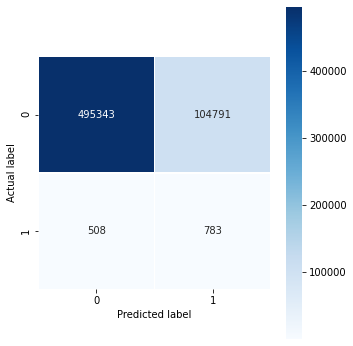

[0]	validation_0-aucpr:0.008152
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.009756
[2]	validation_0-aucpr:0.010281
[3]	validation_0-aucpr:0.01433
[4]	validation_0-aucpr:0.014799
[5]	validation_0-aucpr:0.020154
[6]	validation_0-aucpr:0.025236
[7]	validation_0-aucpr:0.024915
[8]	validation_0-aucpr:0.024912
[9]	validation_0-aucpr:0.027811
[10]	validation_0-aucpr:0.027417
[11]	validation_0-aucpr:0.028769
[12]	validation_0-aucpr:0.027315
[13]	validation_0-aucpr:0.029496
[14]	validation_0-aucpr:0.028657
[15]	validation_0-aucpr:0.029421
[16]	validation_0-aucpr:0.028973
[17]	validation_0-aucpr:0.042203
[18]	validation_0-aucpr:0.049303
[19]	validation_0-aucpr:0.052334
[20]	validation_0-aucpr:0.052765
[21]	validation_0-aucpr:0.054526
[22]	validation_0-aucpr:0.057716
[23]	validation_0-aucpr:0.057824
[24]	validation_0-aucpr:0.058341
[25]	validation_0-aucpr:0.056123
[26]	validation_0-aucpr:0.059894
[27]	validation_0-aucpr:0.059725
[28]	validation_0-auc

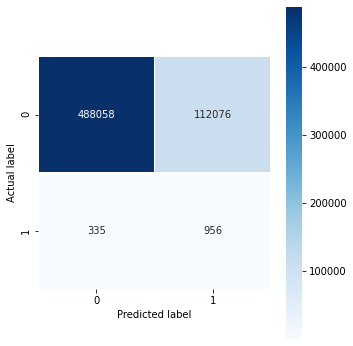

[0]	validation_0-aucpr:0.007622
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.007595
[2]	validation_0-aucpr:0.007819
[3]	validation_0-aucpr:0.008186
[4]	validation_0-aucpr:0.008079
[5]	validation_0-aucpr:0.008339
[6]	validation_0-aucpr:0.008301
[7]	validation_0-aucpr:0.008184
[8]	validation_0-aucpr:0.008187
[9]	validation_0-aucpr:0.008924
[10]	validation_0-aucpr:0.011541
[11]	validation_0-aucpr:0.011034
[12]	validation_0-aucpr:0.011066
[13]	validation_0-aucpr:0.011523
[14]	validation_0-aucpr:0.011696
[15]	validation_0-aucpr:0.011543
[16]	validation_0-aucpr:0.011906
[17]	validation_0-aucpr:0.012178
[18]	validation_0-aucpr:0.012646
[19]	validation_0-aucpr:0.013251
[20]	validation_0-aucpr:0.013633
[21]	validation_0-aucpr:0.014106
[22]	validation_0-aucpr:0.014255
[23]	validation_0-aucpr:0.015294
[24]	validation_0-aucpr:0.016156
[25]	validation_0-aucpr:0.017192
[26]	validation_0-aucpr:0.018188
[27]	validation_0-aucpr:0.018027
[28]	validation_0-au

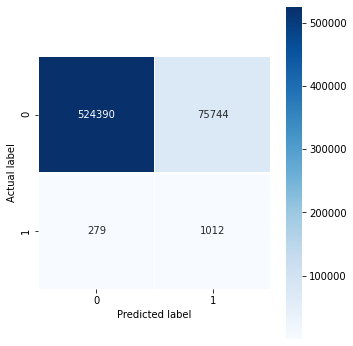

In [30]:
recall_0_list = []
recall_1_list = []
recall_avg_list = []

for trial in range(1, 51):
    random.seed(trial)
    
    random.shuffle(shuffled_flow_id_loss)
    random.shuffle(shuffled_flow_id_no_loss)
    
    df_loss_new = pd.concat([df_loss[df_loss['flow_id']==x] for x in shuffled_flow_id_loss])
    df_no_loss_new = pd.concat([df_no_loss[df_no_loss['flow_id']==x] for x in shuffled_flow_id_no_loss])
            
    df_train = pd.concat([df_loss_new.iloc[0:int(df_loss_new.shape[0] * 0.7)], df_no_loss_new.iloc[0:int(df_no_loss_new.shape[0] * 0.7)]])
    df_train_shuffled = df_train.sample(frac=1).reset_index()
    df_train_shuffled.drop(['index'], axis=1, inplace=True)
    df_test = pd.concat([df_loss_new.iloc[int(df_loss_new.shape[0] * 0.7)+1: -1], df_no_loss_new.iloc[int(df_no_loss_new.shape[0] * 0.7)+1: -1]])
    df_test_shuffled = df_test.sample(frac=1).reset_index()
    df_test_shuffled.drop(['index'], axis=1, inplace=True)

    x_train = df_train_shuffled[best_feature_list_removing_500ms]
    x_test = df_test_shuffled[best_feature_list_removing_500ms]
    y_train = df_train_shuffled[['lossOrNot']]
    y_train = y_train.astype(int)
    y_test = df_test_shuffled[['lossOrNot']]
    y_test = y_test.astype(int)
    
    clf_xgb_check = xgb.XGBClassifier(
        n_estimators=500, 
        objective='binary:logistic', 
        scale_pos_weight=weight, 
        n_jobs=48
    )
    
    clf_xgb_check.fit(x_train, y_train, early_stopping_rounds=10, eval_metric='aucpr', eval_set=[(x_test, y_test)])
            
    y_pred = clf_xgb_check.predict(x_test)
    print(f"Prediction Report of trial {trial}\n", classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,5))
    sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
    report = classification_report(y_test, y_pred, output_dict=True)
    recall_0_list.append(report['0']['recall'])
    recall_1_list.append(report['1']['recall'])
    recall_avg_list.append(report['macro avg']['recall'])

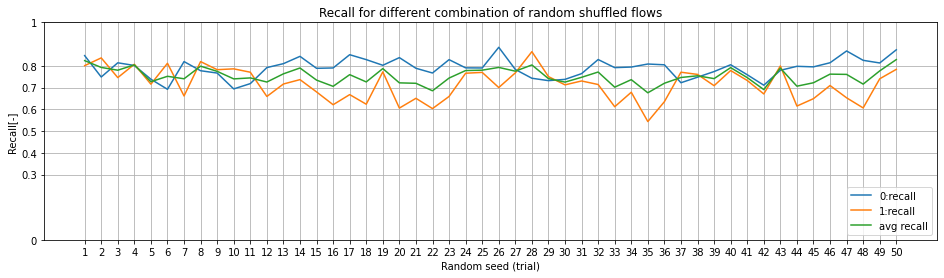

The best performance is at trial 1:
   recall of class 0: 0.847034162370404
   recall of class 1: 0.8009295120061968
   macro average recall: 0.8239818371883003
                 OR
The best performance is at trial 50:
   recall of class 0: 0.8737881873048352
   recall of class 1: 0.7838884585592564
   macro average recall: 0.8288383229320457


In [39]:
x_label = list(range(1,51))
plt.figure(figsize=(16,4))
plt.plot(x_label, recall_0_list, label='0:recall')
plt.plot(x_label, recall_1_list, label='1:recall')
plt.plot(x_label, recall_avg_list, label='avg recall')
plt.xticks(x_label, x_label)
plt.legend(loc=4)
plt.grid()
plt.ylim([0,1])
plt.yticks([0, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1], [0, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1])
plt.title('Recall for different combination of random shuffled flows')
plt.xlabel('Random seed (trial)')
plt.ylabel('Recall[-]')
plt.show()

print(f'The best performance is at trial 1:\n   recall of class 0: {recall_0_list[0]}\n   recall of class 1: {recall_1_list[0]}\n   macro average recall: {recall_avg_list[0]}')
print('                 OR')
print(f'The best performance is at trial 50:\n   recall of class 0: {recall_0_list[49]}\n   recall of class 1: {recall_1_list[49]}\n   macro average recall: {recall_avg_list[49]}')

In [41]:
# remove facebook and zoom

dfs = []

PATH = 'Retina/cisco_ml4qoe/data/antonio'
EXTENTION = '*_500ms_Song.csv'

for path, subdir, files in os.walk(PATH):
    for file in glob.glob(os.path.join(path, EXTENTION)):
        df = pd.read_csv(file)
        name = os.path.normpath(file)
        if ('facebook' not in name) and ('zoom' not in name):
            df['name'] = name
            dfs.append(df)
        
PATH = 'Retina/cisco_ml4qoe/data/dena/webex_teams'
EXTENTION = '*_500ms_Song.csv'

for path, subdir, files in os.walk(PATH):
    for file in glob.glob(os.path.join(path, EXTENTION)):
        df = pd.read_csv(file)
        df['name'] = os.path.normpath(file)
        dfs.append(df)
        
PATH = 'Retina/cisco_ml4qoe/data/dena/msteams'
EXTENTION = '*_clean_500ms_Song.csv'

for path, subdir, files in os.walk(PATH):
    for file in glob.glob(os.path.join(path, EXTENTION)):
        df = pd.read_csv(file)
        df['name'] = os.path.normpath(file)
        dfs.append(df)

In [42]:
scaler = preprocessing.MinMaxScaler() 

df_total = []
for df in dfs:    
    df_inter = copy.deepcopy(df)
    df_inter = df_inter.loc[~df_inter['ip_src'].str.startswith('192')]
    drop_col = [
        'software', 
        'label', 
        'pcap', 
        'ssrc', 
        'rtp_seq_num_packet_loss', 
        'ip_src', 
        'ip_dst', 
        'prt_src', 
        'prt_dst', 
        'rtp_csrc_csrc_agg',
        'p_type',
        'name'
    ]
    for col in df_inter.columns:
        if col in drop_col or col.startswith('rtp_interarrival'): 
            df_inter.drop(col, axis=1, inplace=True)
    
    flow_list = df_inter['flow'].drop_duplicates().tolist()
    for flow in flow_list:
        df_check = df_inter[df_inter['flow'] == flow].copy()
        if df_check.shape[0] > 10: 
            df_total.append(df_check)
            
df_total_final = []
for df_per_flow in df_total:
    df_temp = copy.deepcopy(df_per_flow)
    df_temp.reset_index(inplace=True)
    df_temp['lossOrNot'] = [1 if x>0 else 0 for x in df_temp['num_packet_loss']]
    df_temp.drop(['index', 'flow'], axis=1, inplace=True)
    df_temp['flow_id'] = flow_id
    flow_id += 1
    
    for col in df_temp.columns:
        if col not in ['timestamp', 'lossOrNot', 'num_packet_loss', 'flow_id']:
            df_temp[col] = scaler.fit_transform(df_temp[col].values.reshape(-1,1))
    
    start_time = pd.to_datetime(df_temp['timestamp'].min())
    stop_time = pd.to_datetime(df_temp['timestamp'].max())
    timestamp_ser = pd.date_range(start_time, stop_time, freq="500L")
    correct_len = len(timestamp_ser)
    
    if df_temp.shape[0] == correct_len:
        df_full = copy.deepcopy(df_temp)
        df_total_final.append(df_full)
    
    else:
        df_temp['timestamp'] = pd.to_datetime(df_temp['timestamp'])
        df_full = pd.DataFrame({'timestamp': timestamp_ser})
        df_full['timestamp'] = df_full['timestamp']
        df_full = df_full.merge(df_temp, on='timestamp', how='left')
        
        nan_index_list = [0]
        nan_index_list.extend(df_full[np.isnan(df_full['interarrival_std'])].index.tolist())
        nan_index_list.append(df_full.index[-1])
        
        for i in range(1, len(nan_index_list)):
            if nan_index_list[i] - nan_index_list[i-1] - 1 >= 11:
                start_idx = 0 if nan_index_list[i-1]==0 else nan_index_list[i-1]+1
                stop_idx = df_full.index[-1]+1 if nan_index_list[i]==df_full.index[-1] else nan_index_list[i]
                df_separate = df_full.iloc[start_idx:stop_idx, :].copy()
                df_separate.reset_index(inplace=True)
                df_separate.drop(['index'], axis=1, inplace=True)
                df_total_final.append(df_separate)

In [43]:
df_total_final_feature_extraction = []
for df in df_total_final:
    df_temp = copy.deepcopy(df)
    df_temp = df_temp[complete_list]
    for feature in possible_features_list:
        for i in range(2,11):
            col_title = f'{feature}_minus_{500*i}ms'
            df_temp[col_title] = df_temp[feature].shift(periods=i, fill_value=-1)
    df_temp.drop(possible_features_list, axis=1, inplace=True)
    df_temp = df_temp.iloc[10:]
    df_temp.reset_index(inplace=True)
    df_temp.drop(['index'], axis=1, inplace=True)
    
    df_total_final_feature_extraction.append(df_temp)

In [44]:
df_complete_with_features_final_new = pd.concat(df_total_final_feature_extraction)
df_complete_with_features_final_new.reset_index(inplace=True)
df_complete_with_features_final_new.drop(['index'], axis=1, inplace=True)
df_complete_with_features_final_new

lossOrNot  num_packet_loss  flow_id  interarrival_std_minus_1000ms  \
0             0.0              0.0   2883.0                       0.271190   
1             0.0              0.0   2883.0                       0.289070   
2             0.0              0.0   2883.0                       0.272142   
3             0.0              0.0   2883.0                       0.497283   
4             0.0              0.0   2883.0                       0.258600   
...           ...              ...      ...                            ...   
384160        0.0              0.0   3615.0                       0.068625   
384161        0.0              0.0   3615.0                       0.093816   
384162        0.0              0.0   3615.0                       0.018611   
384163        0.0              0.0   3615.0                       0.045165   
384164        0.0              0.0   3615.0                       0.063900   

        interarrival_std_minus_1500ms  interarrival_std_minus_2000ms  \
0                            0.266369                       0.246055   
1                            0.271190                       0.266369   
2                            0.289070                       0.271190   
3                            0.272142                       0.289070   
4                            0.497283                       0.272142   
...                               ...                            ...   
384160                       0.025666                       0.048300   
384161                       0.068625                       0.025666   
384162                       0.093816                       0.068625   
384163                       0.018611                       0.093816   
384164                       0.045165                       0.018611   

        interarrival_std_minus_2500ms  interarrival_std_minus_3000ms  \
0                            0.249518                       0.265138   
1                            0.246055                       0.249518   
2                            0.266369                       0.246055   
3                            0.271190                       0.266369   
4                            0.289070                       0.271190   
...                               ...                            ...   
384160                       0.052622                       0.073385   
384161                       0.048300                       0.052622   
384162                       0.025666                       0.048300   
384163                       0.068625                       0.025666   
384164                       0.093816                       0.068625   

        interarrival_std_minus_3500ms  interarrival_std_minus_4000ms  ...  \
0                            0.274706                       0.267305  ...   
1                            0.265138                       0.274706  ...   
2                            0.249518                       0.265138  ...   
3                            0.246055                       0.249518  ...   
4                            0.266369                       0.246055  ...   
...                               ...                            ...  ...   
384160                       0.132108                       0.057085  ...   
384161                       0.073385                       0.132108  ...   
384162                       0.052622                       0.073385  ...   
384163                       0.048300                       0.052622  ...   
384164                       0.025666                       0.048300  ...   

        inter_time_sequence_max_min_diff_minus_5000ms  \
0                                            0.022640   
1                                            0.716996   
2                                            0.237724   
3                                            0.226404   
4                                            0.716996   
...                                               ...   
384160           

In [45]:
df_final_check = pd.concat([df_complete_with_all_possible_features_final_with_num_packet_loss, df_complete_with_features_final_new])

In [46]:
df_loss = df_final_check[df_final_check['num_packet_loss'] > 2]
df_no_loss = df_final_check[df_final_check['num_packet_loss'] == 0]

In [48]:
weight = len(df_no_loss) / len(df_loss)
weight

129.9528937486194

In [47]:
flow_id_loss = df_loss['flow_id'].drop_duplicates().tolist()
flow_id_no_loss = df_no_loss['flow_id'].drop_duplicates().tolist()
shuffled_flow_id_loss = flow_id_loss.copy()
shuffled_flow_id_no_loss = flow_id_no_loss.copy()

[0]	validation_0-aucpr:0.021813
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.028145
[2]	validation_0-aucpr:0.029724
[3]	validation_0-aucpr:0.039694
[4]	validation_0-aucpr:0.040697
[5]	validation_0-aucpr:0.042377
[6]	validation_0-aucpr:0.045998
[7]	validation_0-aucpr:0.043806
[8]	validation_0-aucpr:0.045893
[9]	validation_0-aucpr:0.049108
[10]	validation_0-aucpr:0.050793
[11]	validation_0-aucpr:0.051024
[12]	validation_0-aucpr:0.05404
[13]	validation_0-aucpr:0.052765
[14]	validation_0-aucpr:0.052019
[15]	validation_0-aucpr:0.052605
[16]	validation_0-aucpr:0.053237
[17]	validation_0-aucpr:0.054313
[18]	validation_0-aucpr:0.056131
[19]	validation_0-aucpr:0.057395
[20]	validation_0-aucpr:0.057887
[21]	validation_0-aucpr:0.056325
[22]	validation_0-aucpr:0.056991
[23]	validation_0-aucpr:0.057576
[24]	validation_0-aucpr:0.056595
[25]	validation_0-aucpr:0.057369
[26]	validation_0-aucpr:0.058343
[27]	validation_0-aucpr:0.05919
[28]	validation_0-aucp

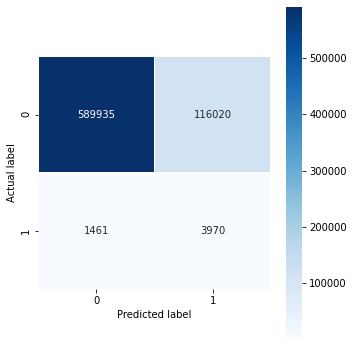

[0]	validation_0-aucpr:0.026201
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.027818
[2]	validation_0-aucpr:0.036302
[3]	validation_0-aucpr:0.034284
[4]	validation_0-aucpr:0.038742
[5]	validation_0-aucpr:0.055269
[6]	validation_0-aucpr:0.054891
[7]	validation_0-aucpr:0.053644
[8]	validation_0-aucpr:0.05415
[9]	validation_0-aucpr:0.054708
[10]	validation_0-aucpr:0.057736
[11]	validation_0-aucpr:0.05618
[12]	validation_0-aucpr:0.055133
[13]	validation_0-aucpr:0.067644
[14]	validation_0-aucpr:0.070746
[15]	validation_0-aucpr:0.071114
[16]	validation_0-aucpr:0.073301
[17]	validation_0-aucpr:0.083858
[18]	validation_0-aucpr:0.07772
[19]	validation_0-aucpr:0.076167
[20]	validation_0-aucpr:0.080328
[21]	validation_0-aucpr:0.07703
[22]	validation_0-aucpr:0.075791
[23]	validation_0-aucpr:0.069515
[24]	validation_0-aucpr:0.07174
[25]	validation_0-aucpr:0.072747
[26]	validation_0-aucpr:0.07019
[27]	validation_0-aucpr:0.074532
Stopping. Best iteration:


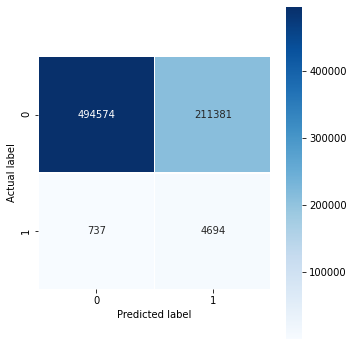

[0]	validation_0-aucpr:0.02775
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.030206
[2]	validation_0-aucpr:0.036133
[3]	validation_0-aucpr:0.038205
[4]	validation_0-aucpr:0.046577
[5]	validation_0-aucpr:0.043535
[6]	validation_0-aucpr:0.050331
[7]	validation_0-aucpr:0.055341
[8]	validation_0-aucpr:0.056436
[9]	validation_0-aucpr:0.057465
[10]	validation_0-aucpr:0.059701
[11]	validation_0-aucpr:0.060765
[12]	validation_0-aucpr:0.056604
[13]	validation_0-aucpr:0.056515
[14]	validation_0-aucpr:0.061019
[15]	validation_0-aucpr:0.06152
[16]	validation_0-aucpr:0.064957
[17]	validation_0-aucpr:0.06787
[18]	validation_0-aucpr:0.067593
[19]	validation_0-aucpr:0.075723
[20]	validation_0-aucpr:0.073843
[21]	validation_0-aucpr:0.087957
[22]	validation_0-aucpr:0.087059
[23]	validation_0-aucpr:0.08757
[24]	validation_0-aucpr:0.087139
[25]	validation_0-aucpr:0.089848
[26]	validation_0-aucpr:0.09289
[27]	validation_0-aucpr:0.093408
[28]	validation_0-aucpr:0

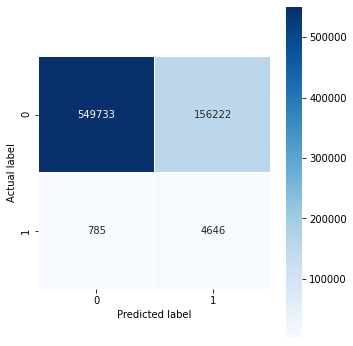

[0]	validation_0-aucpr:0.013889
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.01904
[2]	validation_0-aucpr:0.018264
[3]	validation_0-aucpr:0.017313
[4]	validation_0-aucpr:0.023053
[5]	validation_0-aucpr:0.021974
[6]	validation_0-aucpr:0.026496
[7]	validation_0-aucpr:0.027845
[8]	validation_0-aucpr:0.028866
[9]	validation_0-aucpr:0.02925
[10]	validation_0-aucpr:0.032727
[11]	validation_0-aucpr:0.033887
[12]	validation_0-aucpr:0.034444
[13]	validation_0-aucpr:0.03198
[14]	validation_0-aucpr:0.032426
[15]	validation_0-aucpr:0.0338
[16]	validation_0-aucpr:0.035618
[17]	validation_0-aucpr:0.035304
[18]	validation_0-aucpr:0.033895
[19]	validation_0-aucpr:0.033994
[20]	validation_0-aucpr:0.033538
[21]	validation_0-aucpr:0.034054
[22]	validation_0-aucpr:0.03983
[23]	validation_0-aucpr:0.04273
[24]	validation_0-aucpr:0.043351
[25]	validation_0-aucpr:0.048027
[26]	validation_0-aucpr:0.049666
[27]	validation_0-aucpr:0.049478
[28]	validation_0-aucpr:0.0

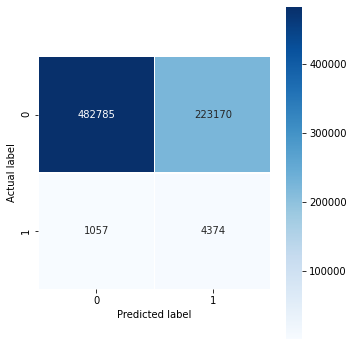

[0]	validation_0-aucpr:0.020987
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.030563
[2]	validation_0-aucpr:0.030717
[3]	validation_0-aucpr:0.036253
[4]	validation_0-aucpr:0.037149
[5]	validation_0-aucpr:0.039508
[6]	validation_0-aucpr:0.039902
[7]	validation_0-aucpr:0.043288
[8]	validation_0-aucpr:0.043833
[9]	validation_0-aucpr:0.046727
[10]	validation_0-aucpr:0.049245
[11]	validation_0-aucpr:0.055641
[12]	validation_0-aucpr:0.057844
[13]	validation_0-aucpr:0.056866
[14]	validation_0-aucpr:0.058539
[15]	validation_0-aucpr:0.061539
[16]	validation_0-aucpr:0.064681
[17]	validation_0-aucpr:0.063907
[18]	validation_0-aucpr:0.06735
[19]	validation_0-aucpr:0.071776
[20]	validation_0-aucpr:0.070593
[21]	validation_0-aucpr:0.070706
[22]	validation_0-aucpr:0.074113
[23]	validation_0-aucpr:0.07504
[24]	validation_0-aucpr:0.075767
[25]	validation_0-aucpr:0.076232
[26]	validation_0-aucpr:0.078067
[27]	validation_0-aucpr:0.078231
[28]	validation_0-aucp

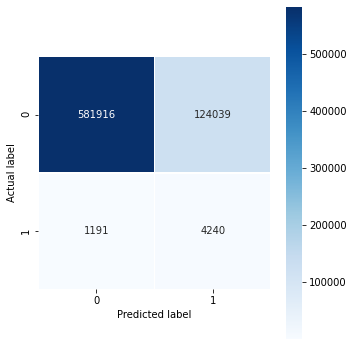

[0]	validation_0-aucpr:0.018686
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.020125
[2]	validation_0-aucpr:0.021481
[3]	validation_0-aucpr:0.022649
[4]	validation_0-aucpr:0.025497
[5]	validation_0-aucpr:0.02875
[6]	validation_0-aucpr:0.028755
[7]	validation_0-aucpr:0.03406
[8]	validation_0-aucpr:0.034408
[9]	validation_0-aucpr:0.033032
[10]	validation_0-aucpr:0.031689
[11]	validation_0-aucpr:0.03477
[12]	validation_0-aucpr:0.036563
[13]	validation_0-aucpr:0.035571
[14]	validation_0-aucpr:0.035956
[15]	validation_0-aucpr:0.038675
[16]	validation_0-aucpr:0.039516
[17]	validation_0-aucpr:0.039604
[18]	validation_0-aucpr:0.039411
[19]	validation_0-aucpr:0.040411
[20]	validation_0-aucpr:0.042988
[21]	validation_0-aucpr:0.042789
[22]	validation_0-aucpr:0.043699
[23]	validation_0-aucpr:0.045711
[24]	validation_0-aucpr:0.047377
[25]	validation_0-aucpr:0.04691
[26]	validation_0-aucpr:0.046678
[27]	validation_0-aucpr:0.047149
[28]	validation_0-aucpr:

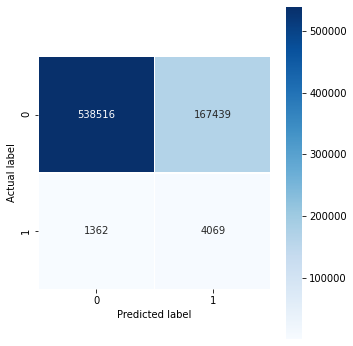

[0]	validation_0-aucpr:0.026818
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.029997
[2]	validation_0-aucpr:0.02636
[3]	validation_0-aucpr:0.026425
[4]	validation_0-aucpr:0.03326
[5]	validation_0-aucpr:0.036744
[6]	validation_0-aucpr:0.040583
[7]	validation_0-aucpr:0.044472
[8]	validation_0-aucpr:0.049263
[9]	validation_0-aucpr:0.057793
[10]	validation_0-aucpr:0.063911
[11]	validation_0-aucpr:0.06061
[12]	validation_0-aucpr:0.06104
[13]	validation_0-aucpr:0.058313
[14]	validation_0-aucpr:0.063135
[15]	validation_0-aucpr:0.063979
[16]	validation_0-aucpr:0.064564
[17]	validation_0-aucpr:0.06416
[18]	validation_0-aucpr:0.06583
[19]	validation_0-aucpr:0.064913
[20]	validation_0-aucpr:0.064677
[21]	validation_0-aucpr:0.066978
[22]	validation_0-aucpr:0.06446
[23]	validation_0-aucpr:0.064195
[24]	validation_0-aucpr:0.066363
[25]	validation_0-aucpr:0.068762
[26]	validation_0-aucpr:0.067649
[27]	validation_0-aucpr:0.069654
[28]	validation_0-aucpr:0.0

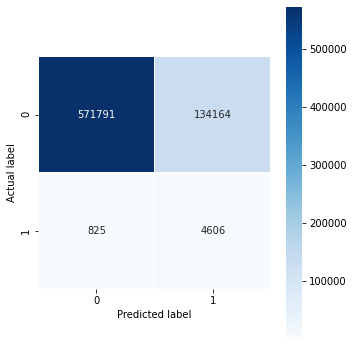

[0]	validation_0-aucpr:0.027039
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.028612
[2]	validation_0-aucpr:0.029662
[3]	validation_0-aucpr:0.031313
[4]	validation_0-aucpr:0.036056
[5]	validation_0-aucpr:0.03707
[6]	validation_0-aucpr:0.040532
[7]	validation_0-aucpr:0.043074
[8]	validation_0-aucpr:0.048322
[9]	validation_0-aucpr:0.05533
[10]	validation_0-aucpr:0.058083
[11]	validation_0-aucpr:0.063427
[12]	validation_0-aucpr:0.066854
[13]	validation_0-aucpr:0.070236
[14]	validation_0-aucpr:0.072707
[15]	validation_0-aucpr:0.073507
[16]	validation_0-aucpr:0.069577
[17]	validation_0-aucpr:0.074809
[18]	validation_0-aucpr:0.078176
[19]	validation_0-aucpr:0.081081
[20]	validation_0-aucpr:0.081614
[21]	validation_0-aucpr:0.084156
[22]	validation_0-aucpr:0.08462
[23]	validation_0-aucpr:0.085498
[24]	validation_0-aucpr:0.085327
[25]	validation_0-aucpr:0.086071
[26]	validation_0-aucpr:0.087041
[27]	validation_0-aucpr:0.085589
[28]	validation_0-aucpr

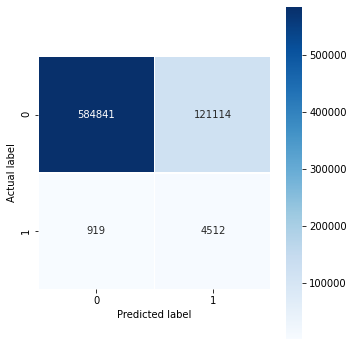

[0]	validation_0-aucpr:0.019998
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.024059
[2]	validation_0-aucpr:0.027916
[3]	validation_0-aucpr:0.031607
[4]	validation_0-aucpr:0.028979
[5]	validation_0-aucpr:0.029288
[6]	validation_0-aucpr:0.030969
[7]	validation_0-aucpr:0.032488
[8]	validation_0-aucpr:0.034958
[9]	validation_0-aucpr:0.037842
[10]	validation_0-aucpr:0.037779
[11]	validation_0-aucpr:0.038153
[12]	validation_0-aucpr:0.041722
[13]	validation_0-aucpr:0.041417
[14]	validation_0-aucpr:0.041474
[15]	validation_0-aucpr:0.040383
[16]	validation_0-aucpr:0.043001
[17]	validation_0-aucpr:0.042883
[18]	validation_0-aucpr:0.042008
[19]	validation_0-aucpr:0.042388
[20]	validation_0-aucpr:0.040661
[21]	validation_0-aucpr:0.040809
[22]	validation_0-aucpr:0.041406
[23]	validation_0-aucpr:0.04104
[24]	validation_0-aucpr:0.039884
[25]	validation_0-aucpr:0.041531
[26]	validation_0-aucpr:0.041533
Stopping. Best iteration:
[16]	validation_0-aucpr:0.04

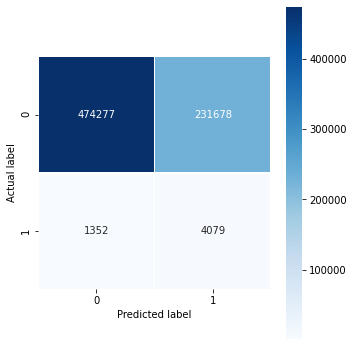

[0]	validation_0-aucpr:0.016646
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.016631
[2]	validation_0-aucpr:0.017194
[3]	validation_0-aucpr:0.017174
[4]	validation_0-aucpr:0.01811
[5]	validation_0-aucpr:0.019601
[6]	validation_0-aucpr:0.01918
[7]	validation_0-aucpr:0.020931
[8]	validation_0-aucpr:0.019406
[9]	validation_0-aucpr:0.020901
[10]	validation_0-aucpr:0.021353
[11]	validation_0-aucpr:0.022885
[12]	validation_0-aucpr:0.023621
[13]	validation_0-aucpr:0.024442
[14]	validation_0-aucpr:0.025574
[15]	validation_0-aucpr:0.026833
[16]	validation_0-aucpr:0.027176
[17]	validation_0-aucpr:0.028788
[18]	validation_0-aucpr:0.029264
[19]	validation_0-aucpr:0.029149
[20]	validation_0-aucpr:0.029534
[21]	validation_0-aucpr:0.029925
[22]	validation_0-aucpr:0.03138
[23]	validation_0-aucpr:0.031505
[24]	validation_0-aucpr:0.031438
[25]	validation_0-aucpr:0.032761
[26]	validation_0-aucpr:0.032636
[27]	validation_0-aucpr:0.032913
[28]	validation_0-aucpr

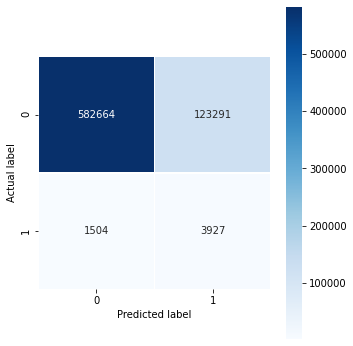

[0]	validation_0-aucpr:0.020105
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.02596
[2]	validation_0-aucpr:0.031307
[3]	validation_0-aucpr:0.033122
[4]	validation_0-aucpr:0.034122
[5]	validation_0-aucpr:0.033816
[6]	validation_0-aucpr:0.03667
[7]	validation_0-aucpr:0.037269
[8]	validation_0-aucpr:0.038474
[9]	validation_0-aucpr:0.043952
[10]	validation_0-aucpr:0.043458
[11]	validation_0-aucpr:0.041538
[12]	validation_0-aucpr:0.041575
[13]	validation_0-aucpr:0.044273
[14]	validation_0-aucpr:0.042138
[15]	validation_0-aucpr:0.04165
[16]	validation_0-aucpr:0.041028
[17]	validation_0-aucpr:0.041421
[18]	validation_0-aucpr:0.043162
[19]	validation_0-aucpr:0.042504
[20]	validation_0-aucpr:0.043693
[21]	validation_0-aucpr:0.042702
[22]	validation_0-aucpr:0.040941
[23]	validation_0-aucpr:0.04164
Stopping. Best iteration:
[13]	validation_0-aucpr:0.044273

Prediction Report of trial 11
               precision    recall  f1-score   support

          

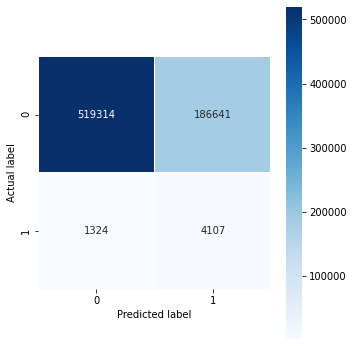

[0]	validation_0-aucpr:0.017174
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.018533
[2]	validation_0-aucpr:0.021079
[3]	validation_0-aucpr:0.022973
[4]	validation_0-aucpr:0.023701
[5]	validation_0-aucpr:0.024482
[6]	validation_0-aucpr:0.024051
[7]	validation_0-aucpr:0.024066
[8]	validation_0-aucpr:0.026373
[9]	validation_0-aucpr:0.027286
[10]	validation_0-aucpr:0.028734
[11]	validation_0-aucpr:0.02838
[12]	validation_0-aucpr:0.030586
[13]	validation_0-aucpr:0.03234
[14]	validation_0-aucpr:0.03303
[15]	validation_0-aucpr:0.034541
[16]	validation_0-aucpr:0.03367
[17]	validation_0-aucpr:0.03571
[18]	validation_0-aucpr:0.038184
[19]	validation_0-aucpr:0.03824
[20]	validation_0-aucpr:0.039036
[21]	validation_0-aucpr:0.042433
[22]	validation_0-aucpr:0.041429
[23]	validation_0-aucpr:0.041441
[24]	validation_0-aucpr:0.041172
[25]	validation_0-aucpr:0.044232
[26]	validation_0-aucpr:0.043836
[27]	validation_0-aucpr:0.044311
[28]	validation_0-aucpr:0.

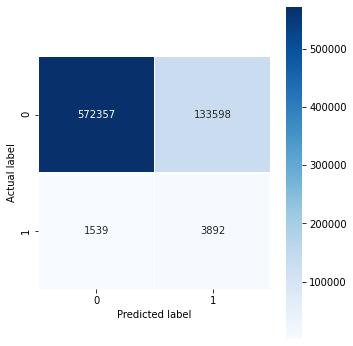

[0]	validation_0-aucpr:0.017842
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.01895
[2]	validation_0-aucpr:0.021024
[3]	validation_0-aucpr:0.020856
[4]	validation_0-aucpr:0.021481
[5]	validation_0-aucpr:0.021257
[6]	validation_0-aucpr:0.021955
[7]	validation_0-aucpr:0.022588
[8]	validation_0-aucpr:0.025788
[9]	validation_0-aucpr:0.025537
[10]	validation_0-aucpr:0.026462
[11]	validation_0-aucpr:0.02697
[12]	validation_0-aucpr:0.027129
[13]	validation_0-aucpr:0.027061
[14]	validation_0-aucpr:0.028163
[15]	validation_0-aucpr:0.028807
[16]	validation_0-aucpr:0.029315
[17]	validation_0-aucpr:0.02972
[18]	validation_0-aucpr:0.030532
[19]	validation_0-aucpr:0.031723
[20]	validation_0-aucpr:0.030943
[21]	validation_0-aucpr:0.031313
[22]	validation_0-aucpr:0.031839
[23]	validation_0-aucpr:0.032454
[24]	validation_0-aucpr:0.031965
[25]	validation_0-aucpr:0.032254
[26]	validation_0-aucpr:0.033308
[27]	validation_0-aucpr:0.034045
[28]	validation_0-aucpr

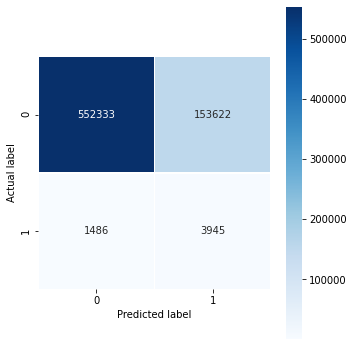

[0]	validation_0-aucpr:0.016458
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.017434
[2]	validation_0-aucpr:0.020844
[3]	validation_0-aucpr:0.022213
[4]	validation_0-aucpr:0.023015
[5]	validation_0-aucpr:0.023472
[6]	validation_0-aucpr:0.023959
[7]	validation_0-aucpr:0.025336
[8]	validation_0-aucpr:0.026131
[9]	validation_0-aucpr:0.026485
[10]	validation_0-aucpr:0.026909
[11]	validation_0-aucpr:0.029132
[12]	validation_0-aucpr:0.029542
[13]	validation_0-aucpr:0.030399
[14]	validation_0-aucpr:0.03295
[15]	validation_0-aucpr:0.033038
[16]	validation_0-aucpr:0.033126
[17]	validation_0-aucpr:0.034212
[18]	validation_0-aucpr:0.034295
[19]	validation_0-aucpr:0.034399
[20]	validation_0-aucpr:0.036206
[21]	validation_0-aucpr:0.036387
[22]	validation_0-aucpr:0.03661
[23]	validation_0-aucpr:0.039488
[24]	validation_0-aucpr:0.038494
[25]	validation_0-aucpr:0.038397
[26]	validation_0-aucpr:0.03914
[27]	validation_0-aucpr:0.039245
[28]	validation_0-aucpr

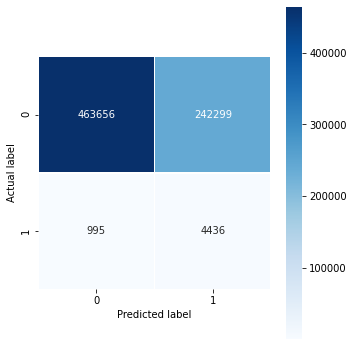

[0]	validation_0-aucpr:0.023443
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.024052
[2]	validation_0-aucpr:0.032887
[3]	validation_0-aucpr:0.027238
[4]	validation_0-aucpr:0.029473
[5]	validation_0-aucpr:0.031397
[6]	validation_0-aucpr:0.031215
[7]	validation_0-aucpr:0.038481
[8]	validation_0-aucpr:0.044294
[9]	validation_0-aucpr:0.044064
[10]	validation_0-aucpr:0.044032
[11]	validation_0-aucpr:0.048644
[12]	validation_0-aucpr:0.056852
[13]	validation_0-aucpr:0.054261
[14]	validation_0-aucpr:0.050712
[15]	validation_0-aucpr:0.058193
[16]	validation_0-aucpr:0.061642
[17]	validation_0-aucpr:0.061929
[18]	validation_0-aucpr:0.062325
[19]	validation_0-aucpr:0.061034
[20]	validation_0-aucpr:0.057958
[21]	validation_0-aucpr:0.06033
[22]	validation_0-aucpr:0.066218
[23]	validation_0-aucpr:0.066626
[24]	validation_0-aucpr:0.062907
[25]	validation_0-aucpr:0.063808
[26]	validation_0-aucpr:0.069668
[27]	validation_0-aucpr:0.06778
[28]	validation_0-aucp

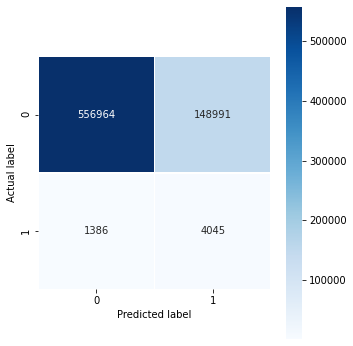

[0]	validation_0-aucpr:0.019627
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.022467
[2]	validation_0-aucpr:0.026388
[3]	validation_0-aucpr:0.026656
[4]	validation_0-aucpr:0.030426
[5]	validation_0-aucpr:0.02922
[6]	validation_0-aucpr:0.030105
[7]	validation_0-aucpr:0.046685
[8]	validation_0-aucpr:0.050995
[9]	validation_0-aucpr:0.054157
[10]	validation_0-aucpr:0.053453
[11]	validation_0-aucpr:0.059587
[12]	validation_0-aucpr:0.056321
[13]	validation_0-aucpr:0.062431
[14]	validation_0-aucpr:0.059719
[15]	validation_0-aucpr:0.072925
[16]	validation_0-aucpr:0.08072
[17]	validation_0-aucpr:0.080665
[18]	validation_0-aucpr:0.088776
[19]	validation_0-aucpr:0.088345
[20]	validation_0-aucpr:0.089659
[21]	validation_0-aucpr:0.088934
[22]	validation_0-aucpr:0.0871
[23]	validation_0-aucpr:0.096631
[24]	validation_0-aucpr:0.094469
[25]	validation_0-aucpr:0.091287
[26]	validation_0-aucpr:0.08788
[27]	validation_0-aucpr:0.086786
[28]	validation_0-aucpr:0

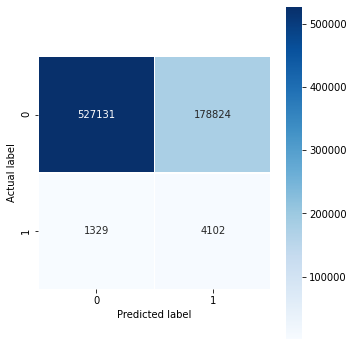

[0]	validation_0-aucpr:0.021487
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.02583
[2]	validation_0-aucpr:0.029564
[3]	validation_0-aucpr:0.024609
[4]	validation_0-aucpr:0.027124
[5]	validation_0-aucpr:0.026733
[6]	validation_0-aucpr:0.028262
[7]	validation_0-aucpr:0.028759
[8]	validation_0-aucpr:0.028542
[9]	validation_0-aucpr:0.028709
[10]	validation_0-aucpr:0.030314
[11]	validation_0-aucpr:0.031712
[12]	validation_0-aucpr:0.032652
[13]	validation_0-aucpr:0.034489
[14]	validation_0-aucpr:0.03407
[15]	validation_0-aucpr:0.033548
[16]	validation_0-aucpr:0.034672
[17]	validation_0-aucpr:0.036476
[18]	validation_0-aucpr:0.037436
[19]	validation_0-aucpr:0.037869
[20]	validation_0-aucpr:0.038643
[21]	validation_0-aucpr:0.038382
[22]	validation_0-aucpr:0.039281
[23]	validation_0-aucpr:0.039441
[24]	validation_0-aucpr:0.040878
[25]	validation_0-aucpr:0.041785
[26]	validation_0-aucpr:0.04267
[27]	validation_0-aucpr:0.042738
[28]	validation_0-aucpr

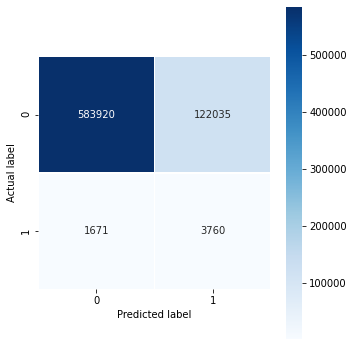

[0]	validation_0-aucpr:0.016086
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.018244
[2]	validation_0-aucpr:0.025007
[3]	validation_0-aucpr:0.025969
[4]	validation_0-aucpr:0.025179
[5]	validation_0-aucpr:0.027234
[6]	validation_0-aucpr:0.028362
[7]	validation_0-aucpr:0.029199
[8]	validation_0-aucpr:0.027727
[9]	validation_0-aucpr:0.028717
[10]	validation_0-aucpr:0.030821
[11]	validation_0-aucpr:0.031221
[12]	validation_0-aucpr:0.033982
[13]	validation_0-aucpr:0.032882
[14]	validation_0-aucpr:0.035255
[15]	validation_0-aucpr:0.036453
[16]	validation_0-aucpr:0.038464
[17]	validation_0-aucpr:0.039733
[18]	validation_0-aucpr:0.040632
[19]	validation_0-aucpr:0.042053
[20]	validation_0-aucpr:0.04151
[21]	validation_0-aucpr:0.041639
[22]	validation_0-aucpr:0.041901
[23]	validation_0-aucpr:0.044609
[24]	validation_0-aucpr:0.045626
[25]	validation_0-aucpr:0.049937
[26]	validation_0-aucpr:0.05122
[27]	validation_0-aucpr:0.051916
[28]	validation_0-aucp

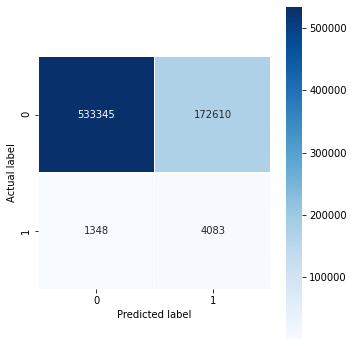

[0]	validation_0-aucpr:0.023886
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.027618
[2]	validation_0-aucpr:0.031499
[3]	validation_0-aucpr:0.033296
[4]	validation_0-aucpr:0.038638
[5]	validation_0-aucpr:0.041001
[6]	validation_0-aucpr:0.043014
[7]	validation_0-aucpr:0.044311
[8]	validation_0-aucpr:0.046676
[9]	validation_0-aucpr:0.053533
[10]	validation_0-aucpr:0.05311
[11]	validation_0-aucpr:0.05254
[12]	validation_0-aucpr:0.05367
[13]	validation_0-aucpr:0.055604
[14]	validation_0-aucpr:0.055947
[15]	validation_0-aucpr:0.057608
[16]	validation_0-aucpr:0.057055
[17]	validation_0-aucpr:0.056398
[18]	validation_0-aucpr:0.056835
[19]	validation_0-aucpr:0.056627
[20]	validation_0-aucpr:0.057543
[21]	validation_0-aucpr:0.059661
[22]	validation_0-aucpr:0.060487
[23]	validation_0-aucpr:0.059527
[24]	validation_0-aucpr:0.059933
[25]	validation_0-aucpr:0.058973
[26]	validation_0-aucpr:0.061477
[27]	validation_0-aucpr:0.062933
[28]	validation_0-aucpr

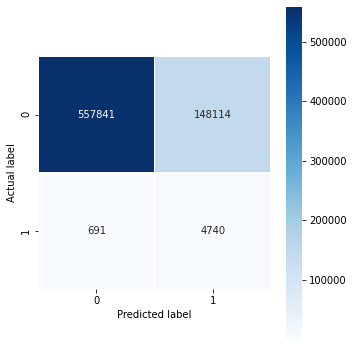

[0]	validation_0-aucpr:0.017518
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.025121
[2]	validation_0-aucpr:0.025365
[3]	validation_0-aucpr:0.036883
[4]	validation_0-aucpr:0.04746
[5]	validation_0-aucpr:0.042754
[6]	validation_0-aucpr:0.04545
[7]	validation_0-aucpr:0.052019
[8]	validation_0-aucpr:0.056948
[9]	validation_0-aucpr:0.050186
[10]	validation_0-aucpr:0.051686
[11]	validation_0-aucpr:0.058271
[12]	validation_0-aucpr:0.056567
[13]	validation_0-aucpr:0.05652
[14]	validation_0-aucpr:0.059166
[15]	validation_0-aucpr:0.063388
[16]	validation_0-aucpr:0.064822
[17]	validation_0-aucpr:0.062476
[18]	validation_0-aucpr:0.06342
[19]	validation_0-aucpr:0.067009
[20]	validation_0-aucpr:0.067262
[21]	validation_0-aucpr:0.070807
[22]	validation_0-aucpr:0.070508
[23]	validation_0-aucpr:0.070548
[24]	validation_0-aucpr:0.071513
[25]	validation_0-aucpr:0.076217
[26]	validation_0-aucpr:0.076532
[27]	validation_0-aucpr:0.082818
[28]	validation_0-aucpr:

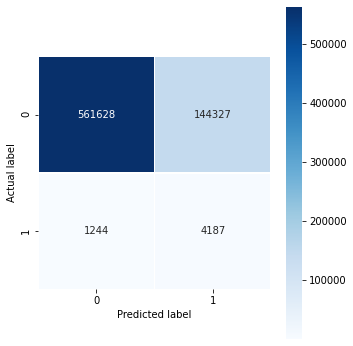

[0]	validation_0-aucpr:0.01808
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.022116
[2]	validation_0-aucpr:0.022978
[3]	validation_0-aucpr:0.023741
[4]	validation_0-aucpr:0.024453
[5]	validation_0-aucpr:0.024589
[6]	validation_0-aucpr:0.026192
[7]	validation_0-aucpr:0.02906
[8]	validation_0-aucpr:0.03167
[9]	validation_0-aucpr:0.032788
[10]	validation_0-aucpr:0.031997
[11]	validation_0-aucpr:0.031907
[12]	validation_0-aucpr:0.032584
[13]	validation_0-aucpr:0.032161
[14]	validation_0-aucpr:0.032462
[15]	validation_0-aucpr:0.033725
[16]	validation_0-aucpr:0.033508
[17]	validation_0-aucpr:0.035246
[18]	validation_0-aucpr:0.035915
[19]	validation_0-aucpr:0.03628
[20]	validation_0-aucpr:0.035874
[21]	validation_0-aucpr:0.036392
[22]	validation_0-aucpr:0.037988
[23]	validation_0-aucpr:0.037288
[24]	validation_0-aucpr:0.036818
[25]	validation_0-aucpr:0.037859
[26]	validation_0-aucpr:0.038042
[27]	validation_0-aucpr:0.039386
[28]	validation_0-aucpr:

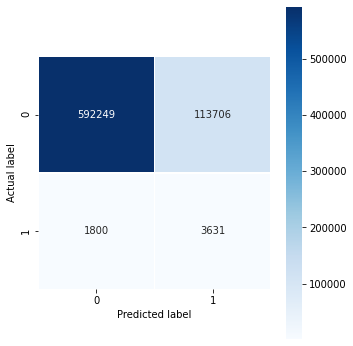

[0]	validation_0-aucpr:0.018382
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.020811
[2]	validation_0-aucpr:0.021672
[3]	validation_0-aucpr:0.02342
[4]	validation_0-aucpr:0.023289
[5]	validation_0-aucpr:0.02405
[6]	validation_0-aucpr:0.02426
[7]	validation_0-aucpr:0.024613
[8]	validation_0-aucpr:0.027984
[9]	validation_0-aucpr:0.029399
[10]	validation_0-aucpr:0.028897
[11]	validation_0-aucpr:0.029746
[12]	validation_0-aucpr:0.032506
[13]	validation_0-aucpr:0.032444
[14]	validation_0-aucpr:0.032812
[15]	validation_0-aucpr:0.034001
[16]	validation_0-aucpr:0.032484
[17]	validation_0-aucpr:0.032572
[18]	validation_0-aucpr:0.033464
[19]	validation_0-aucpr:0.034475
[20]	validation_0-aucpr:0.03571
[21]	validation_0-aucpr:0.036291
[22]	validation_0-aucpr:0.03718
[23]	validation_0-aucpr:0.03715
[24]	validation_0-aucpr:0.037716
[25]	validation_0-aucpr:0.038609
[26]	validation_0-aucpr:0.039179
[27]	validation_0-aucpr:0.039183
[28]	validation_0-aucpr:0.

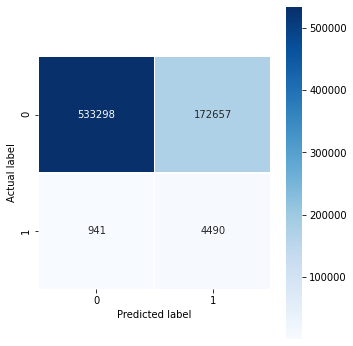

[0]	validation_0-aucpr:0.022871
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.025218
[2]	validation_0-aucpr:0.025281
[3]	validation_0-aucpr:0.02921
[4]	validation_0-aucpr:0.033014
[5]	validation_0-aucpr:0.04154
[6]	validation_0-aucpr:0.04088
[7]	validation_0-aucpr:0.041498
[8]	validation_0-aucpr:0.053532
[9]	validation_0-aucpr:0.065047
[10]	validation_0-aucpr:0.063328
[11]	validation_0-aucpr:0.068159
[12]	validation_0-aucpr:0.061597
[13]	validation_0-aucpr:0.060013
[14]	validation_0-aucpr:0.058577
[15]	validation_0-aucpr:0.06131
[16]	validation_0-aucpr:0.058525
[17]	validation_0-aucpr:0.05619
[18]	validation_0-aucpr:0.058247
[19]	validation_0-aucpr:0.059288
[20]	validation_0-aucpr:0.061718
[21]	validation_0-aucpr:0.060347
Stopping. Best iteration:
[11]	validation_0-aucpr:0.068159

Prediction Report of trial 23
               precision    recall  f1-score   support

           0       1.00      0.66      0.79    705955
           1       0.02

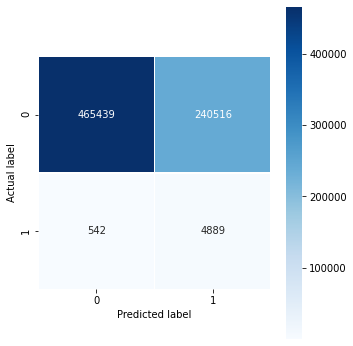

[0]	validation_0-aucpr:0.018763
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.026362
[2]	validation_0-aucpr:0.023818
[3]	validation_0-aucpr:0.027276
[4]	validation_0-aucpr:0.02468
[5]	validation_0-aucpr:0.024304
[6]	validation_0-aucpr:0.025708
[7]	validation_0-aucpr:0.025875
[8]	validation_0-aucpr:0.028367
[9]	validation_0-aucpr:0.027988
[10]	validation_0-aucpr:0.028503
[11]	validation_0-aucpr:0.029098
[12]	validation_0-aucpr:0.02897
[13]	validation_0-aucpr:0.029914
[14]	validation_0-aucpr:0.033886
[15]	validation_0-aucpr:0.032878
[16]	validation_0-aucpr:0.032427
[17]	validation_0-aucpr:0.035296
[18]	validation_0-aucpr:0.03485
[19]	validation_0-aucpr:0.034317
[20]	validation_0-aucpr:0.036304
[21]	validation_0-aucpr:0.036374
[22]	validation_0-aucpr:0.03823
[23]	validation_0-aucpr:0.040106
[24]	validation_0-aucpr:0.041707
[25]	validation_0-aucpr:0.04311
[26]	validation_0-aucpr:0.043353
[27]	validation_0-aucpr:0.044413
[28]	validation_0-aucpr:0

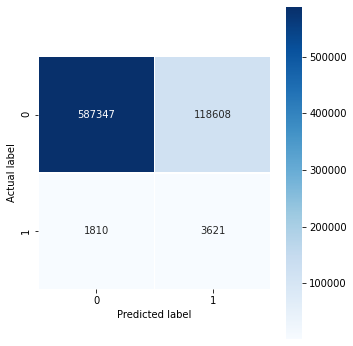

[0]	validation_0-aucpr:0.018805
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.020327
[2]	validation_0-aucpr:0.021733
[3]	validation_0-aucpr:0.024673
[4]	validation_0-aucpr:0.027873
[5]	validation_0-aucpr:0.027674
[6]	validation_0-aucpr:0.028198
[7]	validation_0-aucpr:0.030818
[8]	validation_0-aucpr:0.031166
[9]	validation_0-aucpr:0.030559
[10]	validation_0-aucpr:0.031571
[11]	validation_0-aucpr:0.030862
[12]	validation_0-aucpr:0.032449
[13]	validation_0-aucpr:0.035549
[14]	validation_0-aucpr:0.034447
[15]	validation_0-aucpr:0.035747
[16]	validation_0-aucpr:0.038264
[17]	validation_0-aucpr:0.039581
[18]	validation_0-aucpr:0.041601
[19]	validation_0-aucpr:0.040464
[20]	validation_0-aucpr:0.03996
[21]	validation_0-aucpr:0.040473
[22]	validation_0-aucpr:0.041941
[23]	validation_0-aucpr:0.043231
[24]	validation_0-aucpr:0.042351
[25]	validation_0-aucpr:0.042017
[26]	validation_0-aucpr:0.044925
[27]	validation_0-aucpr:0.047053
[28]	validation_0-auc

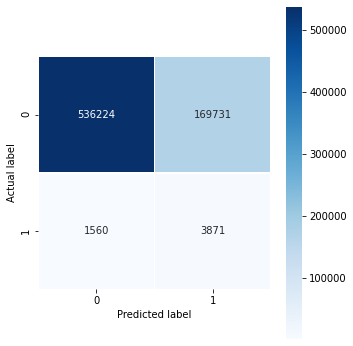

[0]	validation_0-aucpr:0.015407
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.016575
[2]	validation_0-aucpr:0.019612
[3]	validation_0-aucpr:0.021759
[4]	validation_0-aucpr:0.022058
[5]	validation_0-aucpr:0.023249
[6]	validation_0-aucpr:0.028417
[7]	validation_0-aucpr:0.030117
[8]	validation_0-aucpr:0.030109
[9]	validation_0-aucpr:0.030067
[10]	validation_0-aucpr:0.030674
[11]	validation_0-aucpr:0.029011
[12]	validation_0-aucpr:0.029964
[13]	validation_0-aucpr:0.030685
[14]	validation_0-aucpr:0.030483
[15]	validation_0-aucpr:0.032139
[16]	validation_0-aucpr:0.032842
[17]	validation_0-aucpr:0.032431
[18]	validation_0-aucpr:0.03296
[19]	validation_0-aucpr:0.033129
[20]	validation_0-aucpr:0.034306
[21]	validation_0-aucpr:0.034325
[22]	validation_0-aucpr:0.034838
[23]	validation_0-aucpr:0.03495
[24]	validation_0-aucpr:0.035239
[25]	validation_0-aucpr:0.034812
[26]	validation_0-aucpr:0.035495
[27]	validation_0-aucpr:0.035144
[28]	validation_0-aucp

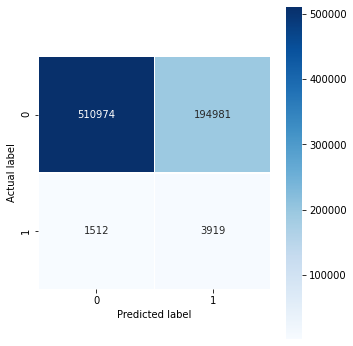

[0]	validation_0-aucpr:0.018126
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.019969
[2]	validation_0-aucpr:0.020417
[3]	validation_0-aucpr:0.024151
[4]	validation_0-aucpr:0.024043
[5]	validation_0-aucpr:0.024926
[6]	validation_0-aucpr:0.027266
[7]	validation_0-aucpr:0.029099
[8]	validation_0-aucpr:0.029024
[9]	validation_0-aucpr:0.029572
[10]	validation_0-aucpr:0.028574
[11]	validation_0-aucpr:0.02865
[12]	validation_0-aucpr:0.027847
[13]	validation_0-aucpr:0.028714
[14]	validation_0-aucpr:0.029778
[15]	validation_0-aucpr:0.028282
[16]	validation_0-aucpr:0.029298
[17]	validation_0-aucpr:0.030303
[18]	validation_0-aucpr:0.030232
[19]	validation_0-aucpr:0.031851
[20]	validation_0-aucpr:0.032326
[21]	validation_0-aucpr:0.032496
[22]	validation_0-aucpr:0.033696
[23]	validation_0-aucpr:0.033571
[24]	validation_0-aucpr:0.033926
[25]	validation_0-aucpr:0.034734
[26]	validation_0-aucpr:0.035027
[27]	validation_0-aucpr:0.035896
[28]	validation_0-auc

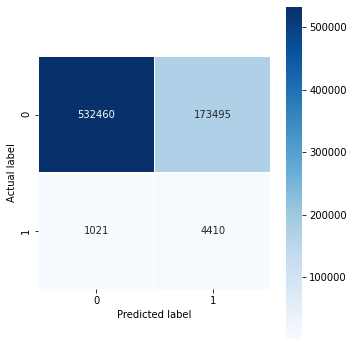

[0]	validation_0-aucpr:0.017368
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.023744
[2]	validation_0-aucpr:0.025259
[3]	validation_0-aucpr:0.029683
[4]	validation_0-aucpr:0.033713
[5]	validation_0-aucpr:0.036928
[6]	validation_0-aucpr:0.041871
[7]	validation_0-aucpr:0.04409
[8]	validation_0-aucpr:0.043507
[9]	validation_0-aucpr:0.043103
[10]	validation_0-aucpr:0.041618
[11]	validation_0-aucpr:0.045677
[12]	validation_0-aucpr:0.049352
[13]	validation_0-aucpr:0.050476
[14]	validation_0-aucpr:0.055272
[15]	validation_0-aucpr:0.056489
[16]	validation_0-aucpr:0.058532
[17]	validation_0-aucpr:0.057696
[18]	validation_0-aucpr:0.061949
[19]	validation_0-aucpr:0.063749
[20]	validation_0-aucpr:0.063989
[21]	validation_0-aucpr:0.066171
[22]	validation_0-aucpr:0.068179
[23]	validation_0-aucpr:0.069386
[24]	validation_0-aucpr:0.070477
[25]	validation_0-aucpr:0.069438
[26]	validation_0-aucpr:0.070913
[27]	validation_0-aucpr:0.071601
[28]	validation_0-auc

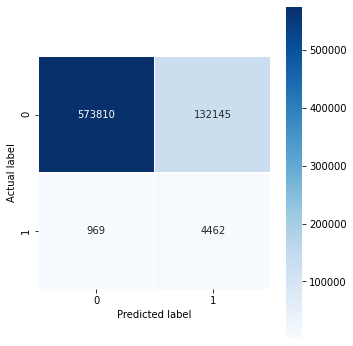

[0]	validation_0-aucpr:0.026456
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.029021
[2]	validation_0-aucpr:0.031287
[3]	validation_0-aucpr:0.029092
[4]	validation_0-aucpr:0.029238
[5]	validation_0-aucpr:0.035004
[6]	validation_0-aucpr:0.030004
[7]	validation_0-aucpr:0.030919
[8]	validation_0-aucpr:0.034101
[9]	validation_0-aucpr:0.036473
[10]	validation_0-aucpr:0.040535
[11]	validation_0-aucpr:0.042233
[12]	validation_0-aucpr:0.040747
[13]	validation_0-aucpr:0.042541
[14]	validation_0-aucpr:0.040793
[15]	validation_0-aucpr:0.041464
[16]	validation_0-aucpr:0.039102
[17]	validation_0-aucpr:0.039402
[18]	validation_0-aucpr:0.041931
[19]	validation_0-aucpr:0.045215
[20]	validation_0-aucpr:0.045936
[21]	validation_0-aucpr:0.046193
[22]	validation_0-aucpr:0.048407
[23]	validation_0-aucpr:0.048148
[24]	validation_0-aucpr:0.048851
[25]	validation_0-aucpr:0.049446
[26]	validation_0-aucpr:0.050643
[27]	validation_0-aucpr:0.052073
[28]	validation_0-au

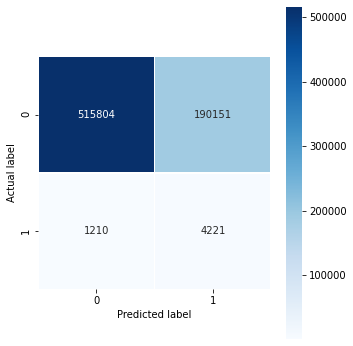

[0]	validation_0-aucpr:0.022488
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.022582
[2]	validation_0-aucpr:0.025486
[3]	validation_0-aucpr:0.029839
[4]	validation_0-aucpr:0.030851
[5]	validation_0-aucpr:0.036458
[6]	validation_0-aucpr:0.038635
[7]	validation_0-aucpr:0.038919
[8]	validation_0-aucpr:0.045267
[9]	validation_0-aucpr:0.042637
[10]	validation_0-aucpr:0.048481
[11]	validation_0-aucpr:0.046146
[12]	validation_0-aucpr:0.046073
[13]	validation_0-aucpr:0.048092
[14]	validation_0-aucpr:0.050555
[15]	validation_0-aucpr:0.051128
[16]	validation_0-aucpr:0.050046
[17]	validation_0-aucpr:0.047887
[18]	validation_0-aucpr:0.050574
[19]	validation_0-aucpr:0.052314
[20]	validation_0-aucpr:0.052982
[21]	validation_0-aucpr:0.051939
[22]	validation_0-aucpr:0.051319
[23]	validation_0-aucpr:0.0506
[24]	validation_0-aucpr:0.053174
[25]	validation_0-aucpr:0.053585
[26]	validation_0-aucpr:0.052726
[27]	validation_0-aucpr:0.054244
[28]	validation_0-aucp

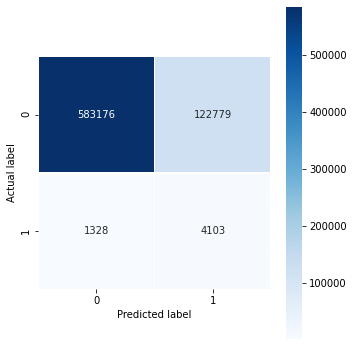

[0]	validation_0-aucpr:0.019592
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.02064
[2]	validation_0-aucpr:0.025499
[3]	validation_0-aucpr:0.025532
[4]	validation_0-aucpr:0.027803
[5]	validation_0-aucpr:0.027634
[6]	validation_0-aucpr:0.028231
[7]	validation_0-aucpr:0.029913
[8]	validation_0-aucpr:0.030756
[9]	validation_0-aucpr:0.032254
[10]	validation_0-aucpr:0.032206
[11]	validation_0-aucpr:0.033804
[12]	validation_0-aucpr:0.033852
[13]	validation_0-aucpr:0.036057
[14]	validation_0-aucpr:0.034878
[15]	validation_0-aucpr:0.037871
[16]	validation_0-aucpr:0.039498
[17]	validation_0-aucpr:0.039912
[18]	validation_0-aucpr:0.040289
[19]	validation_0-aucpr:0.042792
[20]	validation_0-aucpr:0.042659
[21]	validation_0-aucpr:0.044325
[22]	validation_0-aucpr:0.046976
[23]	validation_0-aucpr:0.045522
[24]	validation_0-aucpr:0.045331
[25]	validation_0-aucpr:0.043733
[26]	validation_0-aucpr:0.046145
[27]	validation_0-aucpr:0.047861
[28]	validation_0-auc

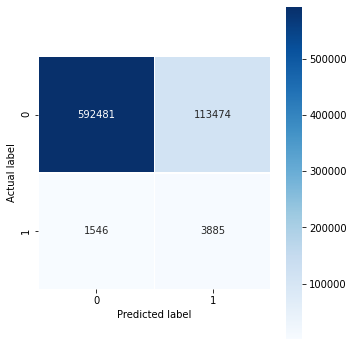

[0]	validation_0-aucpr:0.022255
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.02339
[2]	validation_0-aucpr:0.029027
[3]	validation_0-aucpr:0.046456
[4]	validation_0-aucpr:0.031904
[5]	validation_0-aucpr:0.036628
[6]	validation_0-aucpr:0.030006
[7]	validation_0-aucpr:0.033465
[8]	validation_0-aucpr:0.038165
[9]	validation_0-aucpr:0.040218
[10]	validation_0-aucpr:0.042928
[11]	validation_0-aucpr:0.044326
[12]	validation_0-aucpr:0.045909
[13]	validation_0-aucpr:0.048383
[14]	validation_0-aucpr:0.048339
[15]	validation_0-aucpr:0.053144
[16]	validation_0-aucpr:0.056099
[17]	validation_0-aucpr:0.059542
[18]	validation_0-aucpr:0.061488
[19]	validation_0-aucpr:0.064647
[20]	validation_0-aucpr:0.065906
[21]	validation_0-aucpr:0.061062
[22]	validation_0-aucpr:0.061432
[23]	validation_0-aucpr:0.066533
[24]	validation_0-aucpr:0.065093
[25]	validation_0-aucpr:0.068688
[26]	validation_0-aucpr:0.067292
[27]	validation_0-aucpr:0.072452
[28]	validation_0-auc

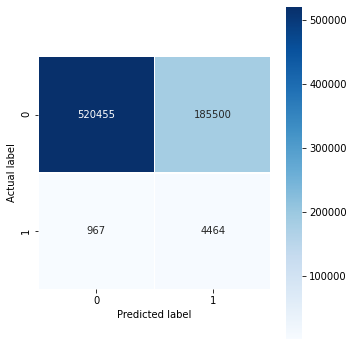

[0]	validation_0-aucpr:0.018205
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.018954
[2]	validation_0-aucpr:0.017813
[3]	validation_0-aucpr:0.019627
[4]	validation_0-aucpr:0.020741
[5]	validation_0-aucpr:0.021541
[6]	validation_0-aucpr:0.023742
[7]	validation_0-aucpr:0.024637
[8]	validation_0-aucpr:0.02339
[9]	validation_0-aucpr:0.024336
[10]	validation_0-aucpr:0.025181
[11]	validation_0-aucpr:0.024694
[12]	validation_0-aucpr:0.026008
[13]	validation_0-aucpr:0.026156
[14]	validation_0-aucpr:0.026116
[15]	validation_0-aucpr:0.026279
[16]	validation_0-aucpr:0.026456
[17]	validation_0-aucpr:0.027661
[18]	validation_0-aucpr:0.028145
[19]	validation_0-aucpr:0.027875
[20]	validation_0-aucpr:0.028606
[21]	validation_0-aucpr:0.032253
[22]	validation_0-aucpr:0.032435
[23]	validation_0-aucpr:0.033848
[24]	validation_0-aucpr:0.034516
[25]	validation_0-aucpr:0.034898
[26]	validation_0-aucpr:0.03416
[27]	validation_0-aucpr:0.03323
[28]	validation_0-aucpr

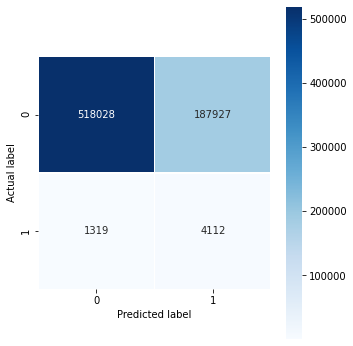

[0]	validation_0-aucpr:0.019926
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.031439
[2]	validation_0-aucpr:0.035249
[3]	validation_0-aucpr:0.035982
[4]	validation_0-aucpr:0.037974
[5]	validation_0-aucpr:0.034814
[6]	validation_0-aucpr:0.039288
[7]	validation_0-aucpr:0.049384
[8]	validation_0-aucpr:0.04283
[9]	validation_0-aucpr:0.041073
[10]	validation_0-aucpr:0.043016
[11]	validation_0-aucpr:0.043469
[12]	validation_0-aucpr:0.045317
[13]	validation_0-aucpr:0.043689
[14]	validation_0-aucpr:0.046582
[15]	validation_0-aucpr:0.044171
[16]	validation_0-aucpr:0.045208
[17]	validation_0-aucpr:0.044878
Stopping. Best iteration:
[7]	validation_0-aucpr:0.049384

Prediction Report of trial 34
               precision    recall  f1-score   support

           0       1.00      0.67      0.80    705955
           1       0.02      0.83      0.04      5431

    accuracy                           0.67    711386
   macro avg       0.51      0.75      0.42

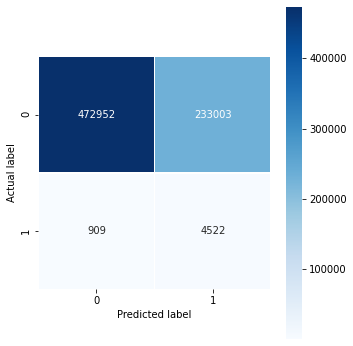

[0]	validation_0-aucpr:0.027677
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.032271
[2]	validation_0-aucpr:0.038759
[3]	validation_0-aucpr:0.052213
[4]	validation_0-aucpr:0.054265
[5]	validation_0-aucpr:0.048313
[6]	validation_0-aucpr:0.054509
[7]	validation_0-aucpr:0.04975
[8]	validation_0-aucpr:0.055836
[9]	validation_0-aucpr:0.052071
[10]	validation_0-aucpr:0.053001
[11]	validation_0-aucpr:0.054699
[12]	validation_0-aucpr:0.061054
[13]	validation_0-aucpr:0.058255
[14]	validation_0-aucpr:0.054444
[15]	validation_0-aucpr:0.064125
[16]	validation_0-aucpr:0.066873
[17]	validation_0-aucpr:0.064232
[18]	validation_0-aucpr:0.066452
[19]	validation_0-aucpr:0.065307
[20]	validation_0-aucpr:0.063055
[21]	validation_0-aucpr:0.06146
[22]	validation_0-aucpr:0.059617
[23]	validation_0-aucpr:0.060395
[24]	validation_0-aucpr:0.062609
[25]	validation_0-aucpr:0.064898
[26]	validation_0-aucpr:0.063257
Stopping. Best iteration:
[16]	validation_0-aucpr:0.066

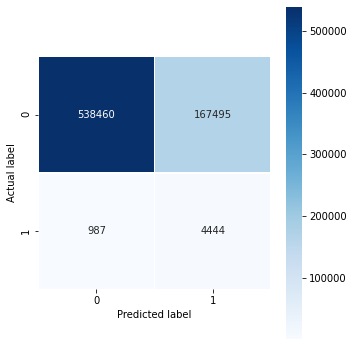

[0]	validation_0-aucpr:0.01911
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.020255
[2]	validation_0-aucpr:0.022669
[3]	validation_0-aucpr:0.026397
[4]	validation_0-aucpr:0.027575
[5]	validation_0-aucpr:0.027848
[6]	validation_0-aucpr:0.027616
[7]	validation_0-aucpr:0.032987
[8]	validation_0-aucpr:0.035296
[9]	validation_0-aucpr:0.031726
[10]	validation_0-aucpr:0.03132
[11]	validation_0-aucpr:0.032099
[12]	validation_0-aucpr:0.033756
[13]	validation_0-aucpr:0.035168
[14]	validation_0-aucpr:0.035682
[15]	validation_0-aucpr:0.03664
[16]	validation_0-aucpr:0.037303
[17]	validation_0-aucpr:0.037939
[18]	validation_0-aucpr:0.03997
[19]	validation_0-aucpr:0.041354
[20]	validation_0-aucpr:0.042239
[21]	validation_0-aucpr:0.042892
[22]	validation_0-aucpr:0.044302
[23]	validation_0-aucpr:0.044528
[24]	validation_0-aucpr:0.047203
[25]	validation_0-aucpr:0.048736
[26]	validation_0-aucpr:0.050886
[27]	validation_0-aucpr:0.051145
[28]	validation_0-aucpr:

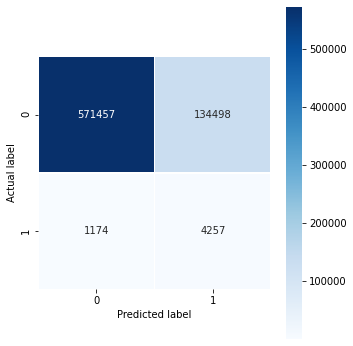

[0]	validation_0-aucpr:0.021338
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.02375
[2]	validation_0-aucpr:0.028198
[3]	validation_0-aucpr:0.031324
[4]	validation_0-aucpr:0.030757
[5]	validation_0-aucpr:0.029576
[6]	validation_0-aucpr:0.031619
[7]	validation_0-aucpr:0.030289
[8]	validation_0-aucpr:0.035826
[9]	validation_0-aucpr:0.03721
[10]	validation_0-aucpr:0.037561
[11]	validation_0-aucpr:0.039269
[12]	validation_0-aucpr:0.042371
[13]	validation_0-aucpr:0.042774
[14]	validation_0-aucpr:0.04446
[15]	validation_0-aucpr:0.046724
[16]	validation_0-aucpr:0.047321
[17]	validation_0-aucpr:0.04761
[18]	validation_0-aucpr:0.051251
[19]	validation_0-aucpr:0.050162
[20]	validation_0-aucpr:0.050489
[21]	validation_0-aucpr:0.050237
[22]	validation_0-aucpr:0.050429
[23]	validation_0-aucpr:0.051768
[24]	validation_0-aucpr:0.051092
[25]	validation_0-aucpr:0.051577
[26]	validation_0-aucpr:0.054281
[27]	validation_0-aucpr:0.054274
[28]	validation_0-aucpr:

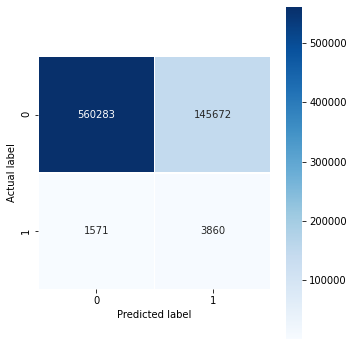

[0]	validation_0-aucpr:0.025743
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.03022
[2]	validation_0-aucpr:0.03499
[3]	validation_0-aucpr:0.036215
[4]	validation_0-aucpr:0.049187
[5]	validation_0-aucpr:0.048402
[6]	validation_0-aucpr:0.051208
[7]	validation_0-aucpr:0.050743
[8]	validation_0-aucpr:0.055525
[9]	validation_0-aucpr:0.053778
[10]	validation_0-aucpr:0.058089
[11]	validation_0-aucpr:0.059985
[12]	validation_0-aucpr:0.061111
[13]	validation_0-aucpr:0.063103
[14]	validation_0-aucpr:0.068638
[15]	validation_0-aucpr:0.070884
[16]	validation_0-aucpr:0.073818
[17]	validation_0-aucpr:0.077302
[18]	validation_0-aucpr:0.081411
[19]	validation_0-aucpr:0.083823
[20]	validation_0-aucpr:0.08133
[21]	validation_0-aucpr:0.079051
[22]	validation_0-aucpr:0.07945
[23]	validation_0-aucpr:0.077654
[24]	validation_0-aucpr:0.075373
[25]	validation_0-aucpr:0.074025
[26]	validation_0-aucpr:0.077782
[27]	validation_0-aucpr:0.080026
[28]	validation_0-aucpr:

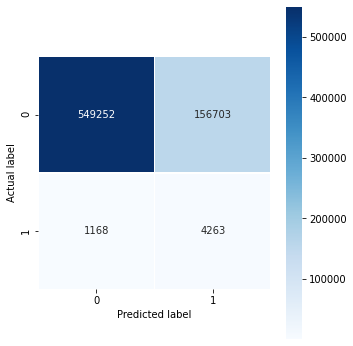

[0]	validation_0-aucpr:0.021452
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.027406
[2]	validation_0-aucpr:0.029192
[3]	validation_0-aucpr:0.035153
[4]	validation_0-aucpr:0.035339
[5]	validation_0-aucpr:0.040324
[6]	validation_0-aucpr:0.045628
[7]	validation_0-aucpr:0.043194
[8]	validation_0-aucpr:0.045114
[9]	validation_0-aucpr:0.044783
[10]	validation_0-aucpr:0.044673
[11]	validation_0-aucpr:0.046496
[12]	validation_0-aucpr:0.050667
[13]	validation_0-aucpr:0.048777
[14]	validation_0-aucpr:0.047888
[15]	validation_0-aucpr:0.046189
[16]	validation_0-aucpr:0.04663
[17]	validation_0-aucpr:0.048398
[18]	validation_0-aucpr:0.04722
[19]	validation_0-aucpr:0.047103
[20]	validation_0-aucpr:0.047059
[21]	validation_0-aucpr:0.046859
[22]	validation_0-aucpr:0.048033
Stopping. Best iteration:
[12]	validation_0-aucpr:0.050667

Prediction Report of trial 39
               precision    recall  f1-score   support

           0       1.00      0.75      0.

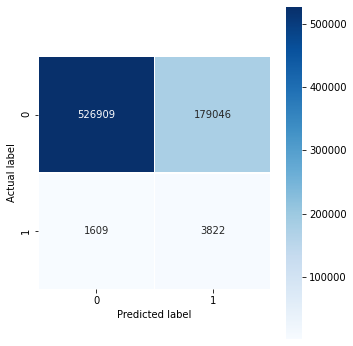

[0]	validation_0-aucpr:0.021532
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.022018
[2]	validation_0-aucpr:0.022537
[3]	validation_0-aucpr:0.023847
[4]	validation_0-aucpr:0.024468
[5]	validation_0-aucpr:0.024673
[6]	validation_0-aucpr:0.025681
[7]	validation_0-aucpr:0.027582
[8]	validation_0-aucpr:0.029007
[9]	validation_0-aucpr:0.029573
[10]	validation_0-aucpr:0.030773
[11]	validation_0-aucpr:0.032652
[12]	validation_0-aucpr:0.032234
[13]	validation_0-aucpr:0.031727
[14]	validation_0-aucpr:0.031932
[15]	validation_0-aucpr:0.031446
[16]	validation_0-aucpr:0.032286
[17]	validation_0-aucpr:0.032958
[18]	validation_0-aucpr:0.033591
[19]	validation_0-aucpr:0.03475
[20]	validation_0-aucpr:0.034013
[21]	validation_0-aucpr:0.03464
[22]	validation_0-aucpr:0.034458
[23]	validation_0-aucpr:0.034817
[24]	validation_0-aucpr:0.03515
[25]	validation_0-aucpr:0.034802
[26]	validation_0-aucpr:0.034562
[27]	validation_0-aucpr:0.034045
[28]	validation_0-aucpr

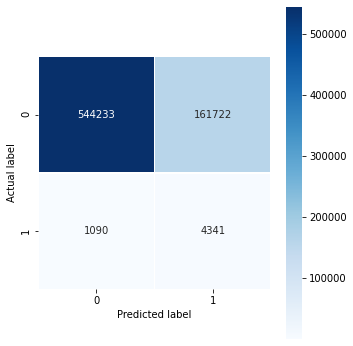

[0]	validation_0-aucpr:0.021106
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.02126
[2]	validation_0-aucpr:0.02449
[3]	validation_0-aucpr:0.023354
[4]	validation_0-aucpr:0.02476
[5]	validation_0-aucpr:0.02977
[6]	validation_0-aucpr:0.032393
[7]	validation_0-aucpr:0.033641
[8]	validation_0-aucpr:0.037971
[9]	validation_0-aucpr:0.033615
[10]	validation_0-aucpr:0.03483
[11]	validation_0-aucpr:0.039307
[12]	validation_0-aucpr:0.040588
[13]	validation_0-aucpr:0.041859
[14]	validation_0-aucpr:0.040584
[15]	validation_0-aucpr:0.039546
[16]	validation_0-aucpr:0.04012
[17]	validation_0-aucpr:0.043888
[18]	validation_0-aucpr:0.045488
[19]	validation_0-aucpr:0.045032
[20]	validation_0-aucpr:0.047246
[21]	validation_0-aucpr:0.047078
[22]	validation_0-aucpr:0.048178
[23]	validation_0-aucpr:0.048394
[24]	validation_0-aucpr:0.050404
[25]	validation_0-aucpr:0.052051
[26]	validation_0-aucpr:0.05226
[27]	validation_0-aucpr:0.050811
[28]	validation_0-aucpr:0.0

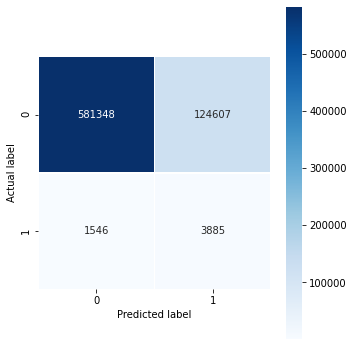

[0]	validation_0-aucpr:0.018896
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.02027
[2]	validation_0-aucpr:0.019389
[3]	validation_0-aucpr:0.02223
[4]	validation_0-aucpr:0.022174
[5]	validation_0-aucpr:0.022728
[6]	validation_0-aucpr:0.032541
[7]	validation_0-aucpr:0.039294
[8]	validation_0-aucpr:0.04147
[9]	validation_0-aucpr:0.040382
[10]	validation_0-aucpr:0.043604
[11]	validation_0-aucpr:0.045541
[12]	validation_0-aucpr:0.051504
[13]	validation_0-aucpr:0.055701
[14]	validation_0-aucpr:0.055306
[15]	validation_0-aucpr:0.05361
[16]	validation_0-aucpr:0.05344
[17]	validation_0-aucpr:0.053447
[18]	validation_0-aucpr:0.054761
[19]	validation_0-aucpr:0.058728
[20]	validation_0-aucpr:0.059954
[21]	validation_0-aucpr:0.062779
[22]	validation_0-aucpr:0.063635
[23]	validation_0-aucpr:0.065513
[24]	validation_0-aucpr:0.065404
[25]	validation_0-aucpr:0.06273
[26]	validation_0-aucpr:0.067001
[27]	validation_0-aucpr:0.070167
[28]	validation_0-aucpr:0.

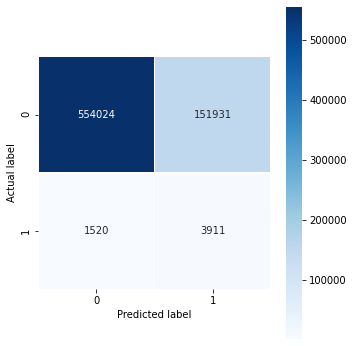

[0]	validation_0-aucpr:0.018811
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.019728
[2]	validation_0-aucpr:0.019713
[3]	validation_0-aucpr:0.022525
[4]	validation_0-aucpr:0.023448
[5]	validation_0-aucpr:0.023465
[6]	validation_0-aucpr:0.026126
[7]	validation_0-aucpr:0.029881
[8]	validation_0-aucpr:0.030494
[9]	validation_0-aucpr:0.03361
[10]	validation_0-aucpr:0.033933
[11]	validation_0-aucpr:0.035985
[12]	validation_0-aucpr:0.037041
[13]	validation_0-aucpr:0.03734
[14]	validation_0-aucpr:0.037146
[15]	validation_0-aucpr:0.036751
[16]	validation_0-aucpr:0.03745
[17]	validation_0-aucpr:0.037677
[18]	validation_0-aucpr:0.03751
[19]	validation_0-aucpr:0.037826
[20]	validation_0-aucpr:0.03745
[21]	validation_0-aucpr:0.039276
[22]	validation_0-aucpr:0.037849
[23]	validation_0-aucpr:0.038059
[24]	validation_0-aucpr:0.038679
[25]	validation_0-aucpr:0.039541
[26]	validation_0-aucpr:0.041433
[27]	validation_0-aucpr:0.042742
[28]	validation_0-aucpr:0

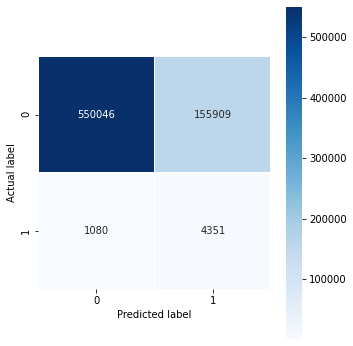

[0]	validation_0-aucpr:0.023522
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.024108
[2]	validation_0-aucpr:0.029053
[3]	validation_0-aucpr:0.035856
[4]	validation_0-aucpr:0.035575
[5]	validation_0-aucpr:0.037272
[6]	validation_0-aucpr:0.039341
[7]	validation_0-aucpr:0.036226
[8]	validation_0-aucpr:0.036768
[9]	validation_0-aucpr:0.035645
[10]	validation_0-aucpr:0.038677
[11]	validation_0-aucpr:0.038708
[12]	validation_0-aucpr:0.037096
[13]	validation_0-aucpr:0.038429
[14]	validation_0-aucpr:0.043571
[15]	validation_0-aucpr:0.041142
[16]	validation_0-aucpr:0.042097
[17]	validation_0-aucpr:0.041883
[18]	validation_0-aucpr:0.045533
[19]	validation_0-aucpr:0.044364
[20]	validation_0-aucpr:0.045526
[21]	validation_0-aucpr:0.043171
[22]	validation_0-aucpr:0.046265
[23]	validation_0-aucpr:0.045895
[24]	validation_0-aucpr:0.044581
[25]	validation_0-aucpr:0.04471
[26]	validation_0-aucpr:0.046189
[27]	validation_0-aucpr:0.048025
[28]	validation_0-auc

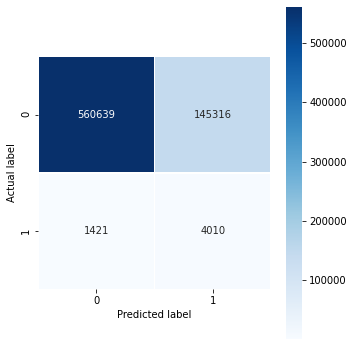

[0]	validation_0-aucpr:0.016538
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.020106
[2]	validation_0-aucpr:0.020723
[3]	validation_0-aucpr:0.020672
[4]	validation_0-aucpr:0.027968
[5]	validation_0-aucpr:0.033199
[6]	validation_0-aucpr:0.032143
[7]	validation_0-aucpr:0.031558
[8]	validation_0-aucpr:0.029708
[9]	validation_0-aucpr:0.030895
[10]	validation_0-aucpr:0.03013
[11]	validation_0-aucpr:0.031245
[12]	validation_0-aucpr:0.031943
[13]	validation_0-aucpr:0.035085
[14]	validation_0-aucpr:0.036079
[15]	validation_0-aucpr:0.034223
[16]	validation_0-aucpr:0.034112
[17]	validation_0-aucpr:0.035049
[18]	validation_0-aucpr:0.037101
[19]	validation_0-aucpr:0.040309
[20]	validation_0-aucpr:0.041101
[21]	validation_0-aucpr:0.041353
[22]	validation_0-aucpr:0.042488
[23]	validation_0-aucpr:0.042503
[24]	validation_0-aucpr:0.041981
[25]	validation_0-aucpr:0.042851
[26]	validation_0-aucpr:0.043176
[27]	validation_0-aucpr:0.044169
[28]	validation_0-auc

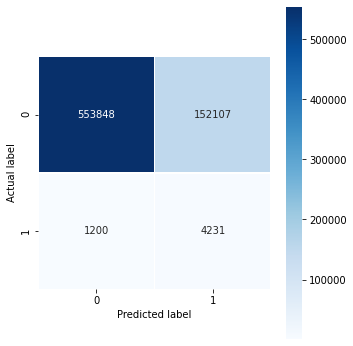

[0]	validation_0-aucpr:0.019643
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.02283
[2]	validation_0-aucpr:0.023631
[3]	validation_0-aucpr:0.023917
[4]	validation_0-aucpr:0.023389
[5]	validation_0-aucpr:0.0219
[6]	validation_0-aucpr:0.022622
[7]	validation_0-aucpr:0.023304
[8]	validation_0-aucpr:0.023591
[9]	validation_0-aucpr:0.023761
[10]	validation_0-aucpr:0.023452
[11]	validation_0-aucpr:0.023206
[12]	validation_0-aucpr:0.023707
[13]	validation_0-aucpr:0.024835
[14]	validation_0-aucpr:0.024703
[15]	validation_0-aucpr:0.024756
[16]	validation_0-aucpr:0.025907
[17]	validation_0-aucpr:0.025704
[18]	validation_0-aucpr:0.026017
[19]	validation_0-aucpr:0.026036
[20]	validation_0-aucpr:0.026631
[21]	validation_0-aucpr:0.026715
[22]	validation_0-aucpr:0.026972
[23]	validation_0-aucpr:0.026739
[24]	validation_0-aucpr:0.027312
[25]	validation_0-aucpr:0.028012
[26]	validation_0-aucpr:0.028845
[27]	validation_0-aucpr:0.029432
[28]	validation_0-aucpr

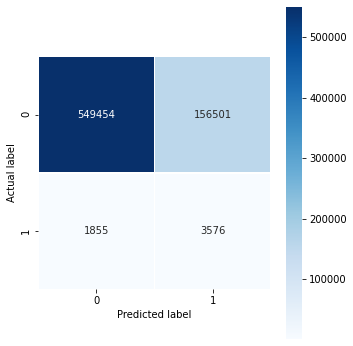

[0]	validation_0-aucpr:0.027988
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.029491
[2]	validation_0-aucpr:0.032611
[3]	validation_0-aucpr:0.034646
[4]	validation_0-aucpr:0.034964
[5]	validation_0-aucpr:0.035186
[6]	validation_0-aucpr:0.038032
[7]	validation_0-aucpr:0.038631
[8]	validation_0-aucpr:0.041961
[9]	validation_0-aucpr:0.050399
[10]	validation_0-aucpr:0.050643
[11]	validation_0-aucpr:0.049911
[12]	validation_0-aucpr:0.049738
[13]	validation_0-aucpr:0.051453
[14]	validation_0-aucpr:0.049441
[15]	validation_0-aucpr:0.04981
[16]	validation_0-aucpr:0.054848
[17]	validation_0-aucpr:0.055519
[18]	validation_0-aucpr:0.055612
[19]	validation_0-aucpr:0.054834
[20]	validation_0-aucpr:0.056523
[21]	validation_0-aucpr:0.055444
[22]	validation_0-aucpr:0.059341
[23]	validation_0-aucpr:0.05839
[24]	validation_0-aucpr:0.057176
[25]	validation_0-aucpr:0.056674
[26]	validation_0-aucpr:0.06026
[27]	validation_0-aucpr:0.059935
[28]	validation_0-aucpr

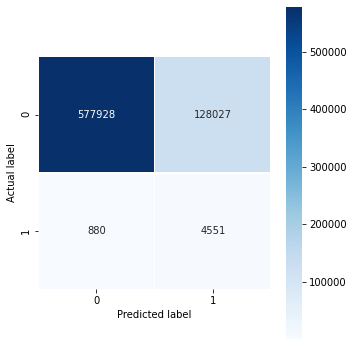

[0]	validation_0-aucpr:0.023726
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.024689
[2]	validation_0-aucpr:0.027766
[3]	validation_0-aucpr:0.028594
[4]	validation_0-aucpr:0.029826
[5]	validation_0-aucpr:0.03151
[6]	validation_0-aucpr:0.034297
[7]	validation_0-aucpr:0.032385
[8]	validation_0-aucpr:0.035916
[9]	validation_0-aucpr:0.042515
[10]	validation_0-aucpr:0.047955
[11]	validation_0-aucpr:0.048606
[12]	validation_0-aucpr:0.044956
[13]	validation_0-aucpr:0.04944
[14]	validation_0-aucpr:0.052374
[15]	validation_0-aucpr:0.052709
[16]	validation_0-aucpr:0.052557
[17]	validation_0-aucpr:0.054632
[18]	validation_0-aucpr:0.055615
[19]	validation_0-aucpr:0.053726
[20]	validation_0-aucpr:0.054258
[21]	validation_0-aucpr:0.054817
[22]	validation_0-aucpr:0.055268
[23]	validation_0-aucpr:0.05655
[24]	validation_0-aucpr:0.057191
[25]	validation_0-aucpr:0.057956
[26]	validation_0-aucpr:0.058803
[27]	validation_0-aucpr:0.058208
[28]	validation_0-aucpr

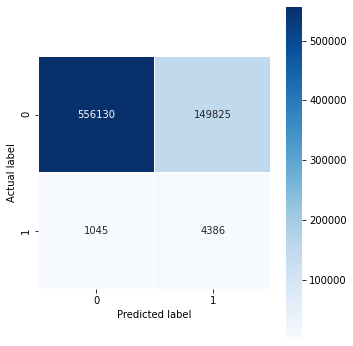

[0]	validation_0-aucpr:0.020874
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.029512
[2]	validation_0-aucpr:0.031468
[3]	validation_0-aucpr:0.028173
[4]	validation_0-aucpr:0.027898
[5]	validation_0-aucpr:0.030063
[6]	validation_0-aucpr:0.029646
[7]	validation_0-aucpr:0.030054
[8]	validation_0-aucpr:0.032239
[9]	validation_0-aucpr:0.034723
[10]	validation_0-aucpr:0.040245
[11]	validation_0-aucpr:0.040896
[12]	validation_0-aucpr:0.04662
[13]	validation_0-aucpr:0.048697
[14]	validation_0-aucpr:0.050141
[15]	validation_0-aucpr:0.058744
[16]	validation_0-aucpr:0.061769
[17]	validation_0-aucpr:0.062415
[18]	validation_0-aucpr:0.058029
[19]	validation_0-aucpr:0.059259
[20]	validation_0-aucpr:0.062281
[21]	validation_0-aucpr:0.056903
[22]	validation_0-aucpr:0.053781
[23]	validation_0-aucpr:0.05611
[24]	validation_0-aucpr:0.053035
[25]	validation_0-aucpr:0.05021
[26]	validation_0-aucpr:0.051175
[27]	validation_0-aucpr:0.049442
Stopping. Best iteratio

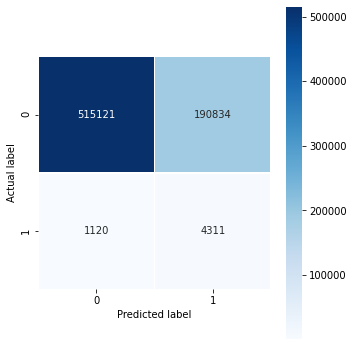

[0]	validation_0-aucpr:0.020326
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.026066
[2]	validation_0-aucpr:0.024016
[3]	validation_0-aucpr:0.025416
[4]	validation_0-aucpr:0.025054
[5]	validation_0-aucpr:0.025814
[6]	validation_0-aucpr:0.025219
[7]	validation_0-aucpr:0.026618
[8]	validation_0-aucpr:0.030639
[9]	validation_0-aucpr:0.030923
[10]	validation_0-aucpr:0.032552
[11]	validation_0-aucpr:0.032328
[12]	validation_0-aucpr:0.032149
[13]	validation_0-aucpr:0.036956
[14]	validation_0-aucpr:0.03949
[15]	validation_0-aucpr:0.042264
[16]	validation_0-aucpr:0.04226
[17]	validation_0-aucpr:0.04098
[18]	validation_0-aucpr:0.042118
[19]	validation_0-aucpr:0.043349
[20]	validation_0-aucpr:0.042227
[21]	validation_0-aucpr:0.04187
[22]	validation_0-aucpr:0.042223
[23]	validation_0-aucpr:0.042083
[24]	validation_0-aucpr:0.044567
[25]	validation_0-aucpr:0.04522
[26]	validation_0-aucpr:0.045271
[27]	validation_0-aucpr:0.047463
[28]	validation_0-aucpr:0

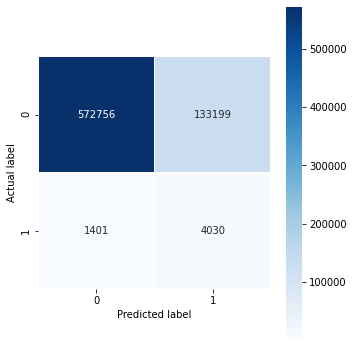

In [49]:
recall_0_list = []
recall_1_list = []
recall_avg_list = []

for trial in range(1, 51):
    random.seed(trial)
    
    random.shuffle(shuffled_flow_id_loss)
    random.shuffle(shuffled_flow_id_no_loss)
    
    df_loss_new = pd.concat([df_loss[df_loss['flow_id']==x] for x in shuffled_flow_id_loss])
    df_no_loss_new = pd.concat([df_no_loss[df_no_loss['flow_id']==x] for x in shuffled_flow_id_no_loss])
            
    df_train = pd.concat([df_loss_new.iloc[0:int(df_loss_new.shape[0] * 0.7)], df_no_loss_new.iloc[0:int(df_no_loss_new.shape[0] * 0.7)]])
    df_train_shuffled = df_train.sample(frac=1).reset_index()
    df_train_shuffled.drop(['index'], axis=1, inplace=True)
    df_test = pd.concat([df_loss_new.iloc[int(df_loss_new.shape[0] * 0.7)+1: -1], df_no_loss_new.iloc[int(df_no_loss_new.shape[0] * 0.7)+1: -1]])
    df_test_shuffled = df_test.sample(frac=1).reset_index()
    df_test_shuffled.drop(['index'], axis=1, inplace=True)

    x_train = df_train_shuffled[best_feature_list_removing_500ms]
    x_test = df_test_shuffled[best_feature_list_removing_500ms]
    y_train = df_train_shuffled[['lossOrNot']]
    y_train = y_train.astype(int)
    y_test = df_test_shuffled[['lossOrNot']]
    y_test = y_test.astype(int)
    
    clf_xgb_check = xgb.XGBClassifier(
        n_estimators=500, 
        objective='binary:logistic', 
        scale_pos_weight=weight, 
        n_jobs=48
    )
    
    clf_xgb_check.fit(x_train, y_train, early_stopping_rounds=10, eval_metric='aucpr', eval_set=[(x_test, y_test)])
            
    y_pred = clf_xgb_check.predict(x_test)
    print(f"Prediction Report of trial {trial}\n", classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,5))
    sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
    report = classification_report(y_test, y_pred, output_dict=True)
    recall_0_list.append(report['0']['recall'])
    recall_1_list.append(report['1']['recall'])
    recall_avg_list.append(report['macro avg']['recall'])

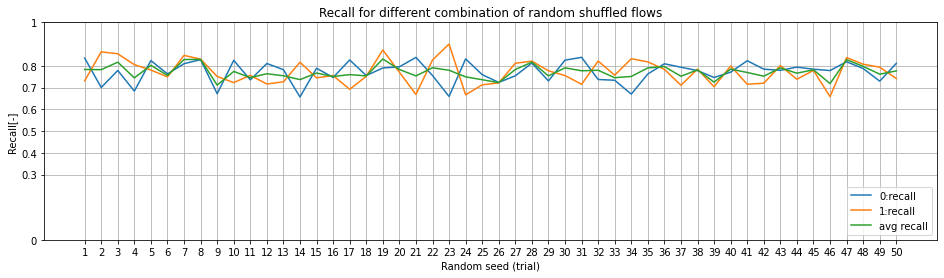

The best performance is at trial 8:
   recall of class 0: 0.8284394897691779
   recall of class 1: 0.8307862272141411
   macro average recall: 0.8296128584916596
                 OR
The best performance is at trial 47:
   recall of class 0: 0.8186470809045903
   recall of class 1: 0.8379672251887313
   macro average recall: 0.8283071530466608


In [52]:
x_label = list(range(1,51))
plt.figure(figsize=(16,4))
plt.plot(x_label, recall_0_list, label='0:recall')
plt.plot(x_label, recall_1_list, label='1:recall')
plt.plot(x_label, recall_avg_list, label='avg recall')
plt.xticks(x_label, x_label)
plt.legend(loc=4)
plt.grid()
plt.ylim([0,1])
plt.yticks([0, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1], [0, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1])
plt.title('Recall for different combination of random shuffled flows')
plt.xlabel('Random seed (trial)')
plt.ylabel('Recall[-]')
plt.show()

print(f'The best performance is at trial 8:\n   recall of class 0: {recall_0_list[7]}\n   recall of class 1: {recall_1_list[7]}\n   macro average recall: {recall_avg_list[7]}')
print('                 OR')
print(f'The best performance is at trial 47:\n   recall of class 0: {recall_0_list[46]}\n   recall of class 1: {recall_1_list[46]}\n   macro average recall: {recall_avg_list[46]}')

#### check how max_delta_step affects the model => nothing changed

In [8]:
my_xgb_model_final = xgb.XGBRegressor(
    learning_rate = 0.138291641997073,
    gamma = 0.11468025232756118,
    max_depth = 5, 
    subsample = 0.7303257684188209,
    colsample_bytree = 0.8397581183840505,
    reg_lambda = 10,
    reg_alpha = 38,
    scale_pos_weight = 77.9123364143053,
    n_estimators = 403,
    n_jobs = 48, 
    objective = 'binary:logistic',
    random_state = 0,
    max_delta_step = 10
)

my_xgb_model_final.fit(x_train, y_train, early_stopping_rounds=10, eval_metric='aucpr', eval_set=[(x_test, y_test)])

[0]	validation_0-aucpr:0.035241
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.048408
[2]	validation_0-aucpr:0.052613
[3]	validation_0-aucpr:0.062545
[4]	validation_0-aucpr:0.065515
[5]	validation_0-aucpr:0.069979
[6]	validation_0-aucpr:0.070538
[7]	validation_0-aucpr:0.073313
[8]	validation_0-aucpr:0.074829
[9]	validation_0-aucpr:0.080036
[10]	validation_0-aucpr:0.082729
[11]	validation_0-aucpr:0.084149
[12]	validation_0-aucpr:0.085381
[13]	validation_0-aucpr:0.087011
[14]	validation_0-aucpr:0.088527
[15]	validation_0-aucpr:0.088225
[16]	validation_0-aucpr:0.090423
[17]	validation_0-aucpr:0.092231
[18]	validation_0-aucpr:0.096567
[19]	validation_0-aucpr:0.097932
[20]	validation_0-aucpr:0.098683
[21]	validation_0-aucpr:0.099951
[22]	validation_0-aucpr:0.101662
[23]	validation_0-aucpr:0.102822
[24]	validation_0-aucpr:0.105671
[25]	validation_0-aucpr:0.106297
[26]	validation_0-aucpr:0.10724
[27]	validation_0-aucpr:0.108209
[28]	validation_0-auc

XGBRegressor(colsample_bytree=0.8397581183840505, gamma=0.11468025232756118,
             learning_rate=0.138291641997073, max_delta_step=10, max_depth=5,
             n_estimators=403, n_jobs=48, objective='binary:logistic',
             reg_alpha=38, reg_lambda=10, scale_pos_weight=77.9123364143053,
             subsample=0.7303257684188209)

Prediction Report of trial
               precision    recall  f1-score   support

           0       1.00      0.85      0.92    600134
           1       0.07      0.75      0.12      8461

    accuracy                           0.85    608595
   macro avg       0.53      0.80      0.52    608595
weighted avg       0.98      0.85      0.91    608595



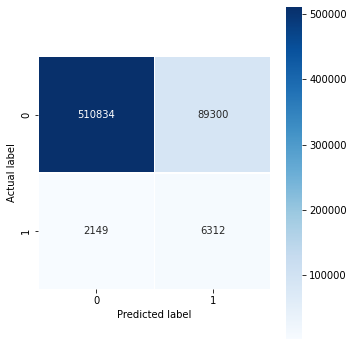

In [9]:
y_pred = my_xgb_model_final.predict(x_test)
y_pred_label = [0 if x<0.5 else 1 for x in y_pred]
print(f"Prediction Report of trial\n", classification_report(y_test, y_pred_label))
cm = confusion_matrix(y_test, y_pred_label)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm, linewidths=.5, annot=True, square=True, cmap='Blues', fmt='d')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()